In [22]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
import pyproj
from shapely.affinity import scale
import folium
import shutil

In [23]:
from data_collection import *
from functions import *

## Obtain all rivers

In [45]:
import subprocess

# Ruta al archivo shapefile de entrada
input_shapefile = '../data/external/shp/swiss_rivers'

# Usar ogrinfo para listar los valores en el campo NAME
command = [
    'ogrinfo',
    '-q',  # Ejecutar en modo silencioso excepto los resultados
    '-geom=NO',  # No mostrar las geometrías
    '-sql', "SELECT NAME FROM swissTLM3D_TLM_FLIESSGEWAESSER WHERE Verlauf = 'Oberirdisch'",# AND ST_Length(geometry) > 30",  # Ejecutar una consulta SQL para seleccionar la columna NAME
    input_shapefile
]

# Ejecutar el comando y capturar la salida
result = subprocess.run(command, capture_output=True, text=True)


river_names = set()
for line in result.stdout.split('\n'):
    if 'NAME (String)' in line:  # Buscar las líneas que contienen los nombres
        name = line.split('=')[-1].strip()  # Extraer el nombre del río
        river_names.add(name)  # Añadirlo a un set para obtener nombres únicos

# Mostrar los nombres únicos de los ríos
print(f'Nombres únicos de los ríos: {river_names}')


Nombres únicos de los ríos: {'Schüsselbach', 'Ramserlibächli', 'Fiume Peccia', 'Spitzalpelibach', 'Ruisseau de Châtillon', 'Matällerbach', 'Ruisseau des Tenasses', 'Torrent de Greffe', 'Ruisseau des Frassy', 'Raptgusa', 'Kasperabach', 'Seltenbach', 'Bruederbach', 'El Ri Vall Mála', 'Riale della Valle', 'Ruisseau de Pra Gouma', 'Guuhetbach', 'Riale di Motóm', 'Ruisseau de la Leyvra', 'Üsser Bärgelbach', 'Wiesenbach', 'Calcascia', 'Ruisseau de la Croix', 'Rausenbach', 'Ruisseau de Coppet', 'Stössbach', 'Leiterbergbach', 'Hindertöss', 'Bisse de Marais', 'Ri dei Calcestri', 'Lammbach', 'Riale della Fontana', 'Maira | Mera', 'Ri di Costa', 'Ragn da Colm', 'Tschermanner Bach', 'Susasca', 'La Saufla', 'Emme', 'Jörenbach', 'Malbunbach', 'Rotenbächli', 'Ri di Piera', 'Hindereggbächli', 'Haagbach', 'Ruisseau du Perelet', 'Chrauchbach', 'Tschägibach', 'Härmedingebächli', 'Guetentalbach', 'Schlossfirnbach', 'Schrabach', 'Ova da Chaschanella', 'Staffeleggbach', 'Torrent de la Forniry', 'Ruisseau du

In [47]:
river_names_filt = list(river_names)[:50]
len(river_names_filt)

50

In [48]:
import unidecode
def clean_name(river_name):
    # Eliminar acentos
    river_name_clean = unidecode.unidecode(river_name)
    
    # Reemplazar espacios con guiones bajos
    river_name_clean = river_name_clean.replace(' ', '_')
    
    # Eliminar apóstrofes y otros caracteres especiales
    river_name_clean = river_name_clean.replace("'", "").replace('"', "")
    
    return river_name_clean

In [49]:
output_folder = '../data/external/shp/rivers/'

# Filtrar y exportar cada río individualmente
for river_name in river_names_filt:
    # Definir el nombre del shapefile de salida para cada río
    safe_river_name = clean_name(river_name)  # Asegurarse de que no haya espacios en el nombre del archivo
    
    path_river = os.path.join(output_folder, safe_river_name)
    os.makedirs(path_river, exist_ok=True)
    clear_directory(path_river)

    output_shapefile = f'{path_river}/{safe_river_name}.shp'
    
    # Comando ogr2ogr para filtrar y exportar el shapefile
    command = [
        'ogr2ogr',
        '-where', f"NAME = '{river_name}'",  # Filtrar por el nombre del río
        output_shapefile,
        input_shapefile
    ]
    
    # Ejecutar el comando
    subprocess.run(command)
    print(f'Shapefile para {river_name} creado: {output_shapefile}')


Shapefile para Schüsselbach creado: ../data/external/shp/rivers/Schusselbach/Schusselbach.shp
Shapefile para Ramserlibächli creado: ../data/external/shp/rivers/Ramserlibachli/Ramserlibachli.shp
Shapefile para Fiume Peccia creado: ../data/external/shp/rivers/Fiume_Peccia/Fiume_Peccia.shp
Shapefile para Spitzalpelibach creado: ../data/external/shp/rivers/Spitzalpelibach/Spitzalpelibach.shp
Shapefile para Ruisseau de Châtillon creado: ../data/external/shp/rivers/Ruisseau_de_Chatillon/Ruisseau_de_Chatillon.shp
Shapefile para Matällerbach creado: ../data/external/shp/rivers/Matallerbach/Matallerbach.shp
Shapefile para Ruisseau des Tenasses creado: ../data/external/shp/rivers/Ruisseau_des_Tenasses/Ruisseau_des_Tenasses.shp
Shapefile para Torrent de Greffe creado: ../data/external/shp/rivers/Torrent_de_Greffe/Torrent_de_Greffe.shp
Shapefile para Ruisseau des Frassy creado: ../data/external/shp/rivers/Ruisseau_des_Frassy/Ruisseau_des_Frassy.shp
Shapefile para Raptgusa creado: ../data/external/

## Shapefile specifications

In [10]:
source_folder = '../data/external/shp/rivers/'
#source_folder = '../data/external/shp/rivers/LaBroye_shapefile'

In [107]:
len(rivers.keys())

51

In [106]:
import fiona
import geopandas as gpd
from shapely.geometry import shape
from fiona.errors import FionaDeprecationWarning  # Importar la advertencia de Fiona
import warnings
from shapely.ops import unary_union

# Suprimir la advertencia deprecada de Fiona
warnings.filterwarnings("ignore", category=FionaDeprecationWarning)


rivers = {}

for subdir, dirs, files in os.walk(source_folder):
    if len(dirs) == 0:
        
        with fiona.open(subdir, 'r') as src:
            # Extraer geometrías y atributos
            features = []
            for feature in src:
                geom = shape(feature['geometry'])  # Convertir la geometría a un objeto Shapely
                properties = feature['properties']  # Obtener los atributos
                properties['geometry'] = geom  # Añadir la geometría a los atributos
                features.append(properties)

            # Convertir la lista de características a un GeoDataFrame
            river = gpd.GeoDataFrame(features, crs="EPSG:2056")
            gdf = river.to_crs('EPSG:2056')
            # Combinar todas las geometrías en una sola usando `unary_union`
            combined_geom = unary_union(river.geometry)
            
            # Verificar si la geometría combinada es válida
            if combined_geom.is_empty:
                print(f"Río en {subdir.split('/')[-1]} está vacío tras la combinación.")
                continue

            # Calcular la longitud de la geometría combinada
            total_length = combined_geom.length  # Longitud total en metros

            # Calcular el área del bounding box de la geometría combinada
            bounding_box = river.total_bounds  # [minx, miny, maxx, maxy]
            width = bounding_box[2] - bounding_box[0]
            height = bounding_box[3] - bounding_box[1]
            area = width * height  # Área en metros 

            bounding_box_diagonal = ((bounding_box[2] - bounding_box[0])**2 + (bounding_box[3] - bounding_box[1])**2)**0.5

            length_percentage = (total_length / bounding_box_diagonal) * 100  # Comparación en función de la diagonal
            
            print(f"El río ocupa {length_percentage:.2f}% de la diagonal del shapefile.")
            
            
            # Definir umbrales
            min_area_threshold = 225_000  # Área mínima en m² (0.225 km²)
            min_length_threshold = 300  # Longitud mínima en metros
            if 'Ruisseau_de_la_Croix' ==subdir.split('/')[-1]:
                print(f"Río {subdir.split('/')[-1]}: Longitud total {total_length:.2f} metros, Área {area:.2f} m²")
                
            # Verificar si cumple los umbrales de longitud y área
            if area > min_area_threshold and total_length > min_length_threshold and length_percentage > 50:
                river = river.to_crs("EPSG:4326")
                rivers[subdir.split('/')[-1]] = river
                #print(river.shape)
                # Convertir el CRS a EPSG:4326 si cumple los criterios
                '''river_combined = gpd.GeoDataFrame([{'geometry': combined_geom}], crs='EPSG:2056')
                river_combined = river_combined.to_crs("EPSG:4326")
                rivers[subdir.split('/')[-1]] = river_combined
                print(river_combined.shape)
               
            
            
            min_area_threshold = 225_000  # Área mínima en m² (0.09 km²)
            bounding_box = river.total_bounds  # [minx, miny, maxx, maxy]

            # Calcular el área aproximada de la extensión (bounding box) en metros cuadrados
            # (maxx - minx) es el ancho de la extensión, (maxy - miny) es la altura
            width = bounding_box[2] - bounding_box[0]
            height = bounding_box[3] - bounding_box[1]
            area = width * height  # Área aproximada en metros cuadrados
            min_length_threshold = 300  # Por ejemplo, ríos con al menos 300 metros de longitud

            # Calcular la longitud de cada río (en metros) y filtrar los que superan el umbral
            length = river.geometry.length.sum()  # Calcula la longitud de cada geometría
            if 'Ruisseau _de_la_Croix' ==subdir.split('/')[-1]:
                print(f"Suma per riu {subdir.split('/')[-1]}: {length}")

            if area > min_area_threshold and length > min_length_threshold:
                #print('Area',area)
                original_crs = river.crs
                river = river.to_crs("EPSG:4326")
                #print(subdir)
                rivers[subdir.split('/')[-1]] = river
                #print(river.shape)
                c+=1'''
            

El río ocupa 101.17% de la diagonal del shapefile.
El río ocupa 108.92% de la diagonal del shapefile.
El río ocupa 116.09% de la diagonal del shapefile.
El río ocupa 119.44% de la diagonal del shapefile.
El río ocupa 124.34% de la diagonal del shapefile.
El río ocupa 128.28% de la diagonal del shapefile.
El río ocupa 117.42% de la diagonal del shapefile.
El río ocupa 125.26% de la diagonal del shapefile.
El río ocupa 112.91% de la diagonal del shapefile.
El río ocupa 134.03% de la diagonal del shapefile.
El río ocupa 114.63% de la diagonal del shapefile.
El río ocupa 157.71% de la diagonal del shapefile.
El río ocupa 104.74% de la diagonal del shapefile.
El río ocupa 101.06% de la diagonal del shapefile.
El río ocupa 117.54% de la diagonal del shapefile.
El río ocupa 127.15% de la diagonal del shapefile.
El río ocupa 114.52% de la diagonal del shapefile.
El río ocupa 131.22% de la diagonal del shapefile.
El río ocupa 108.25% de la diagonal del shapefile.
El río ocupa 61.95% de la diago

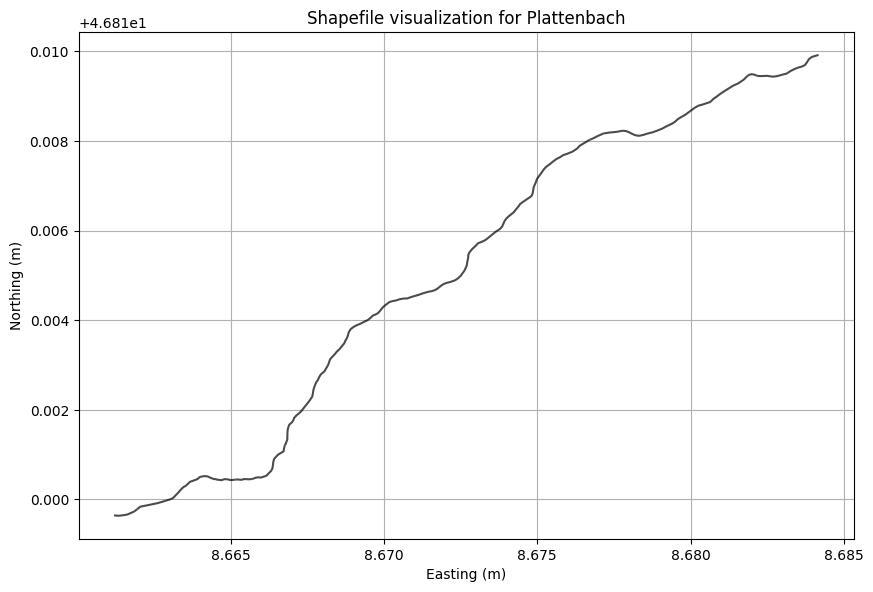

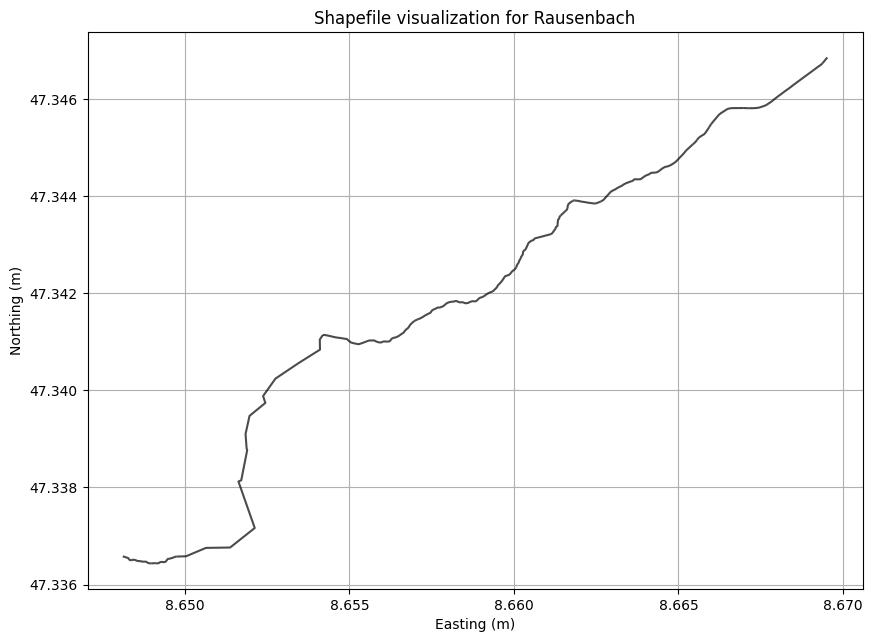

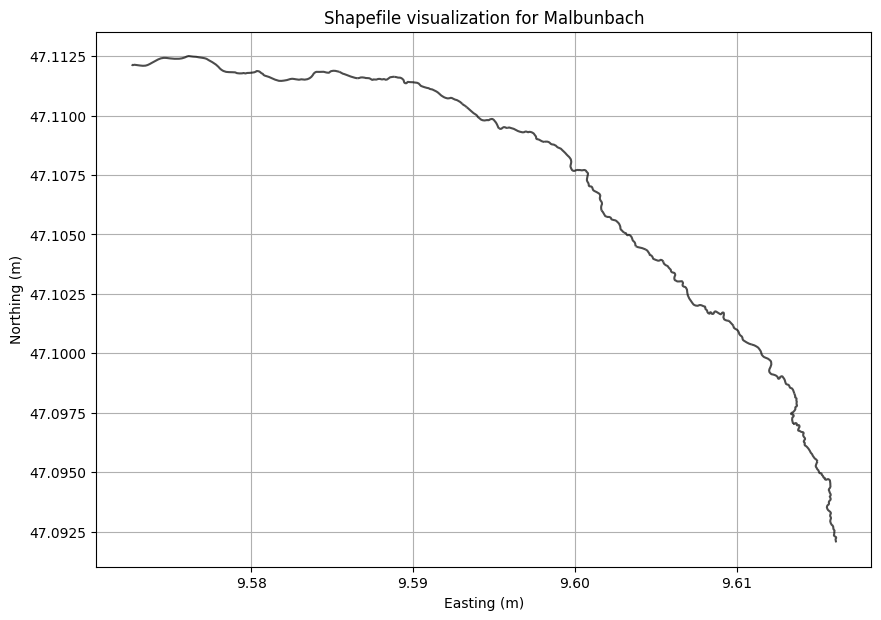

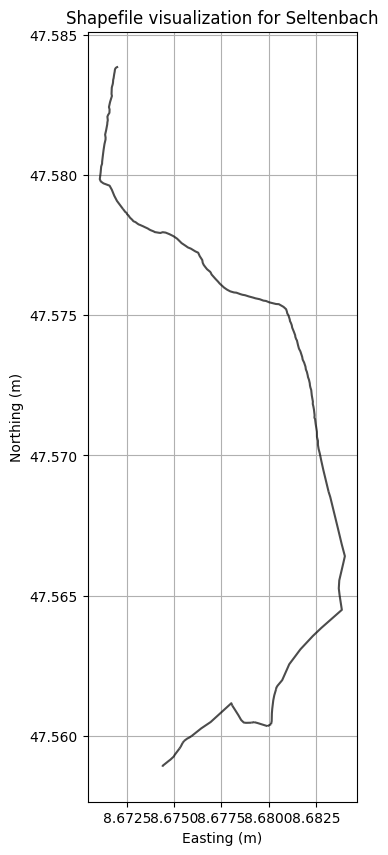

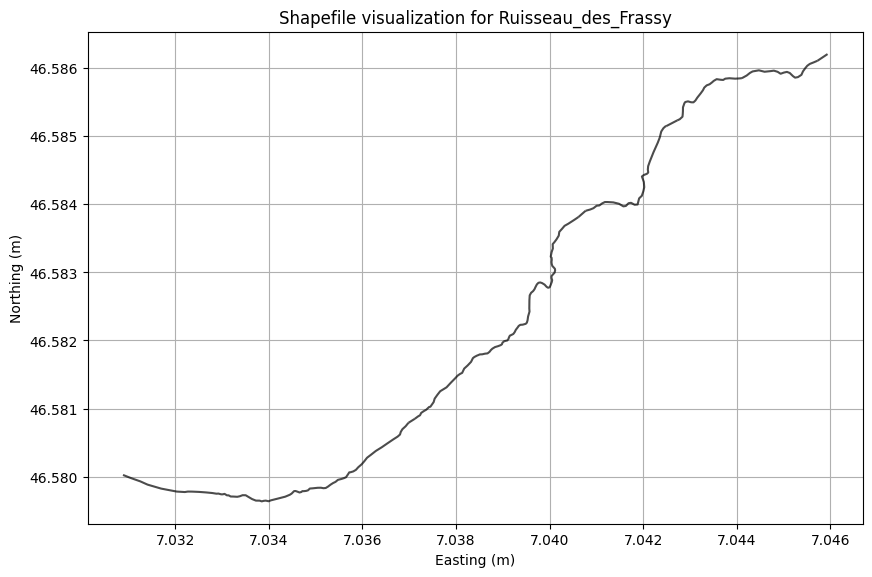

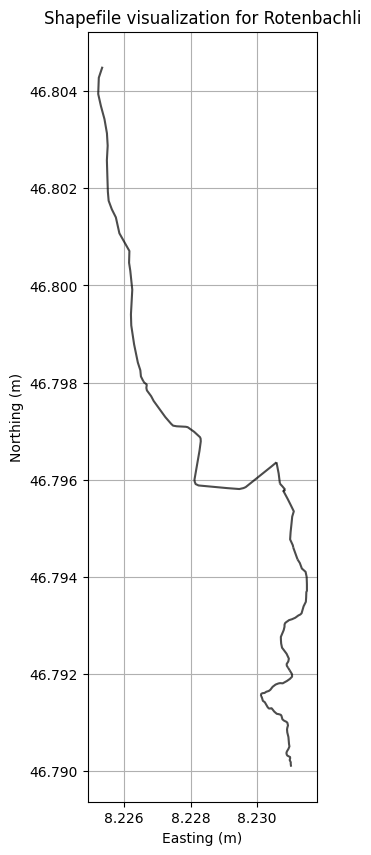

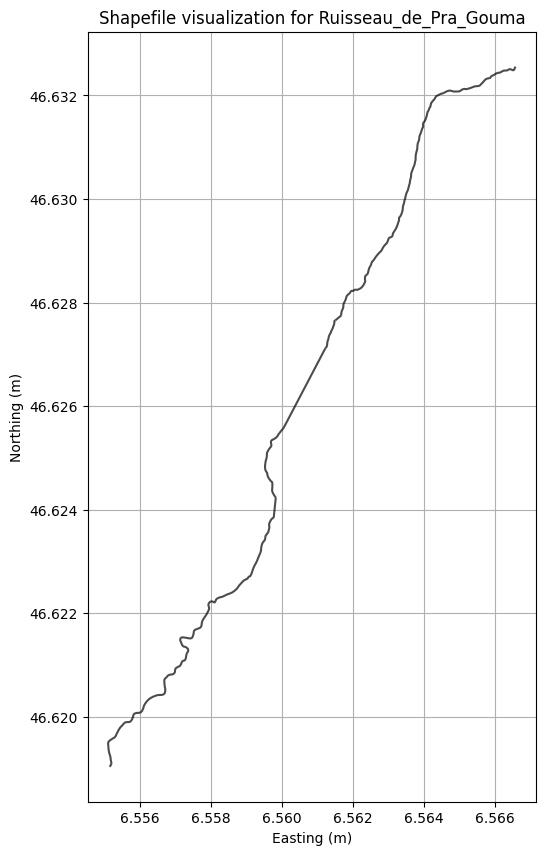

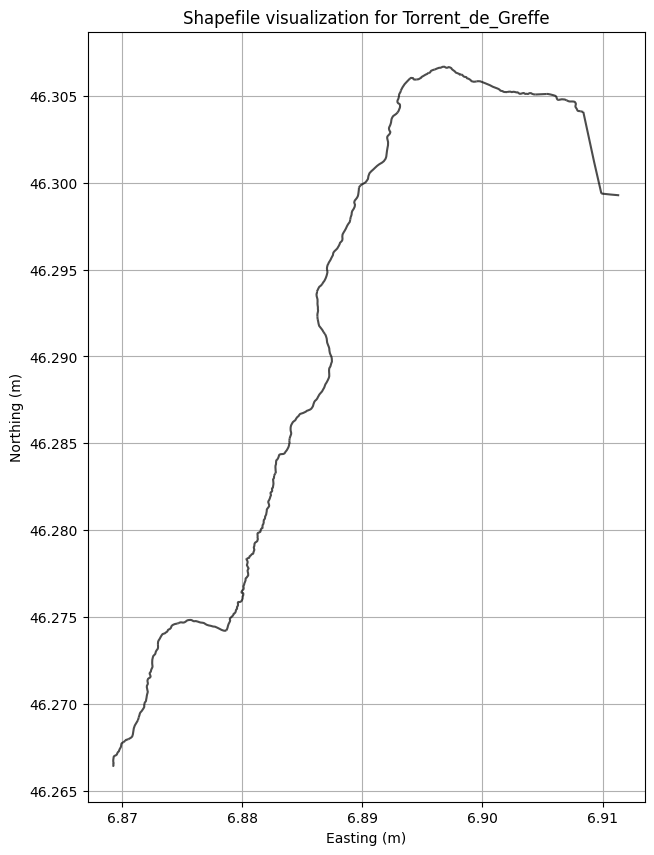

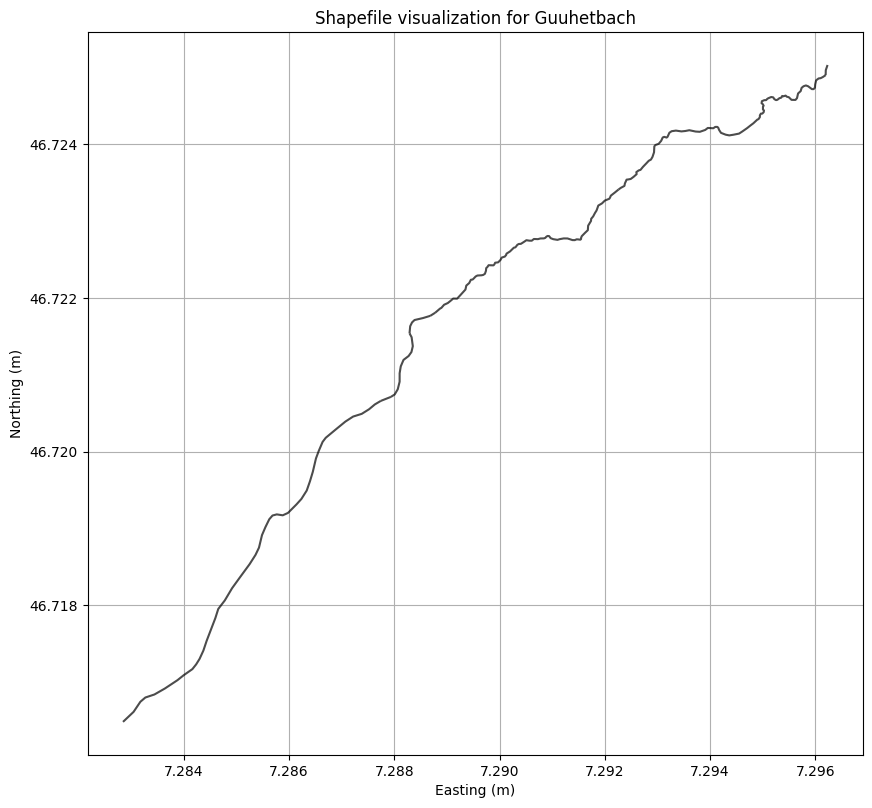

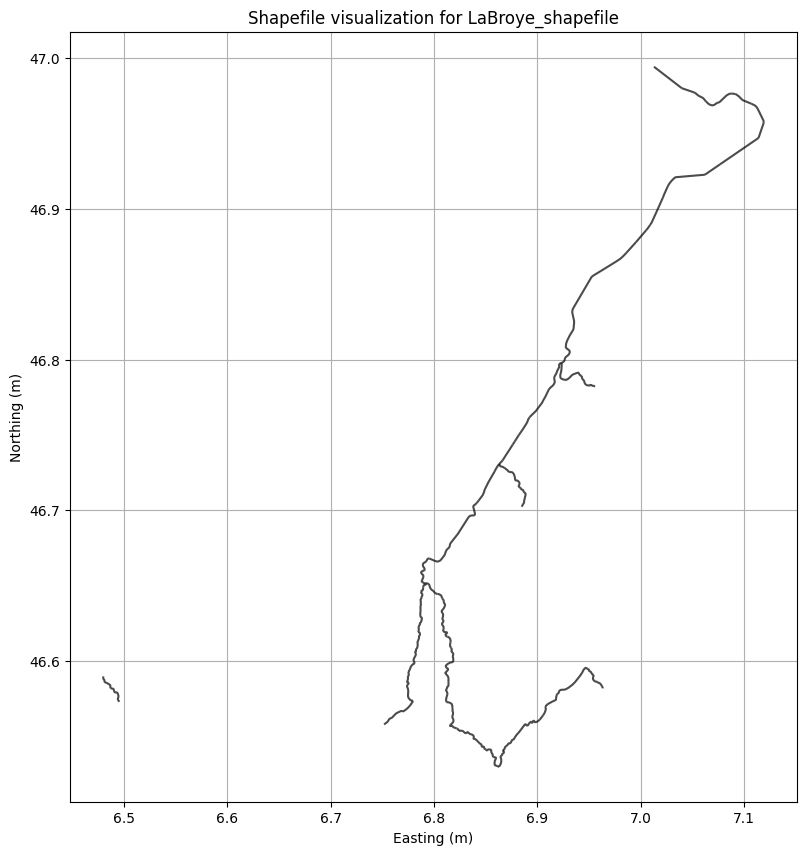

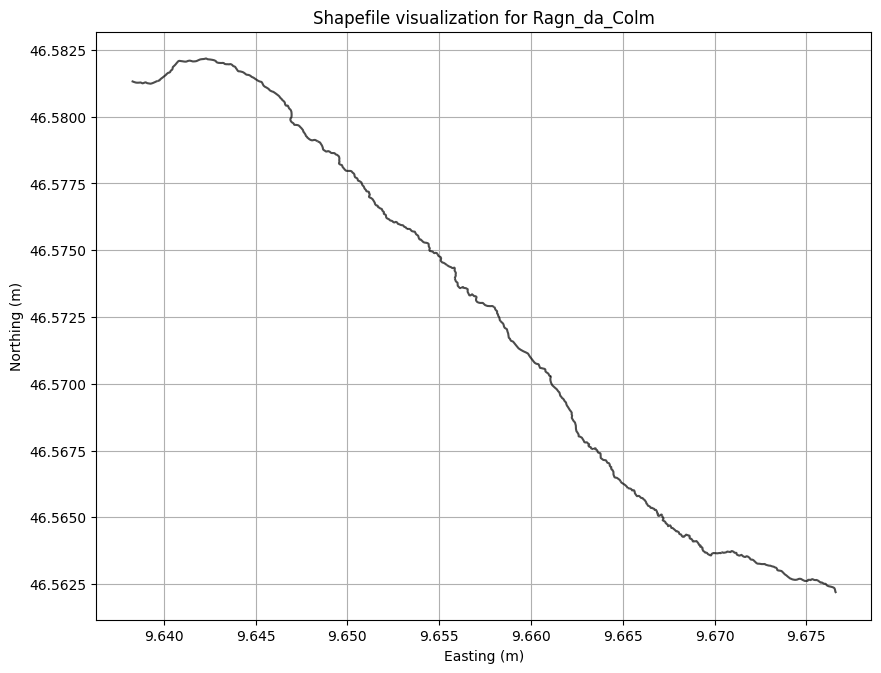

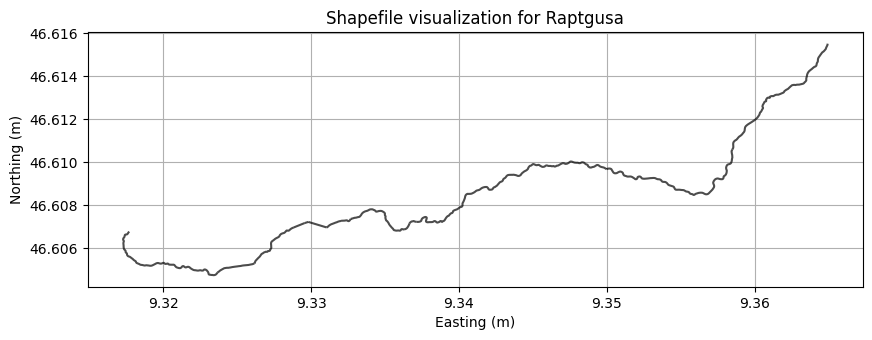

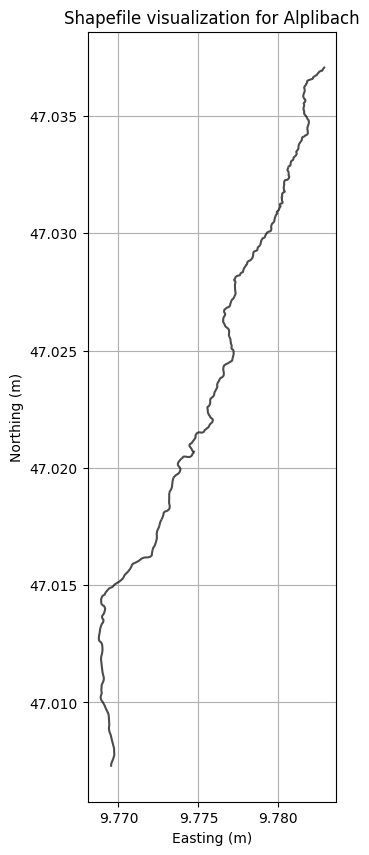

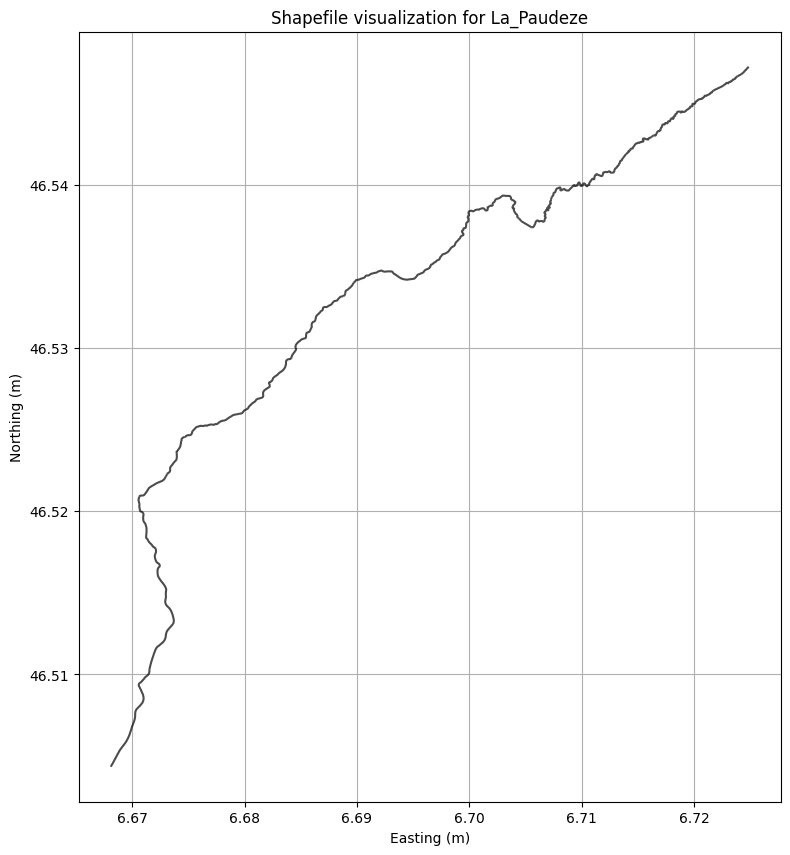

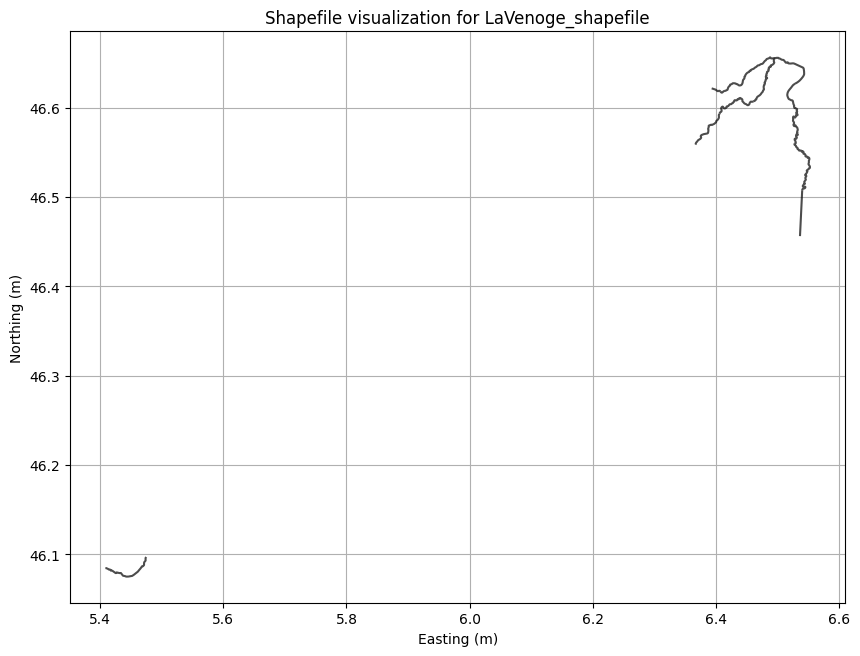

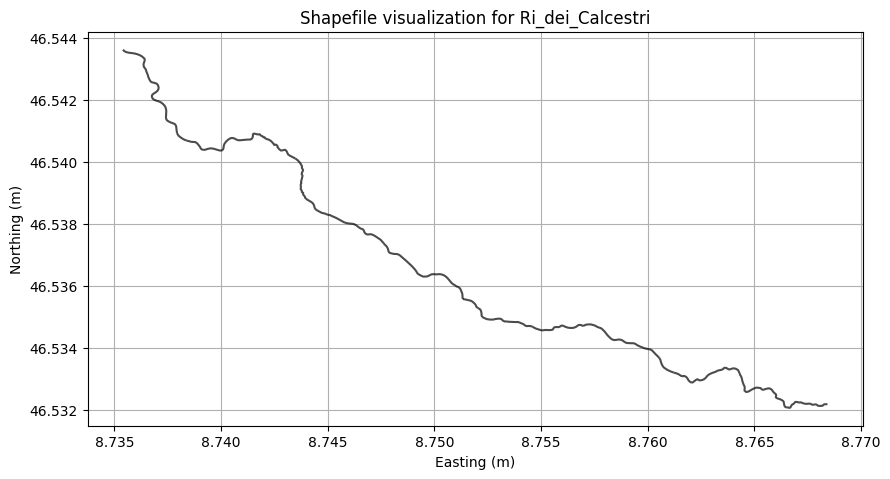

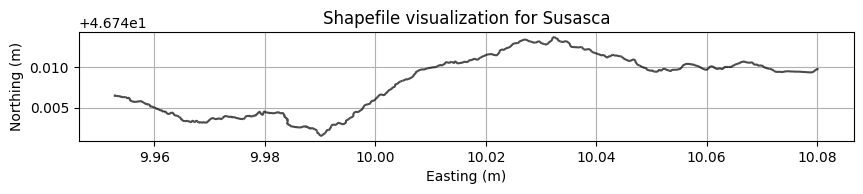

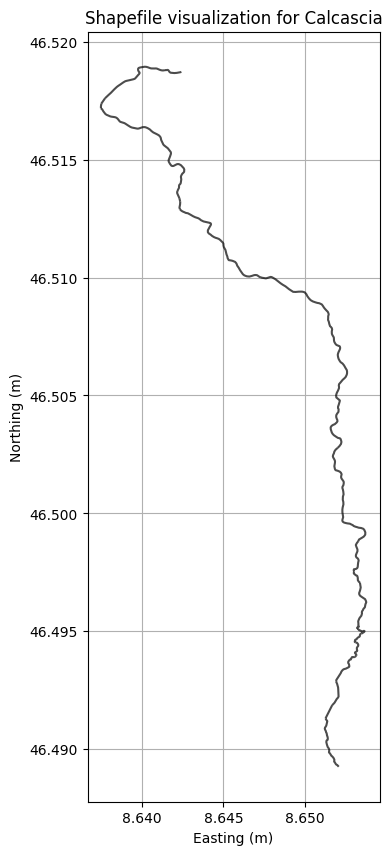

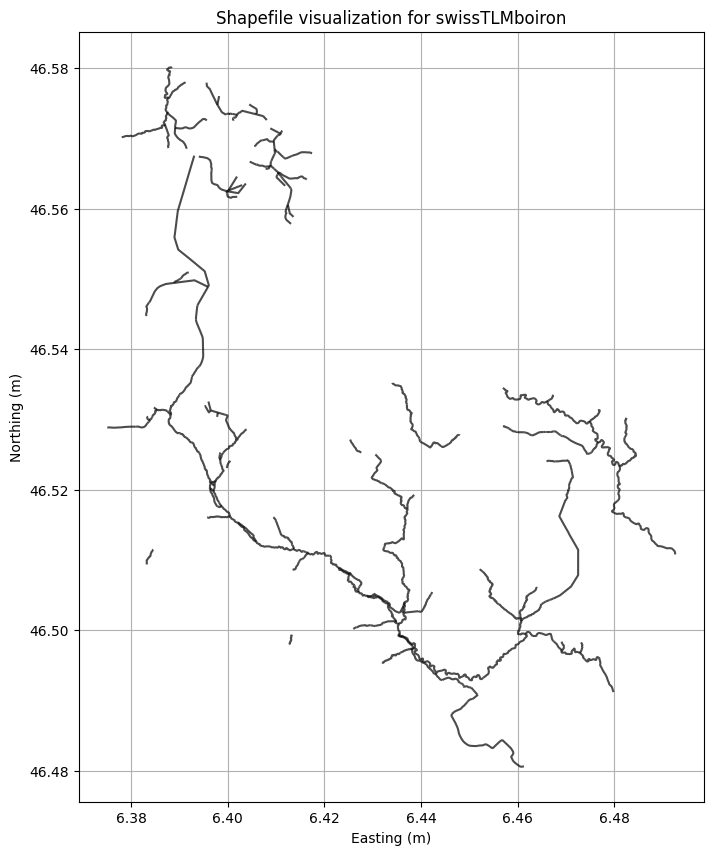

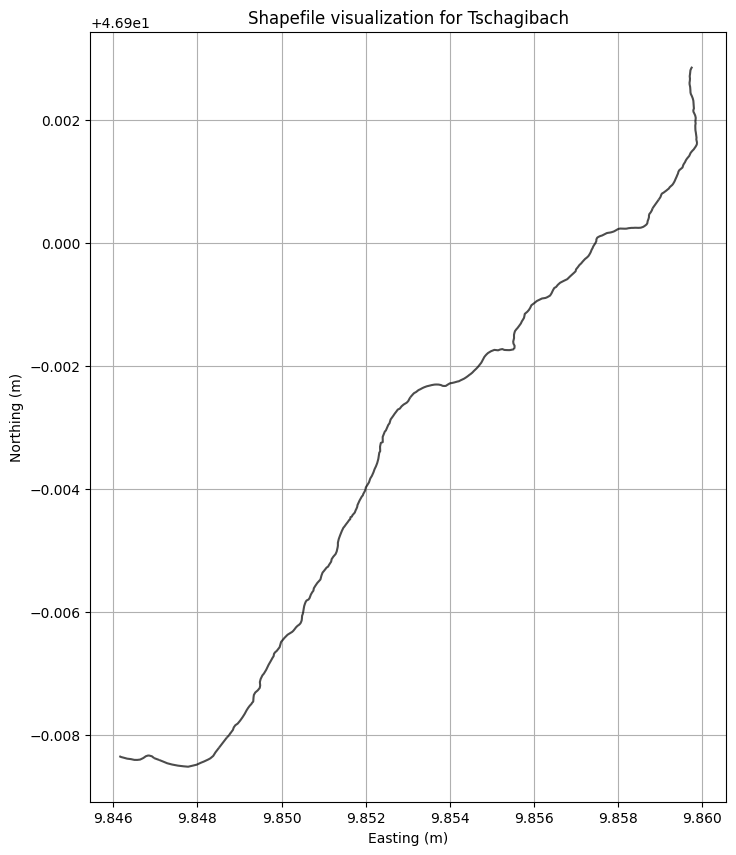

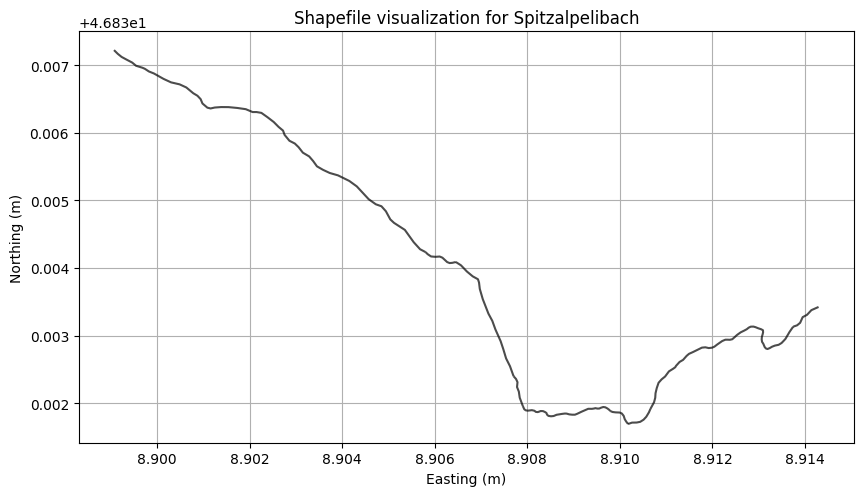

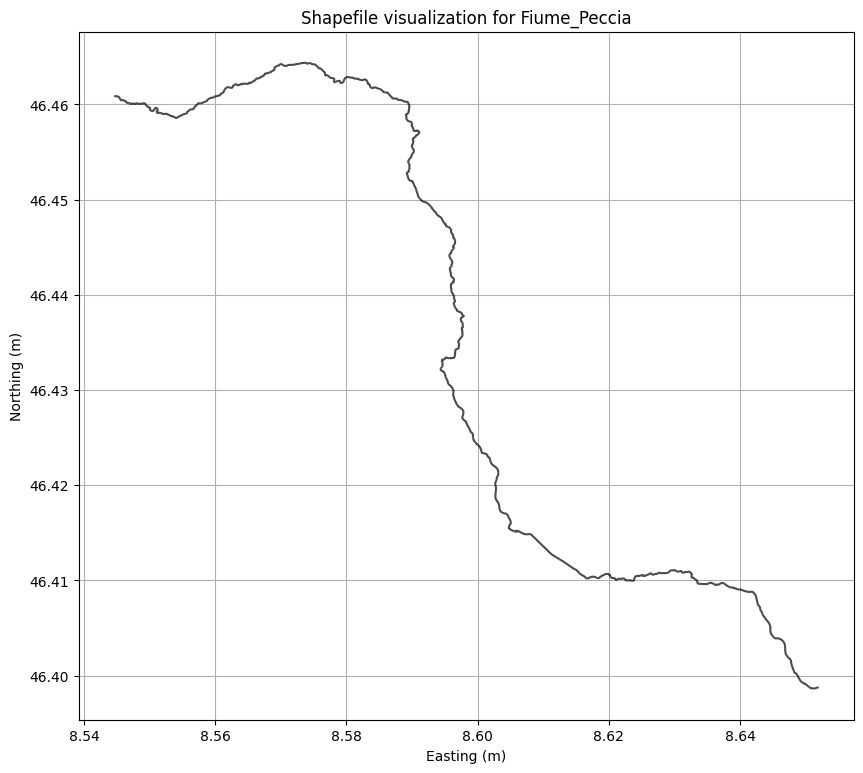

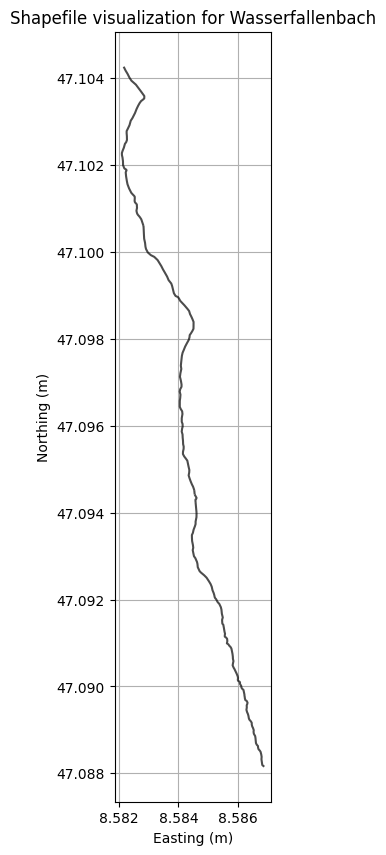

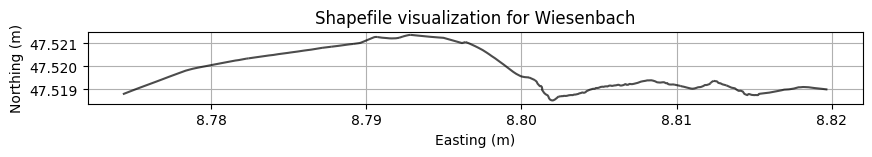

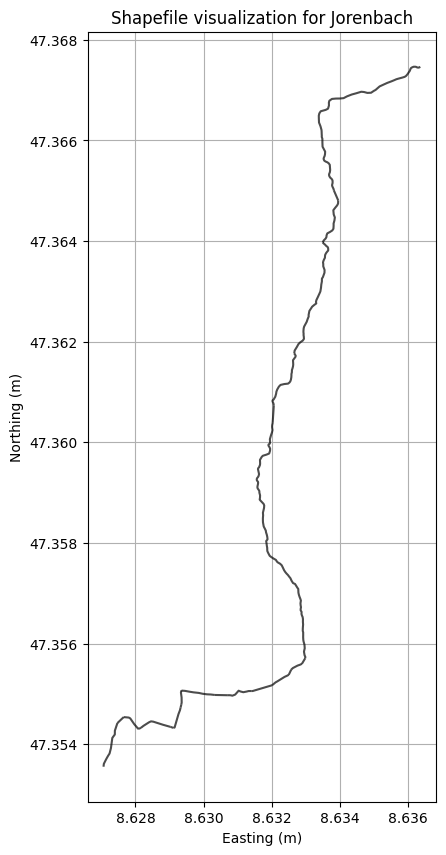

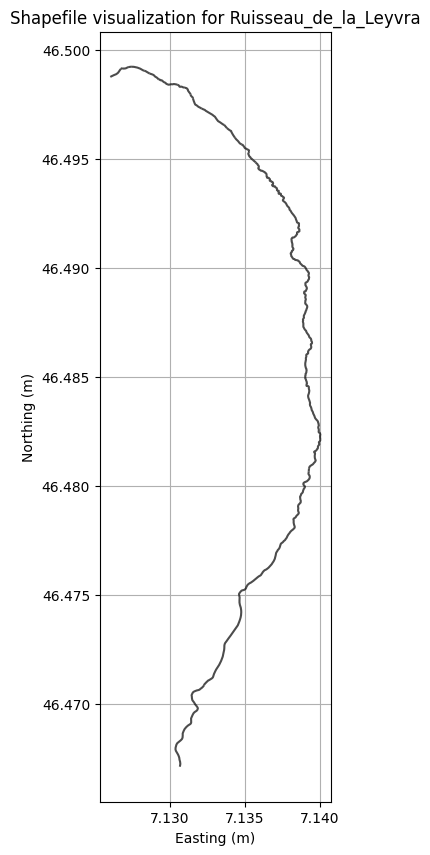

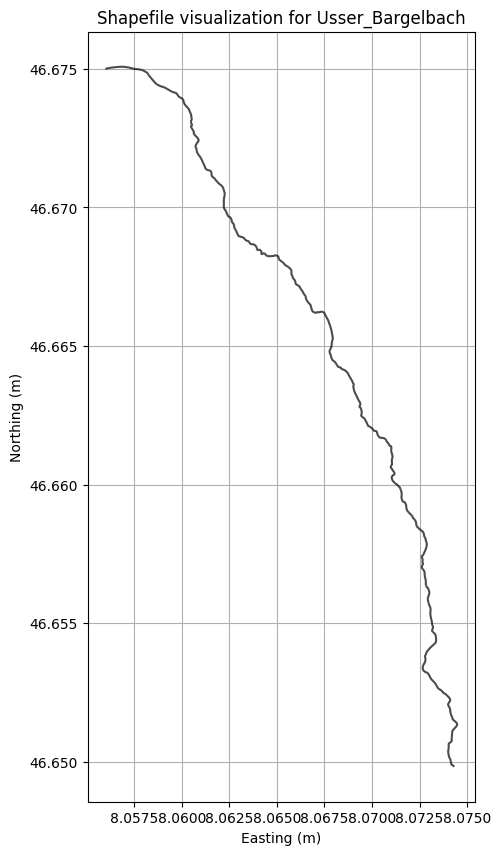

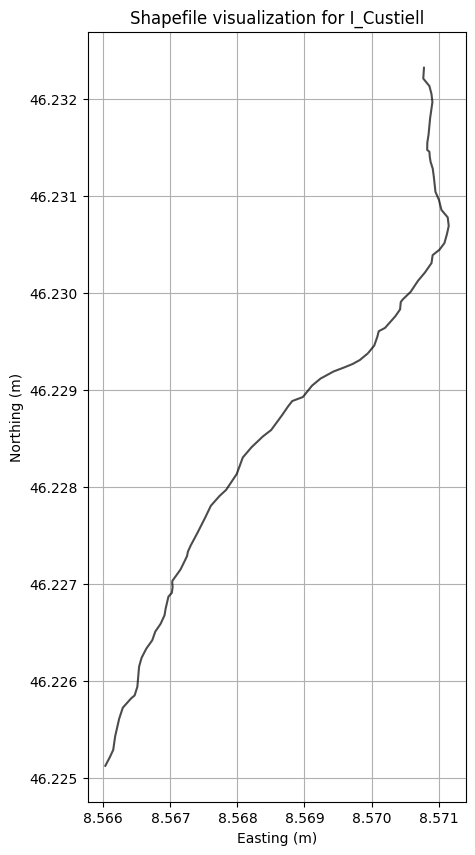

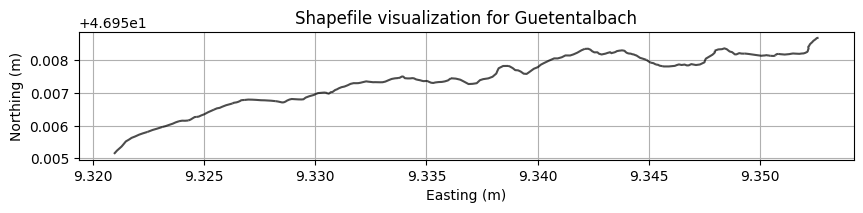

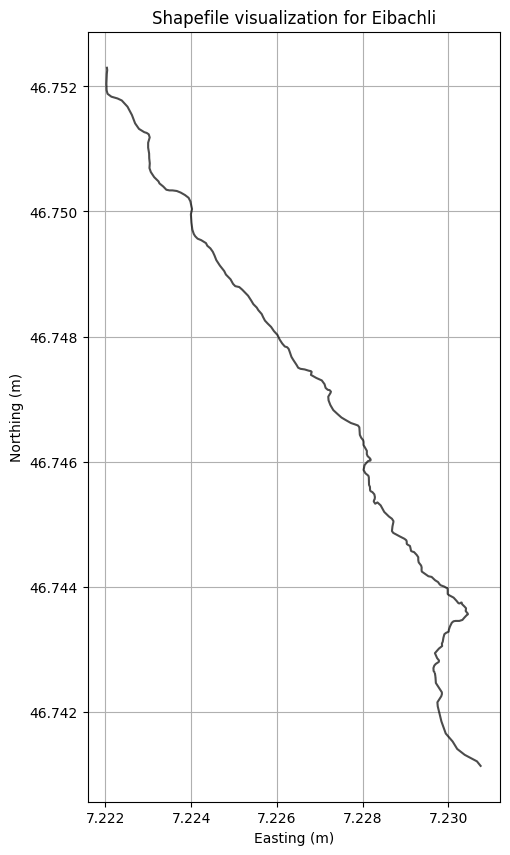

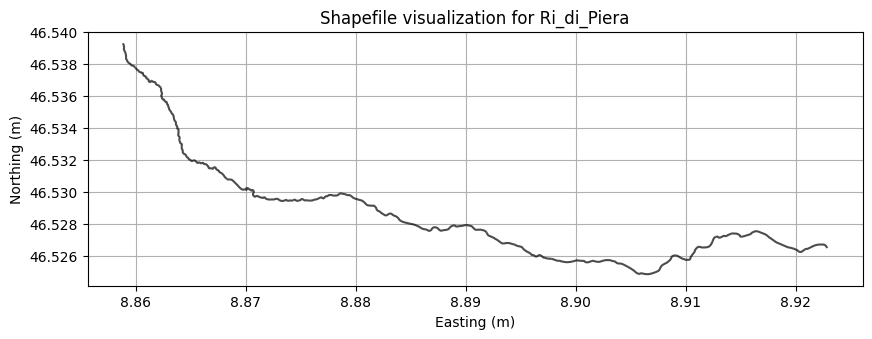

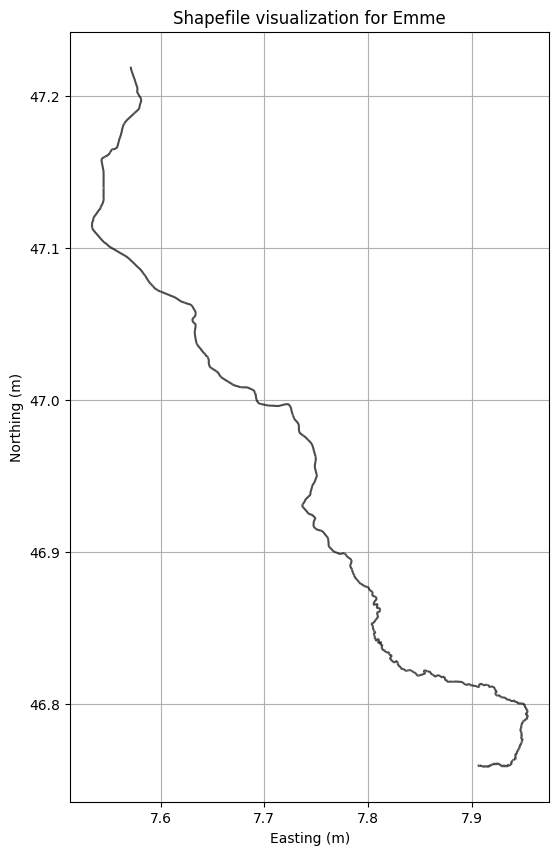

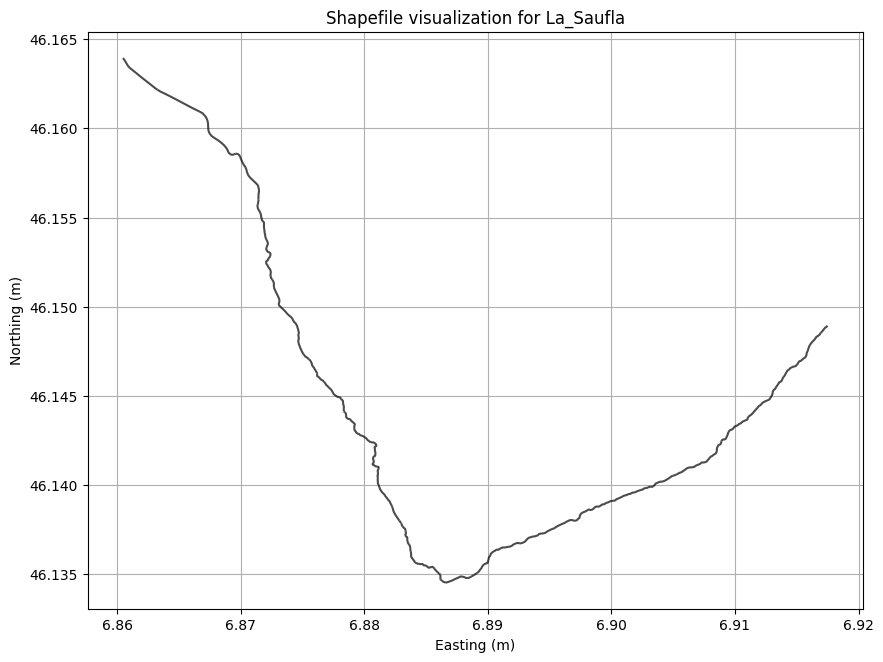

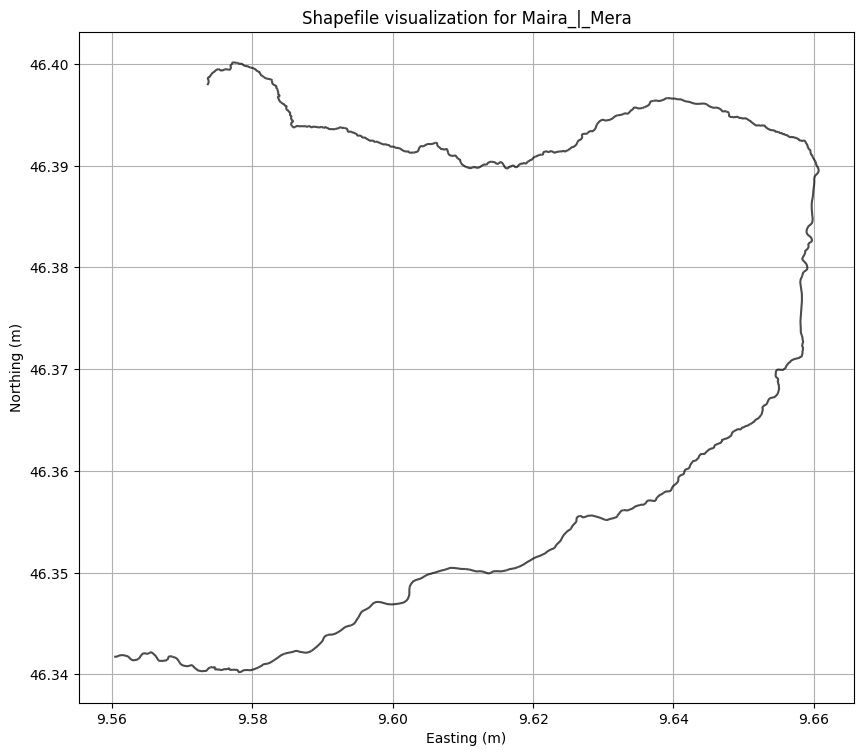

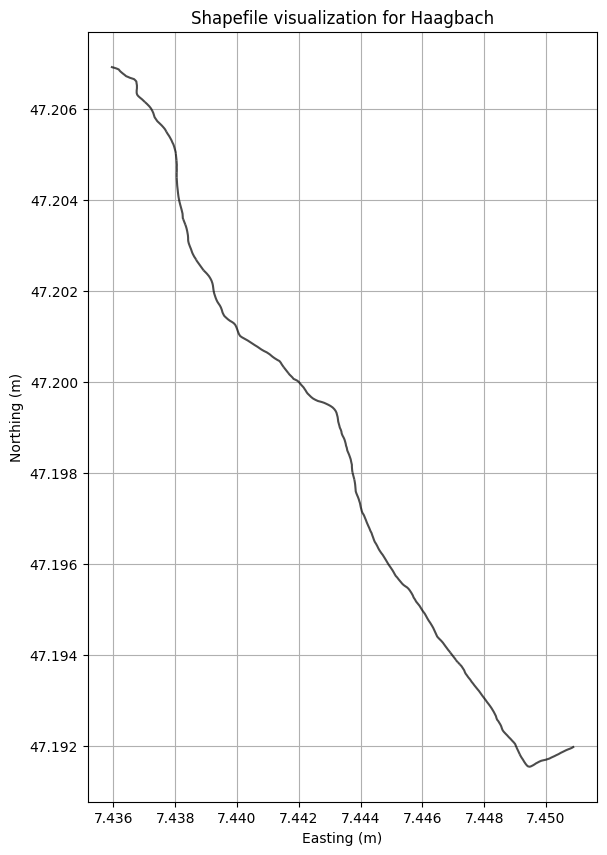

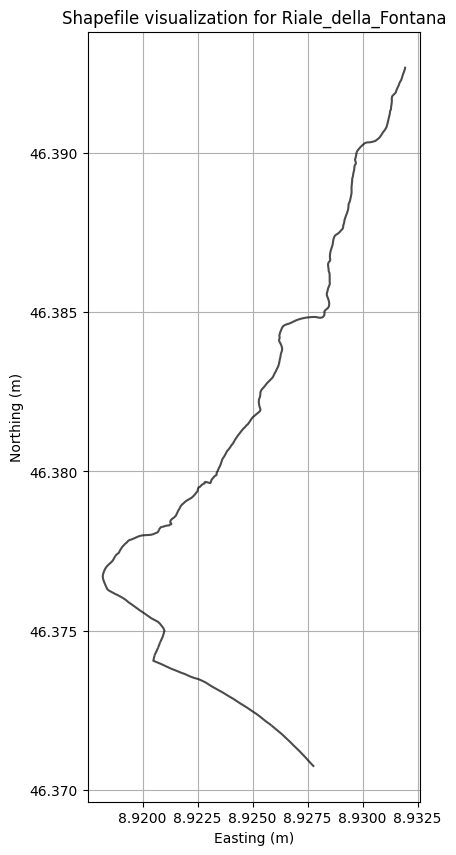

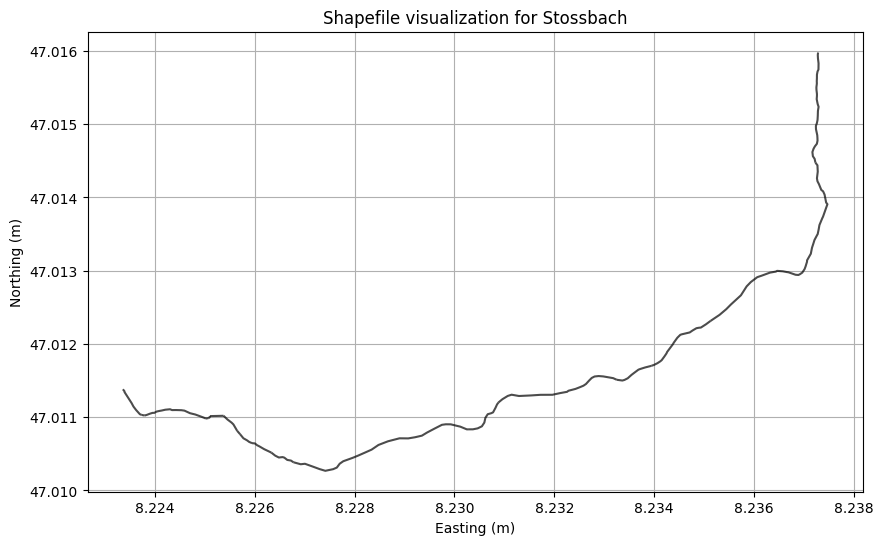

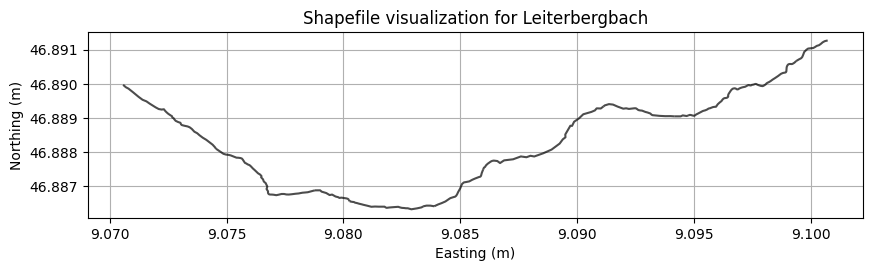

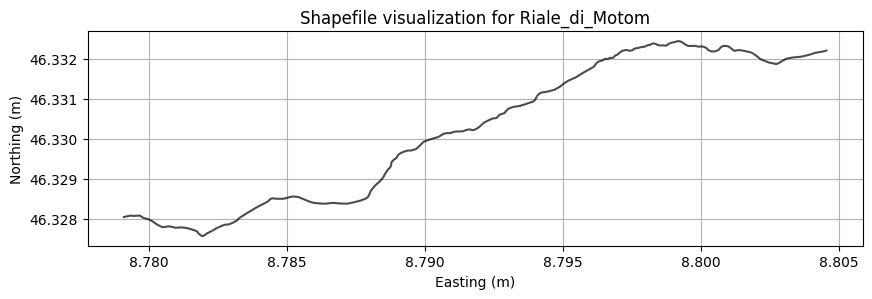

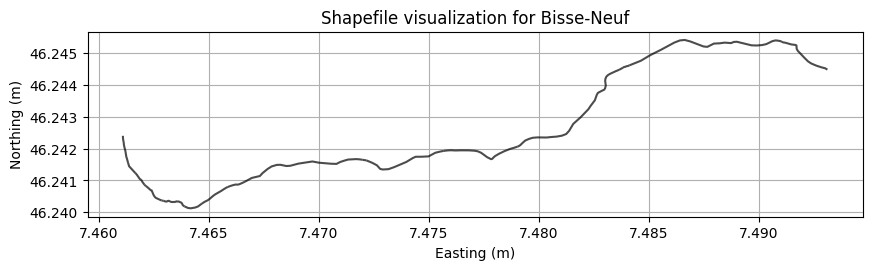

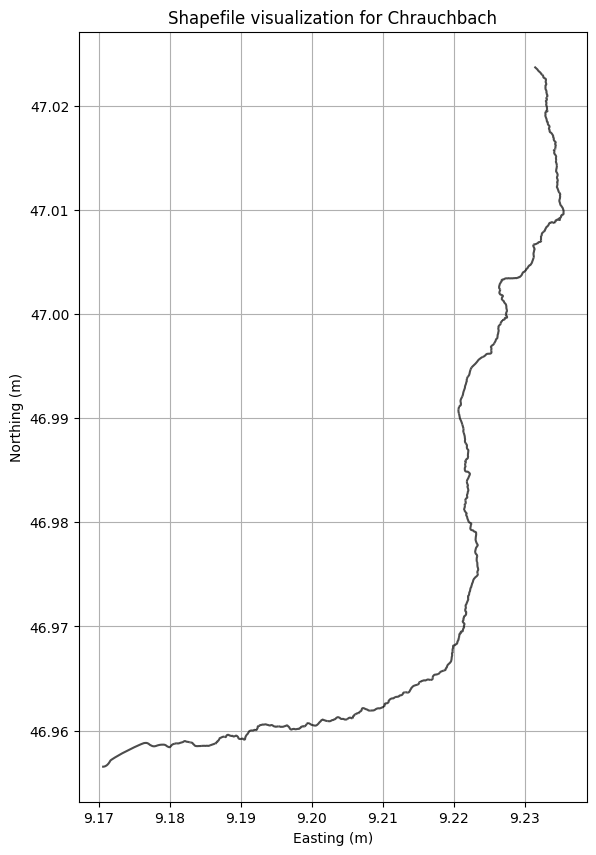

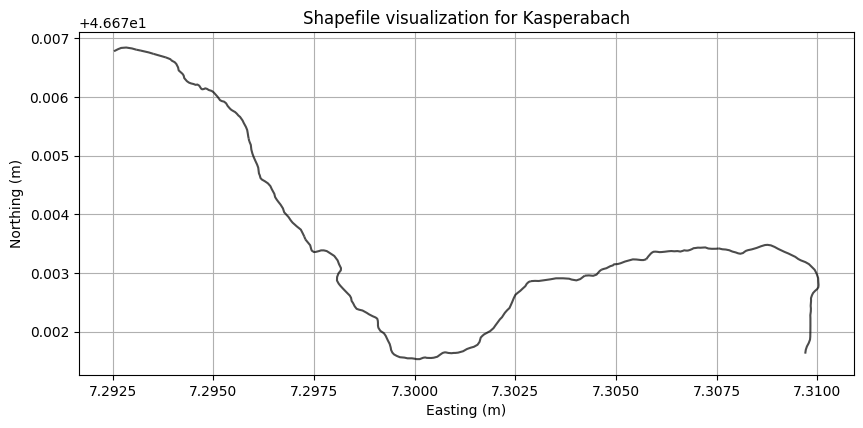

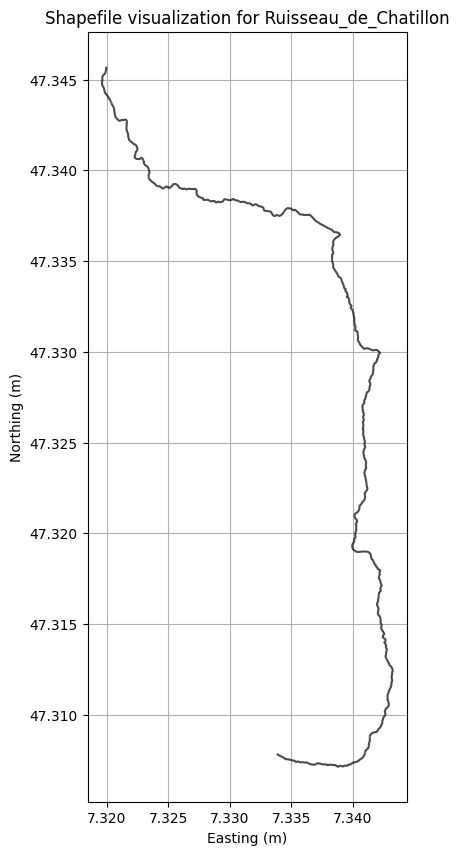

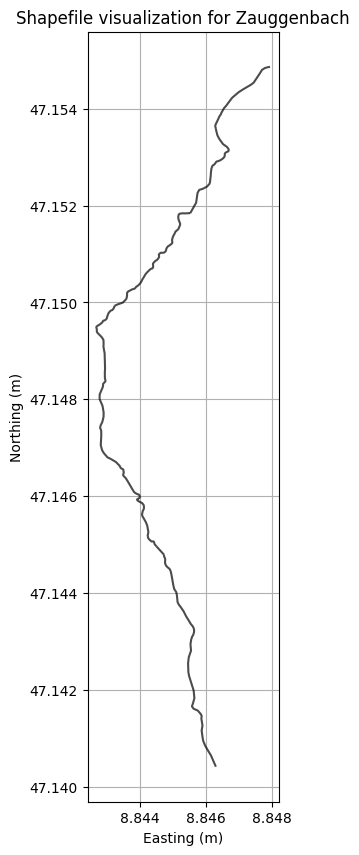

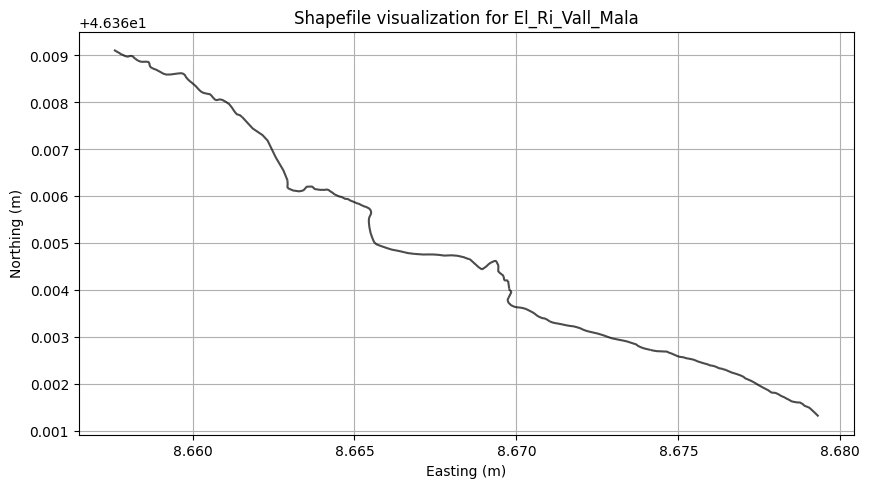

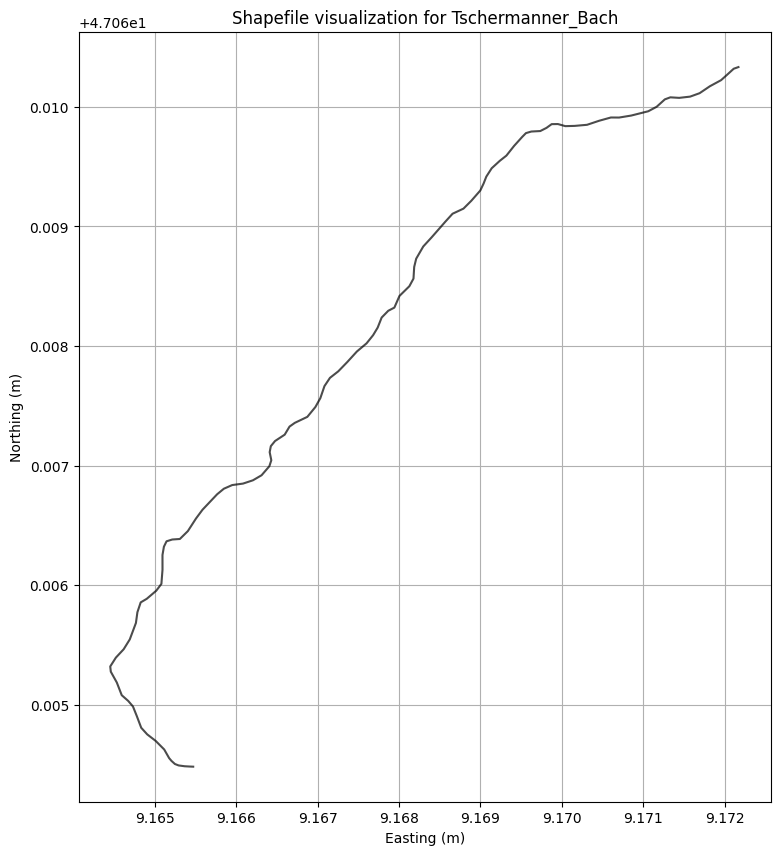

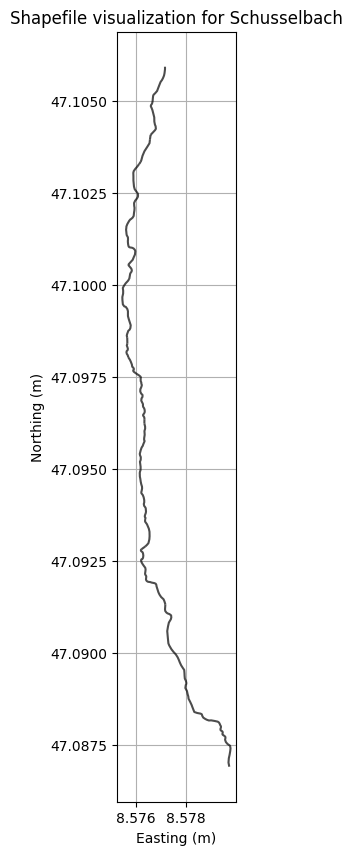

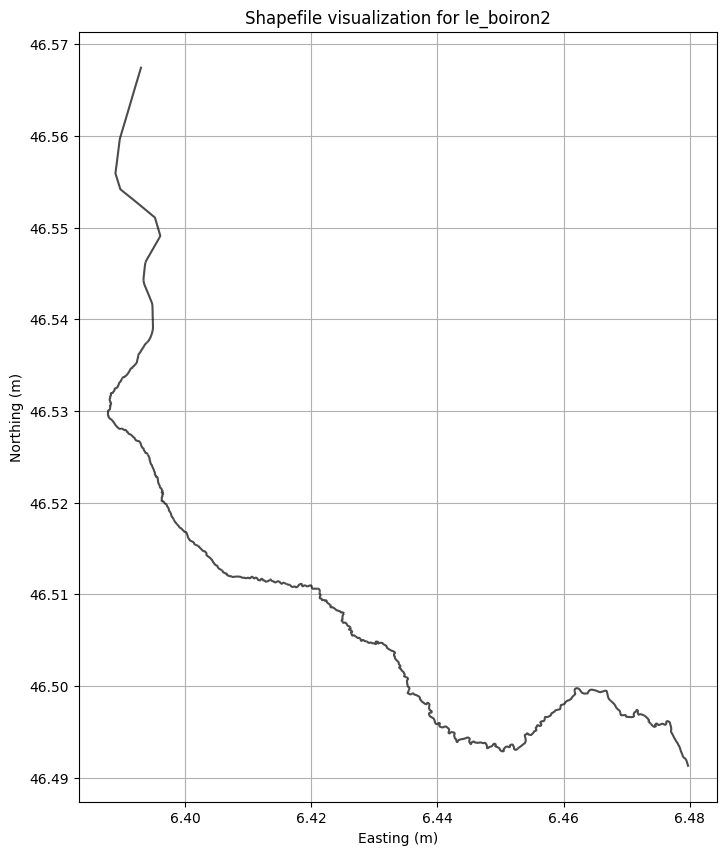

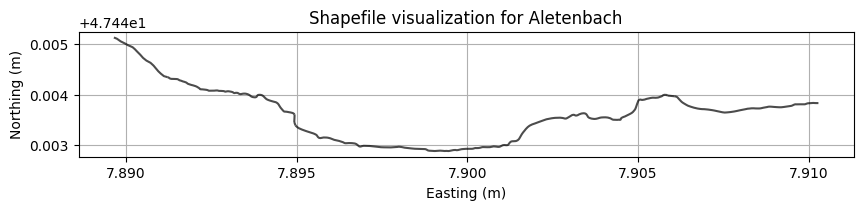

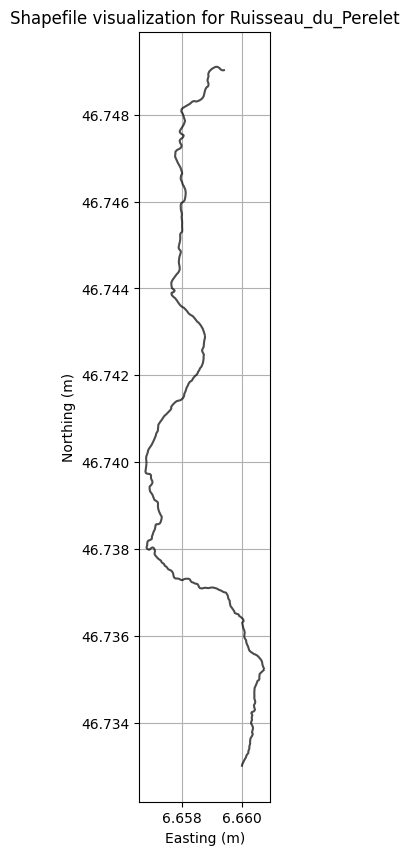

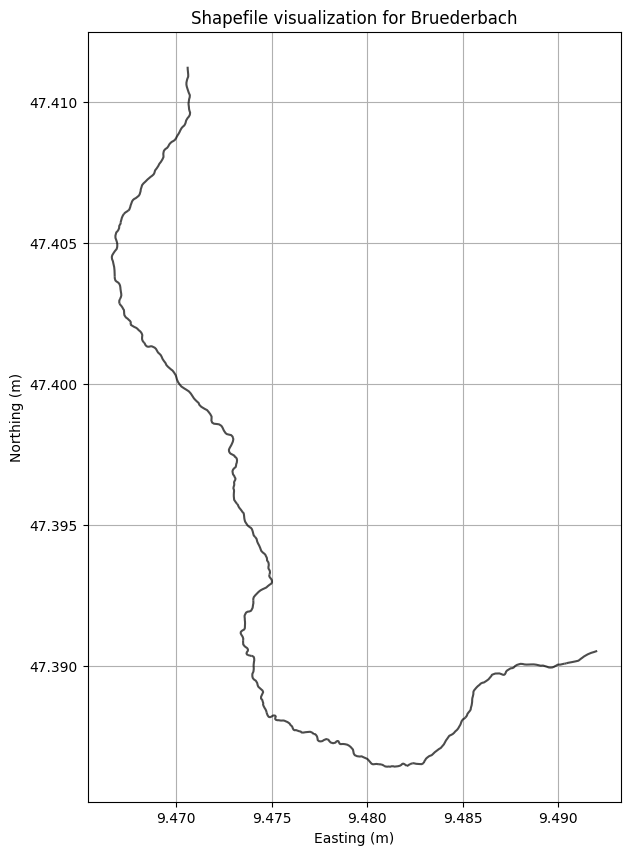

In [108]:
for k,r in rivers.items():
    fig, ax = plt.subplots(figsize=(10, 10))
    r.plot(ax=ax, edgecolor='k', alpha=0.7)
    ax.set_title(f'Shapefile visualization for {k}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.grid(True)
    plt.show()

### Fix shapefiles coordinates

0


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


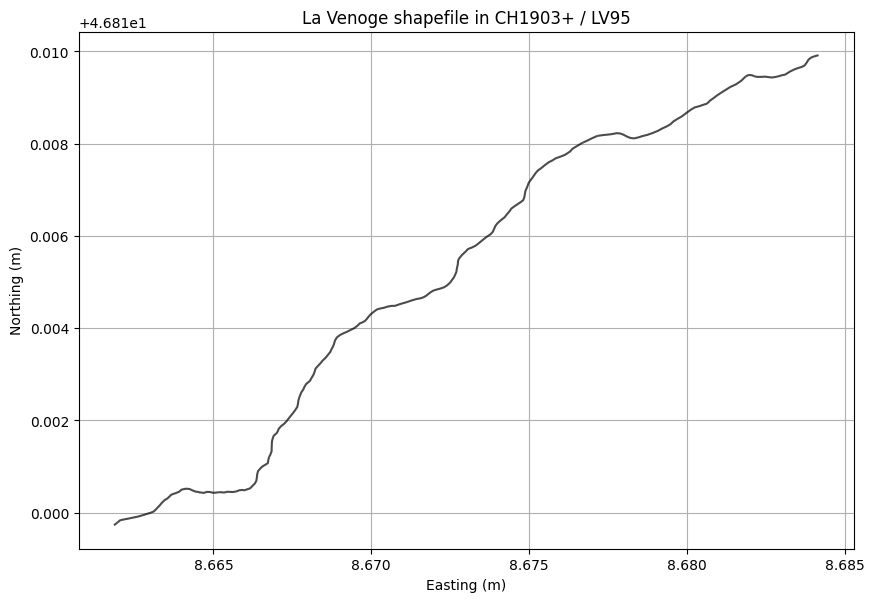

1


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


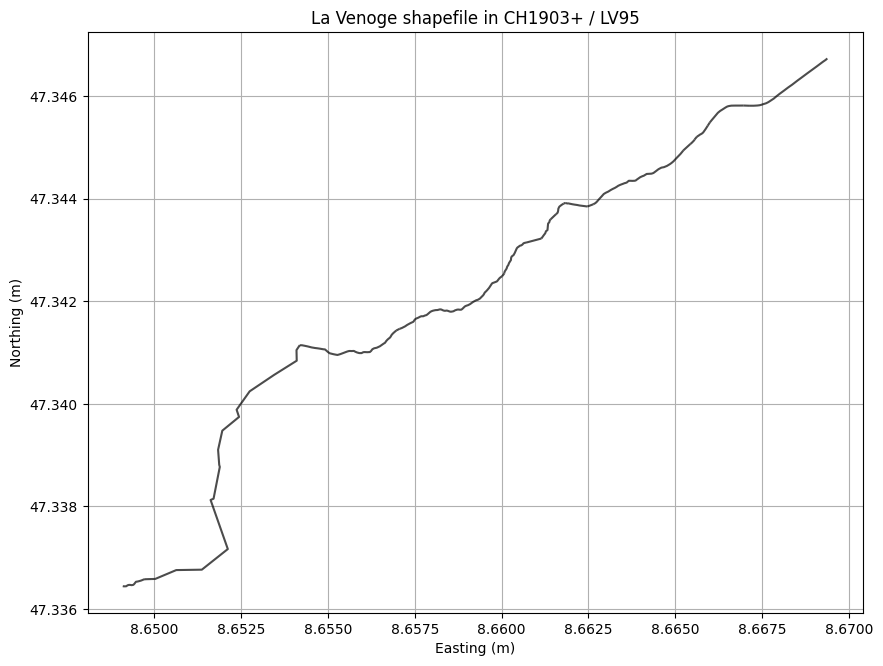

2


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


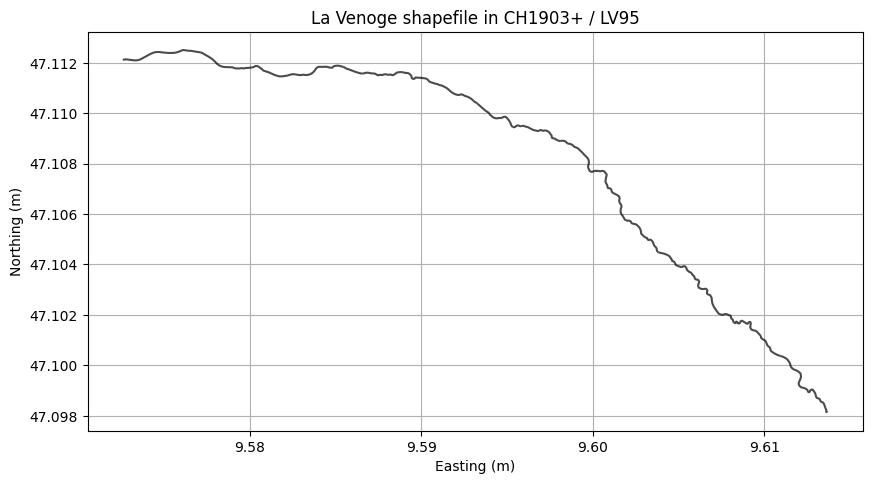

3


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


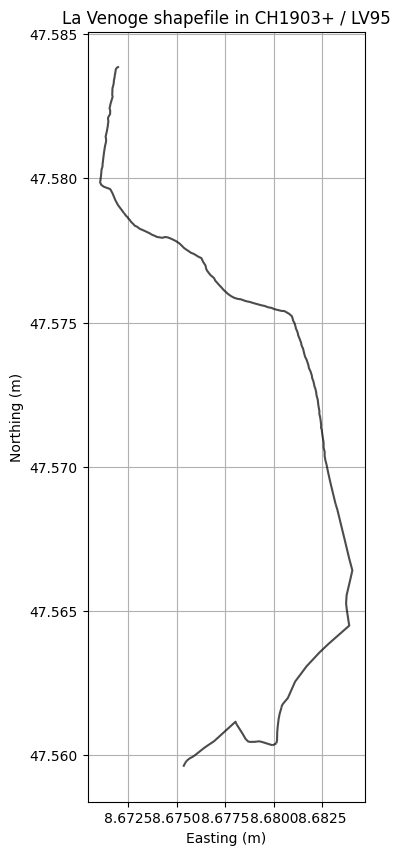

4


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


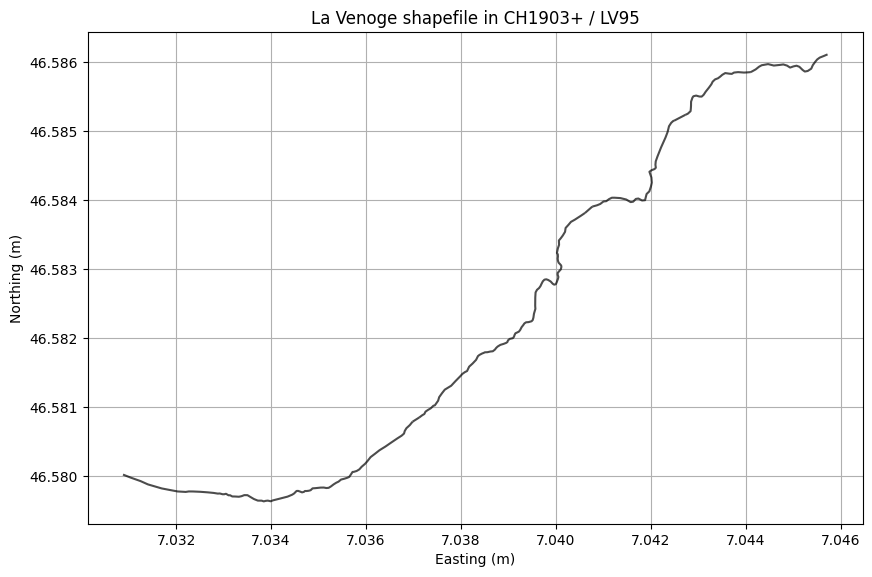

5


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


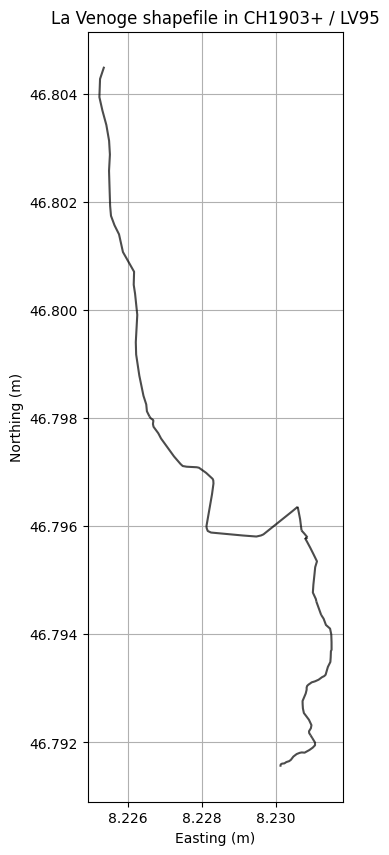

6


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


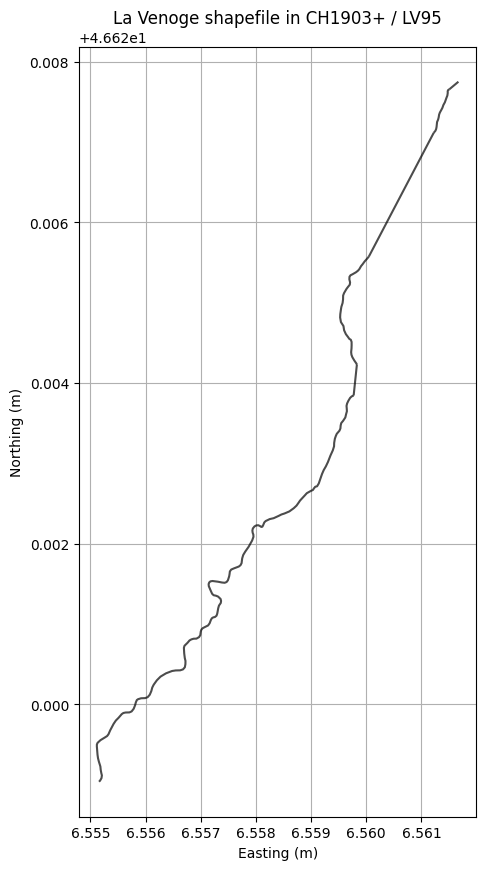

7


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


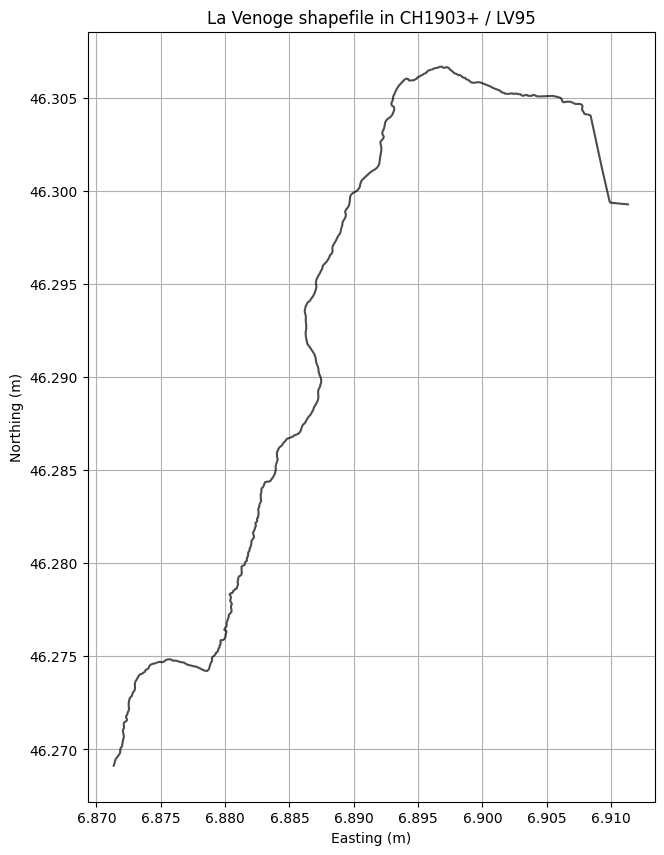

8


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


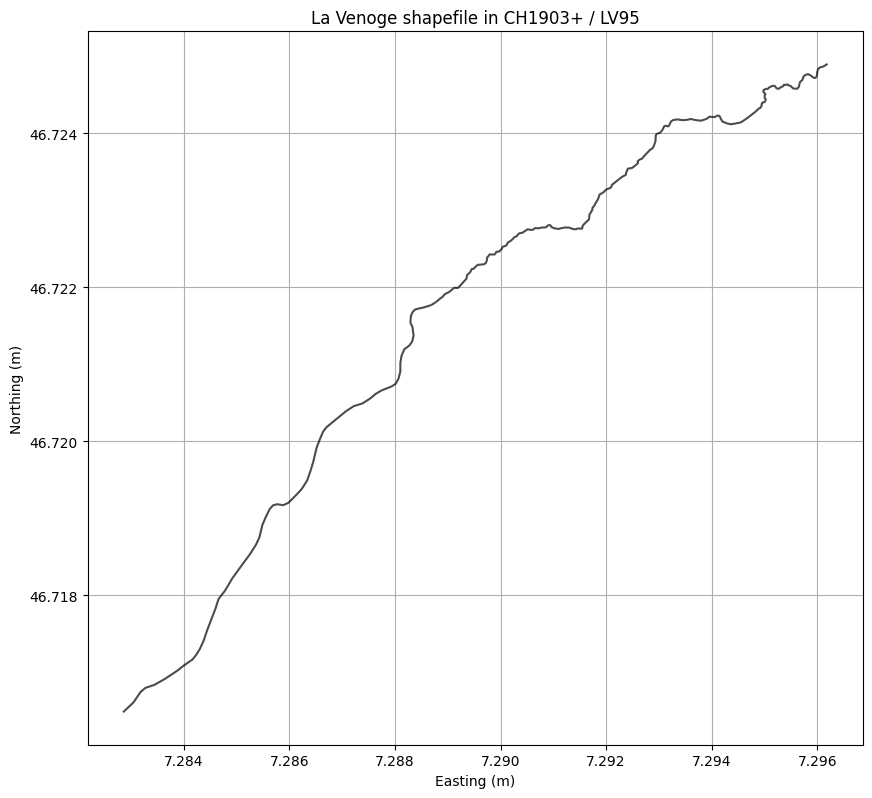

9


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


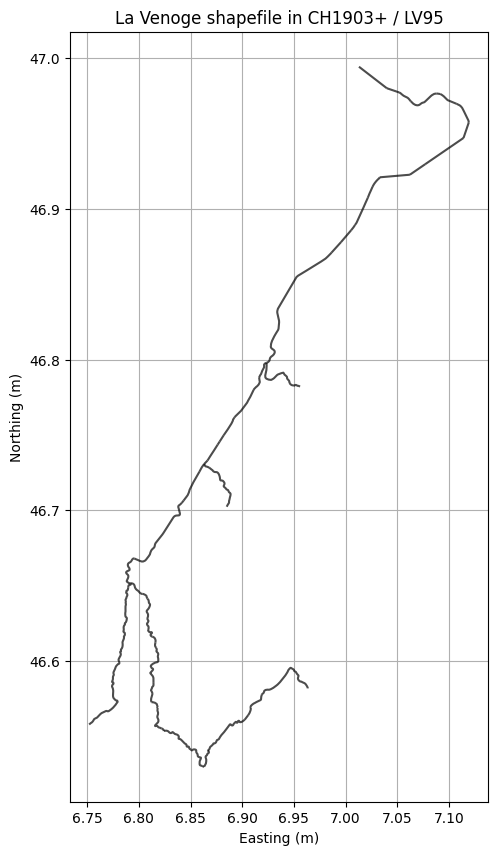

10


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


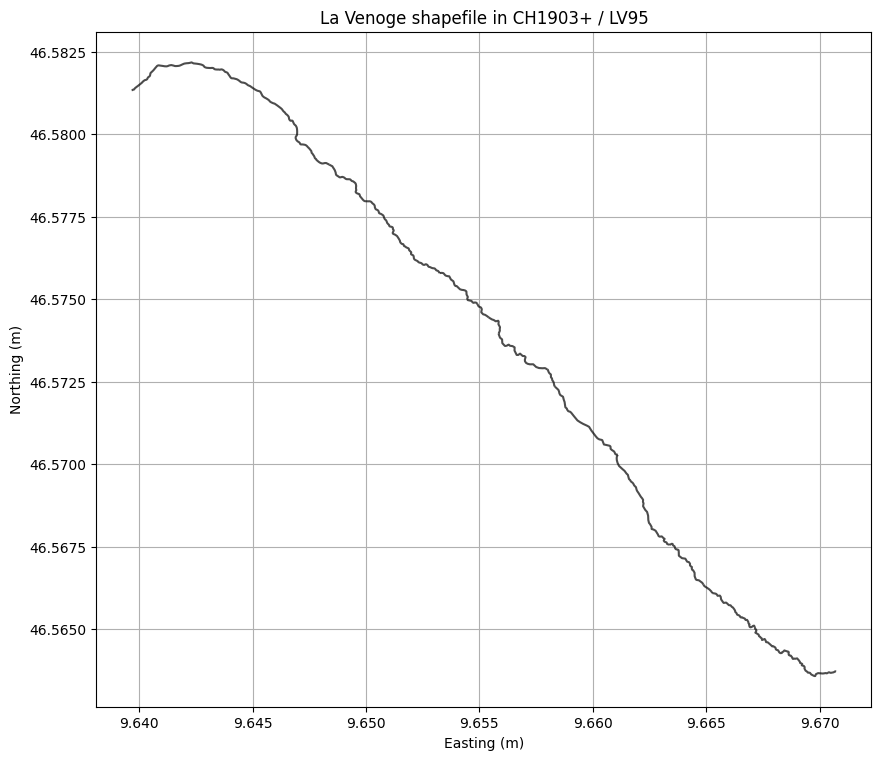

11


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


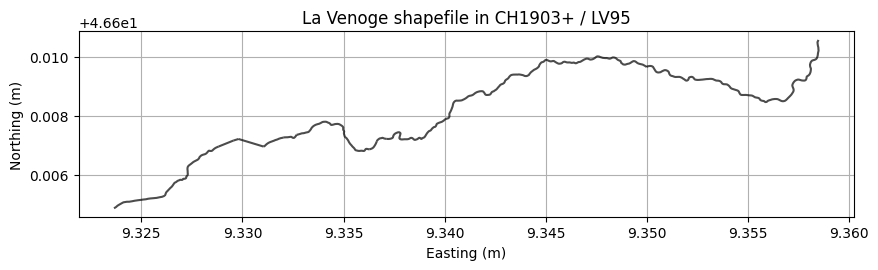

12


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


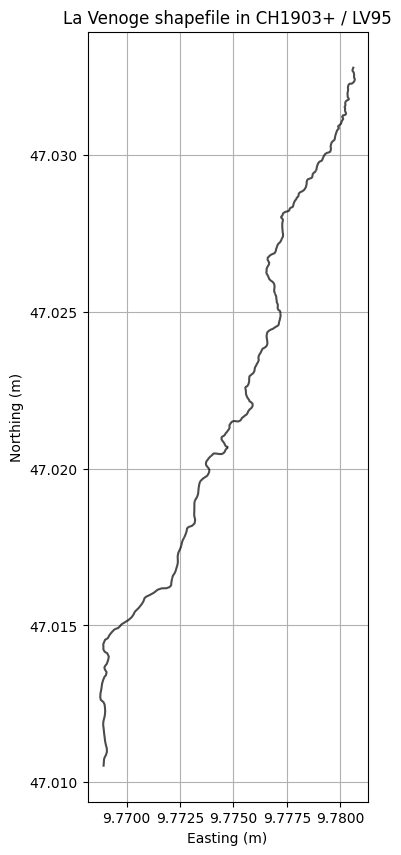

13


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


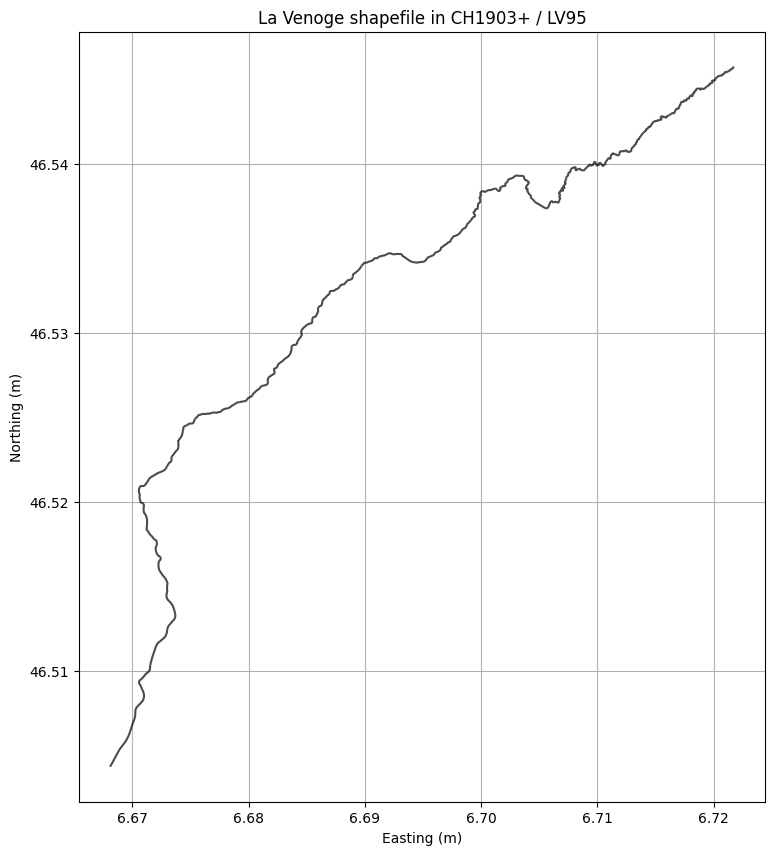

14


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


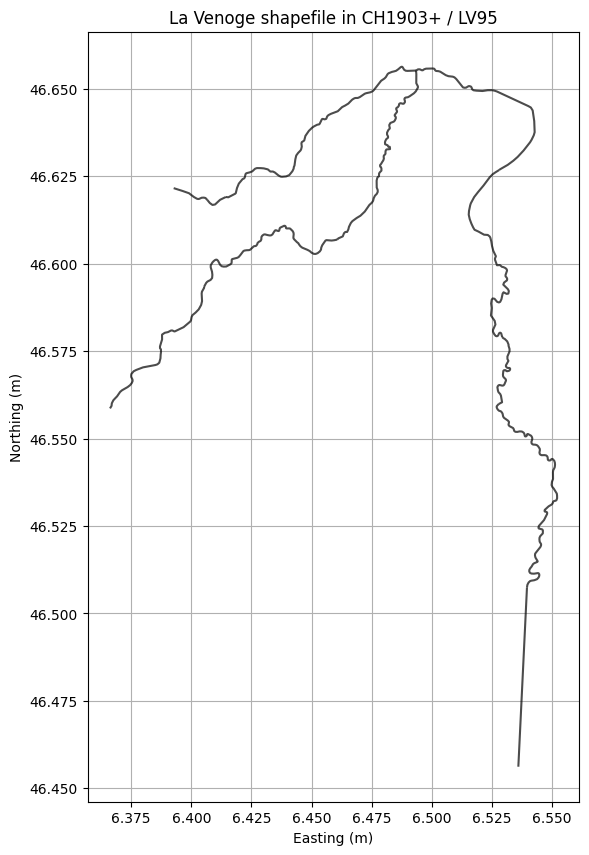

15


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


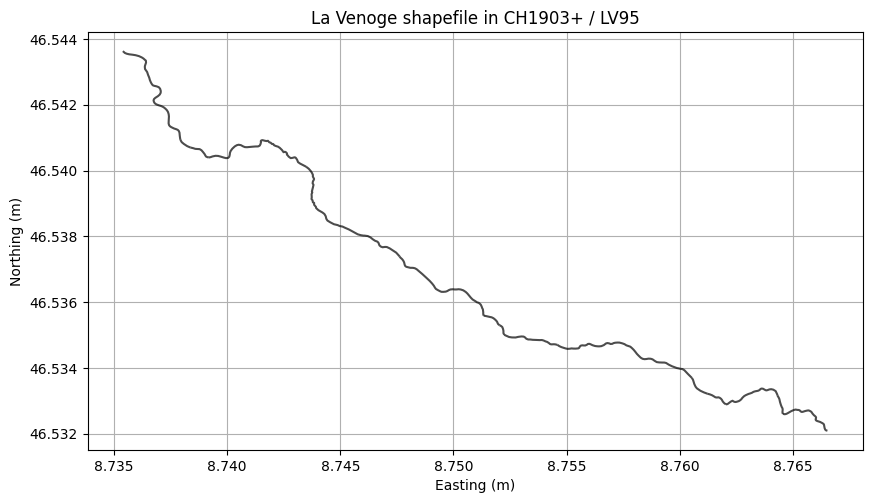

16


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


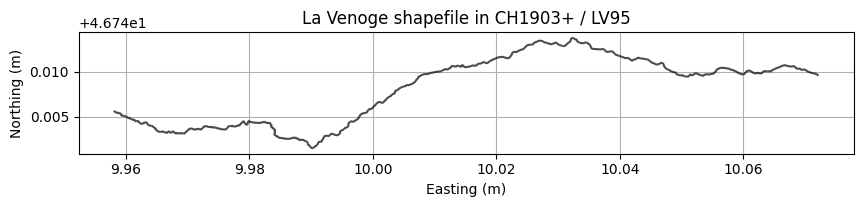

17


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


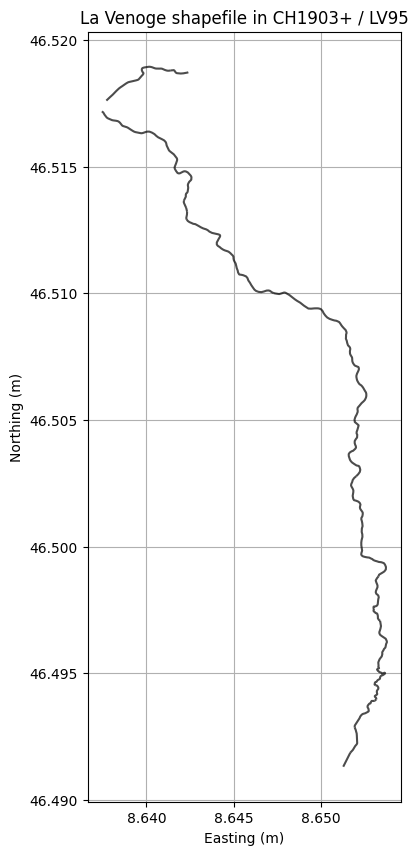

18


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


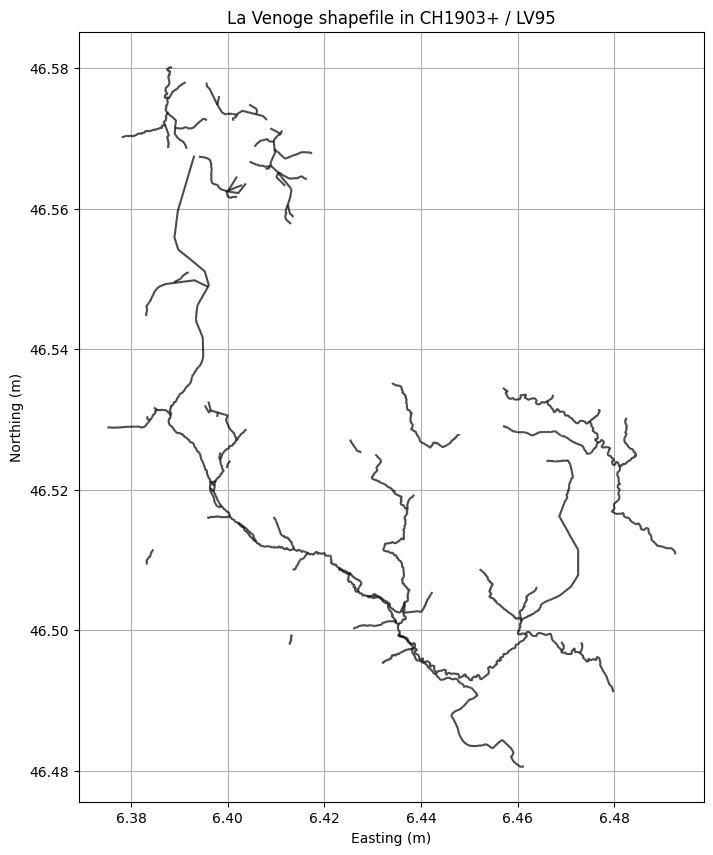

19


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


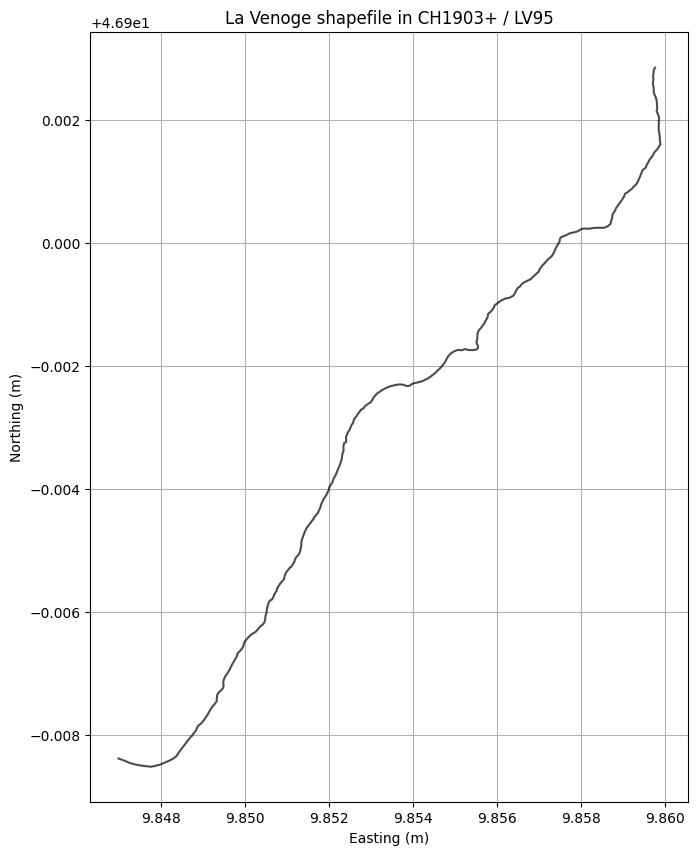

20


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


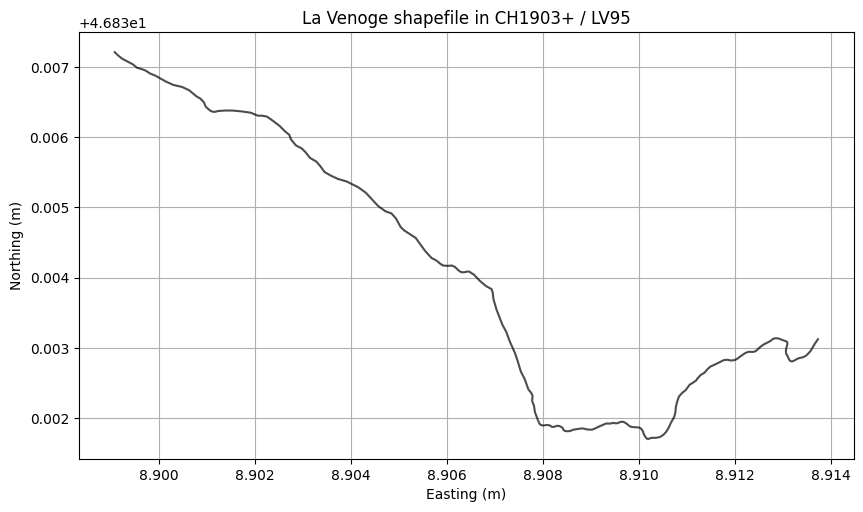

21


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


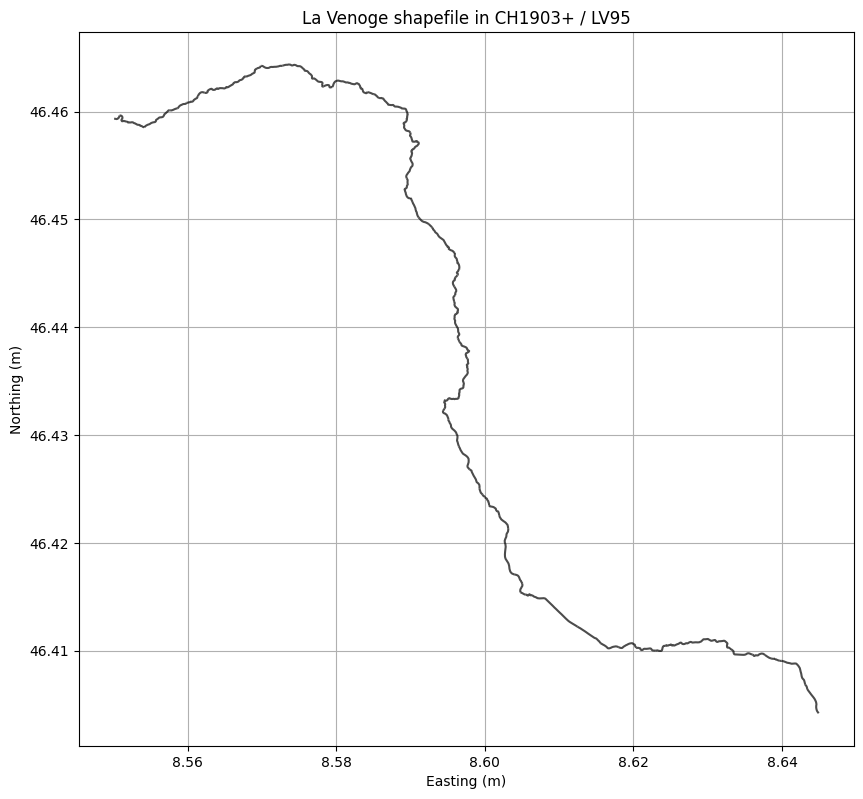

22


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


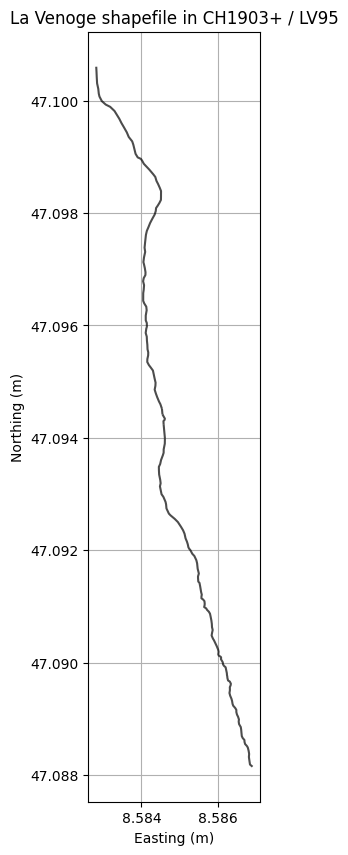

23


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


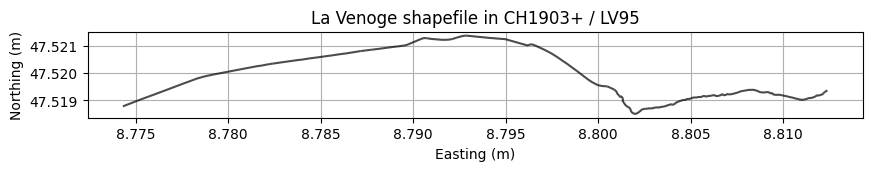

24


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


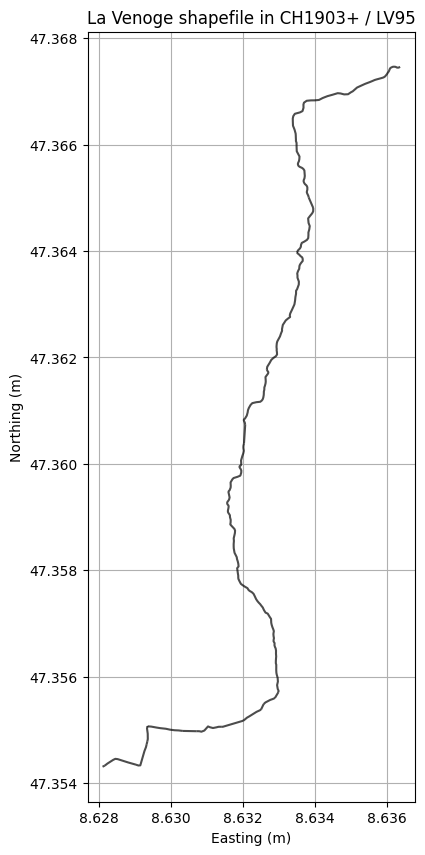

25


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


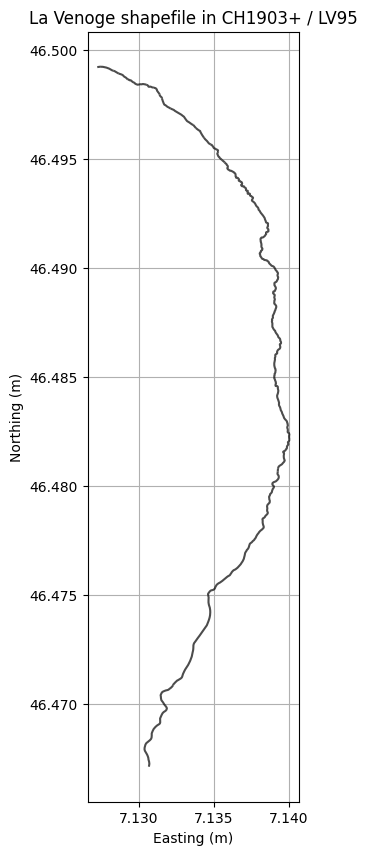

26


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


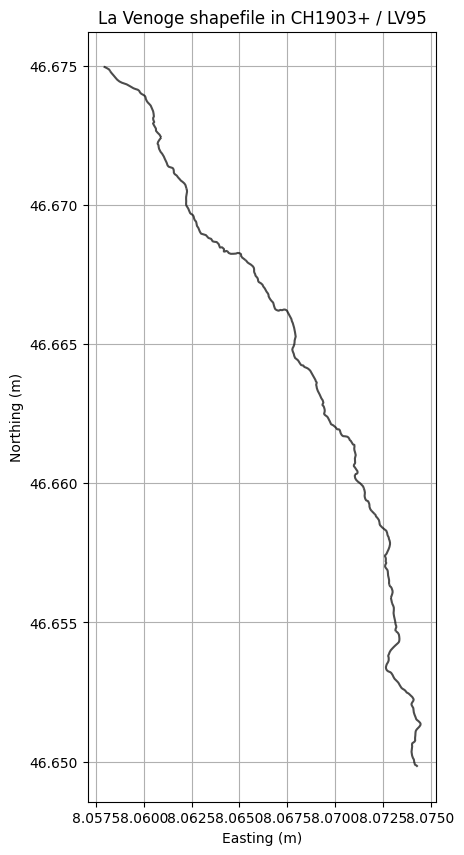

27


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


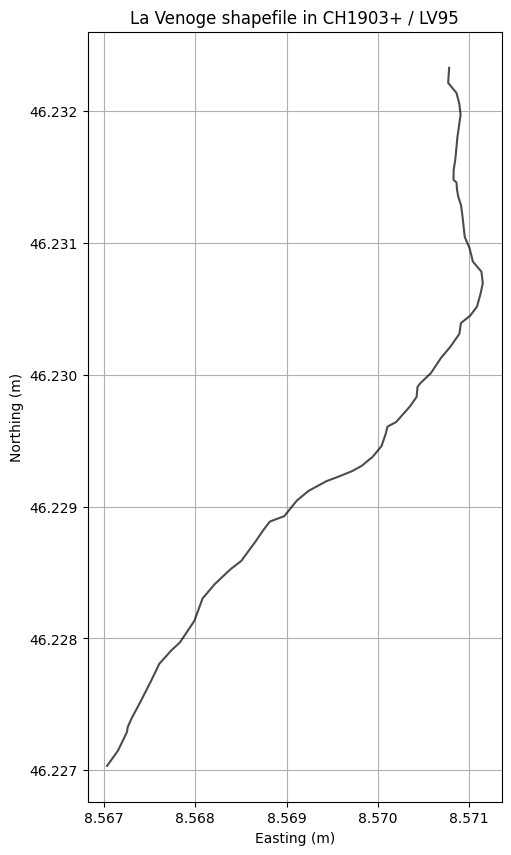

28


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


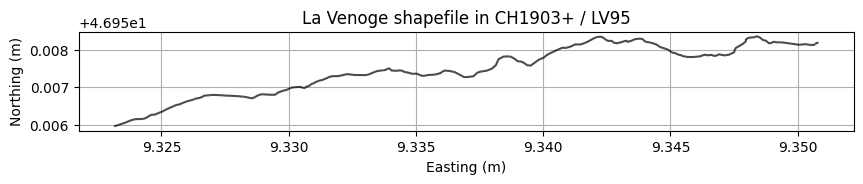

29


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


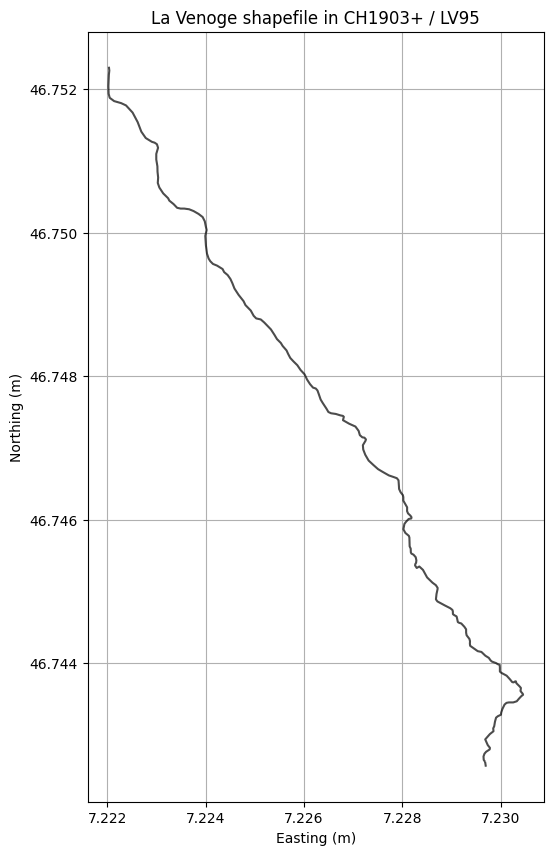

30


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


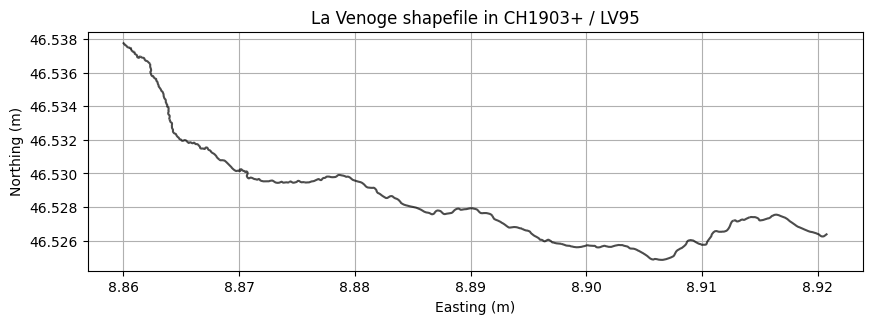

31


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


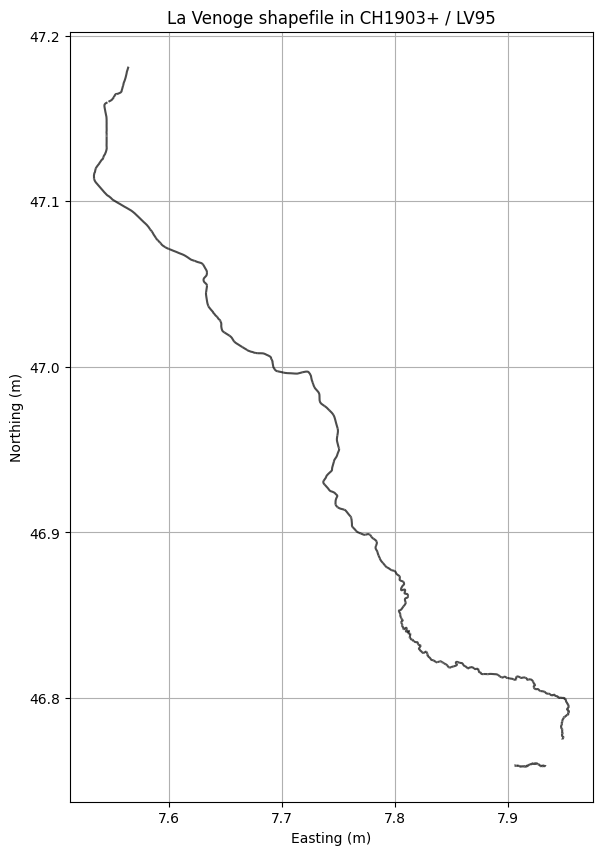

32


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


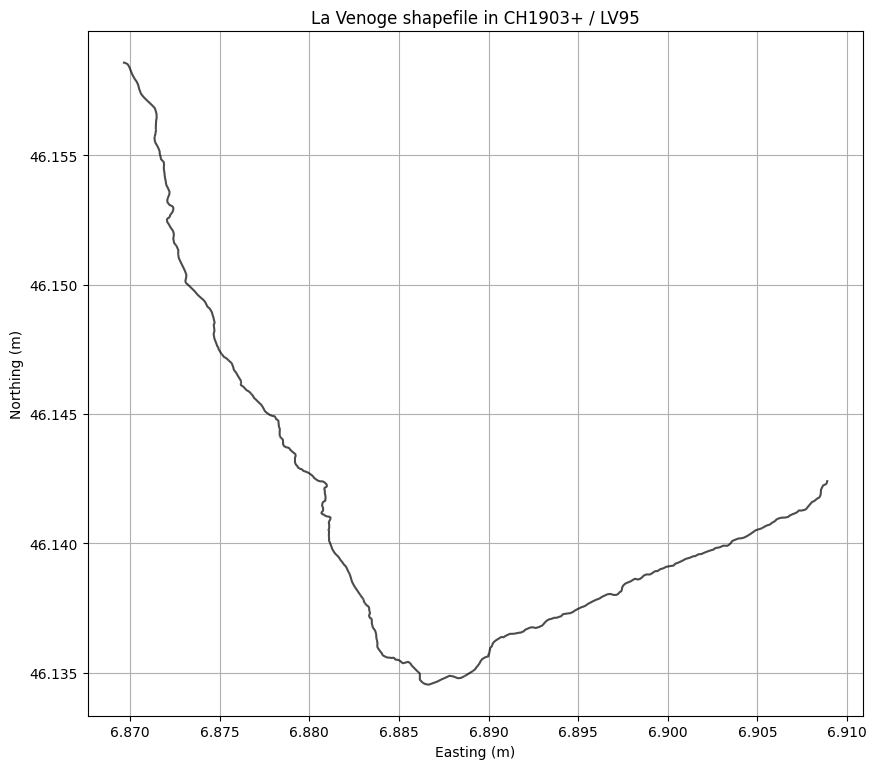

33


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


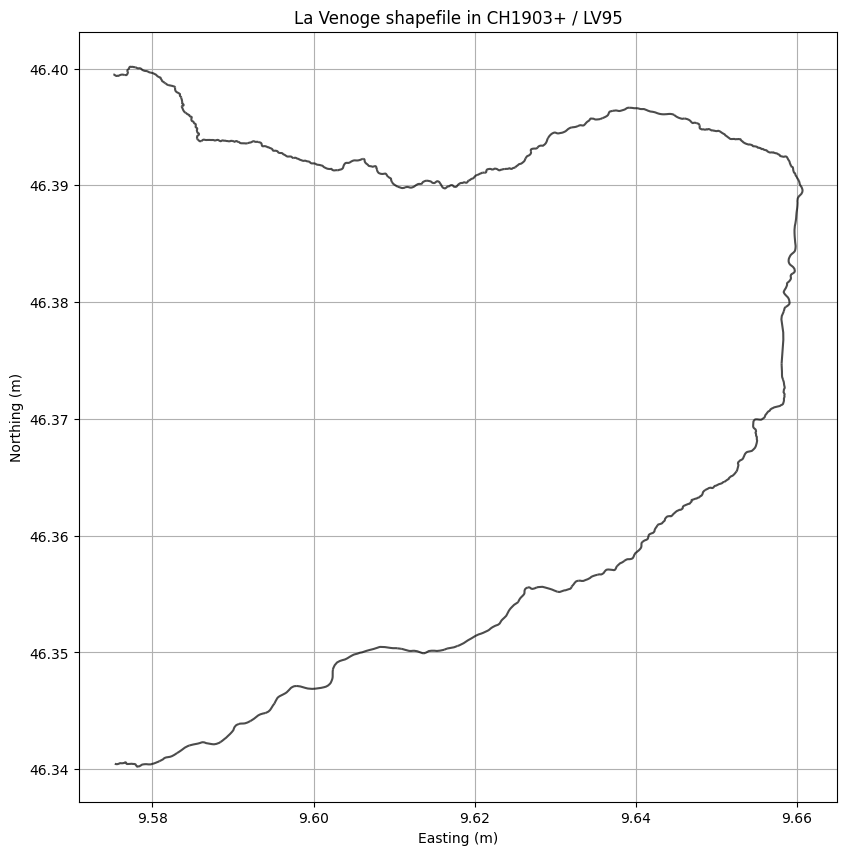

34


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


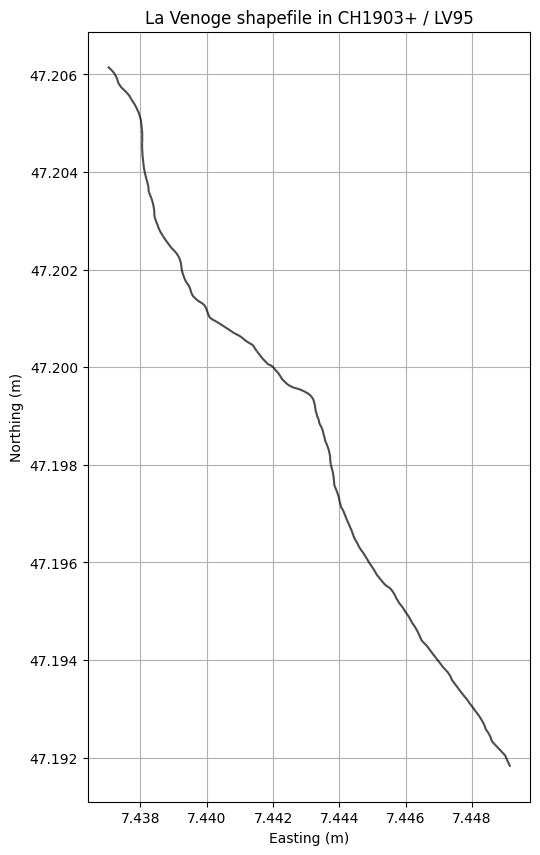

35


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


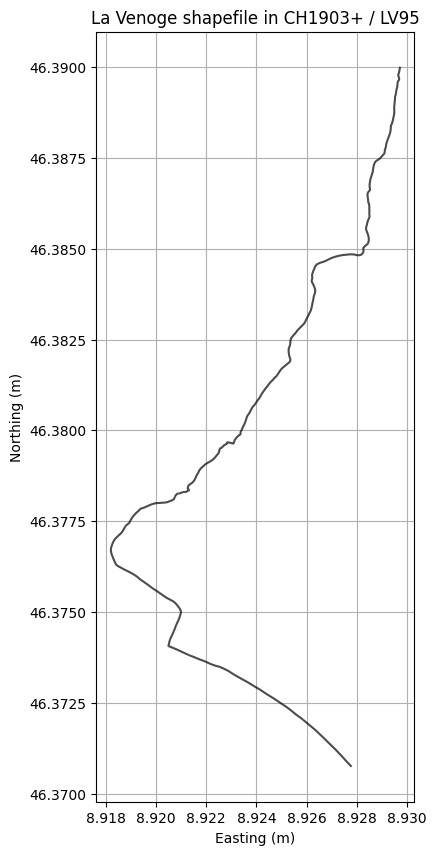

36


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


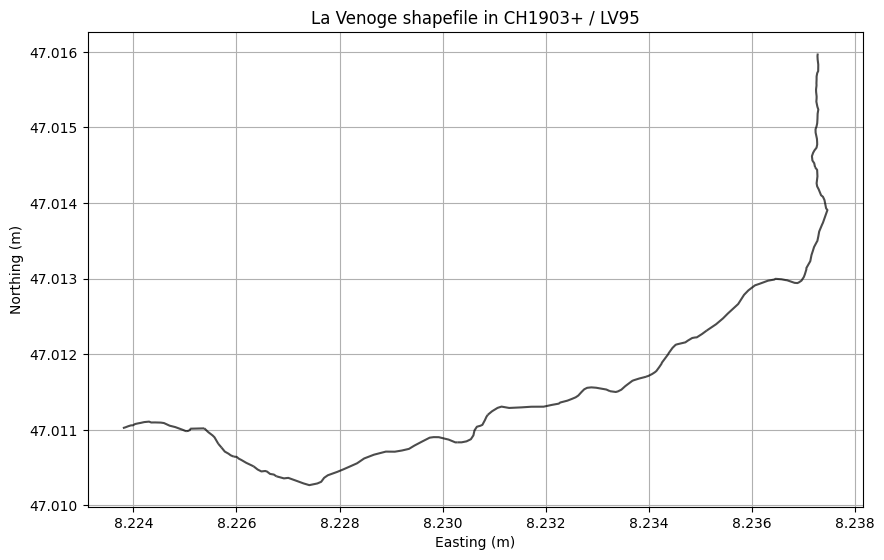

37


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


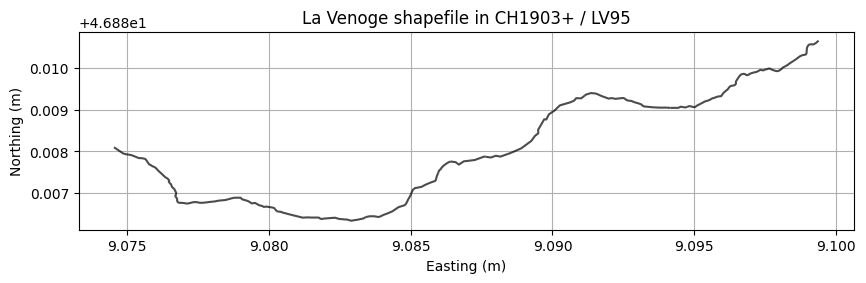

38


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


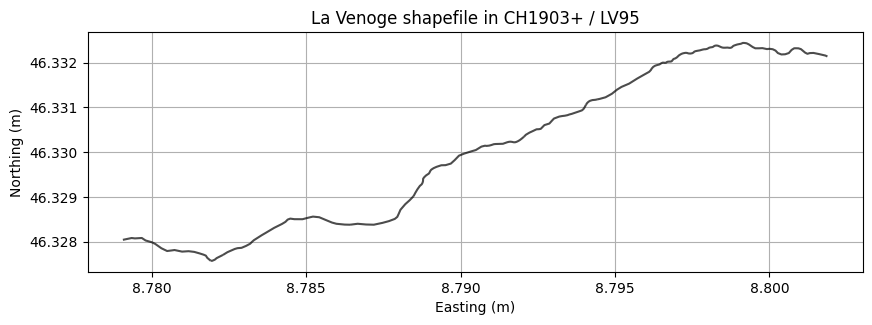

39


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


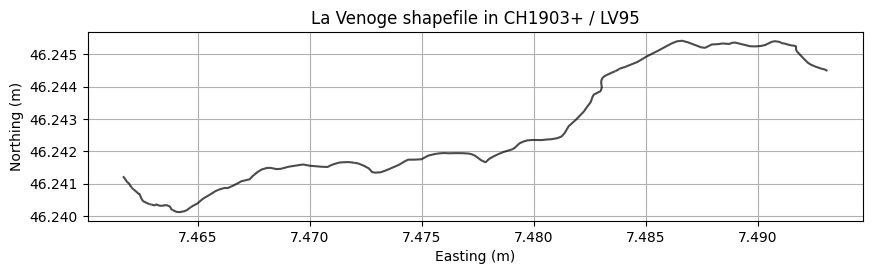

40


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


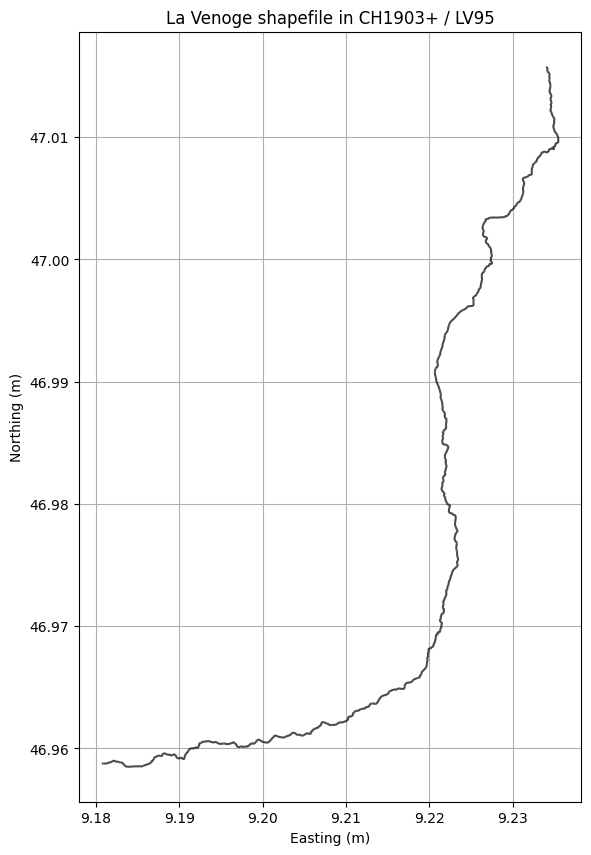

41


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


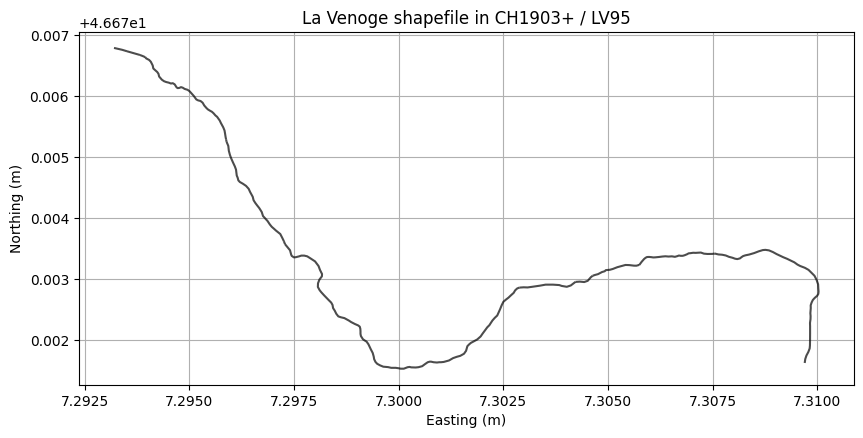

42


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


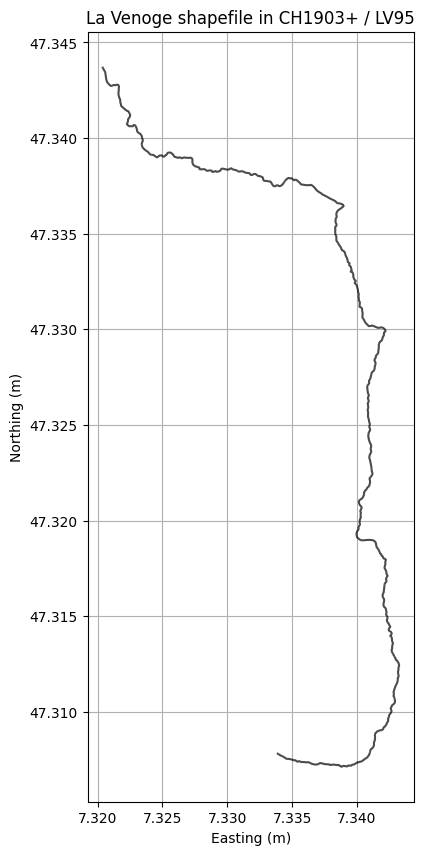

43


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


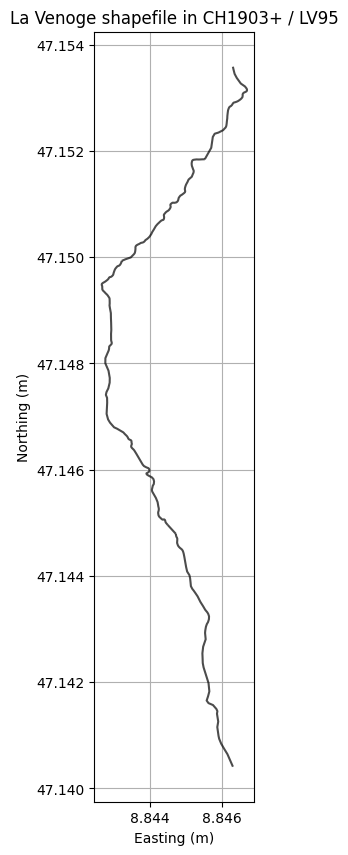

44


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


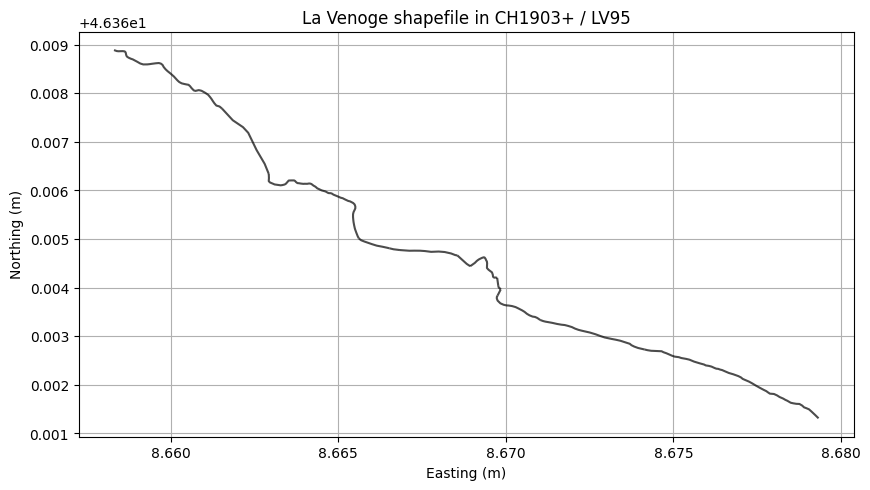

45


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


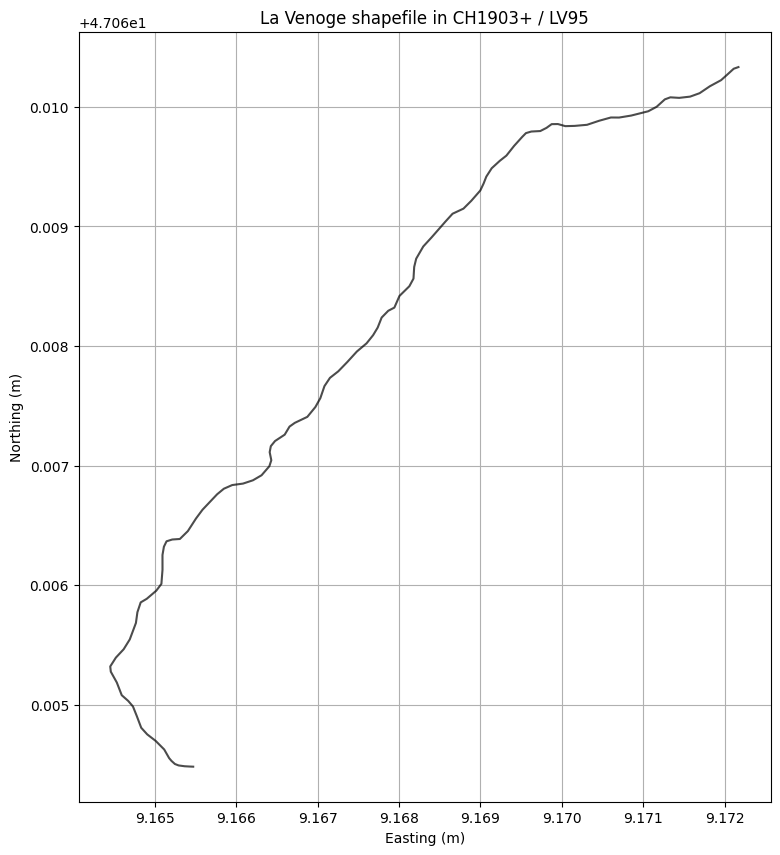

46


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


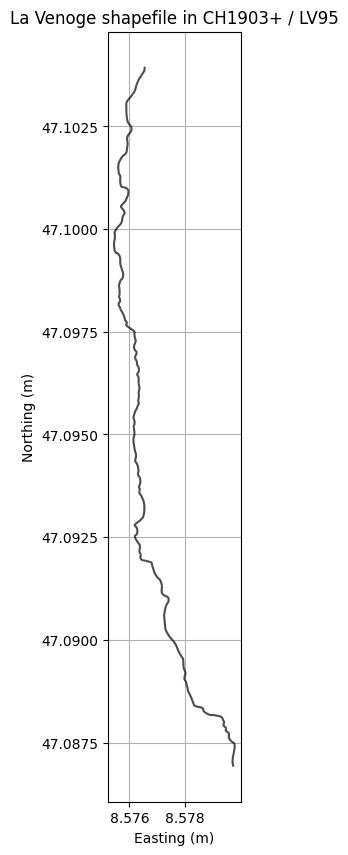

47


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


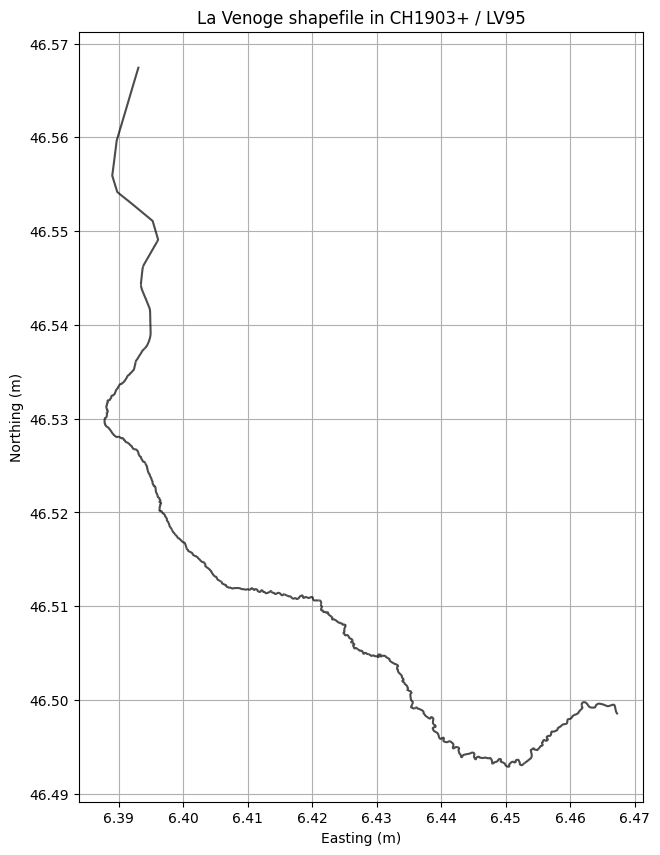

48


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


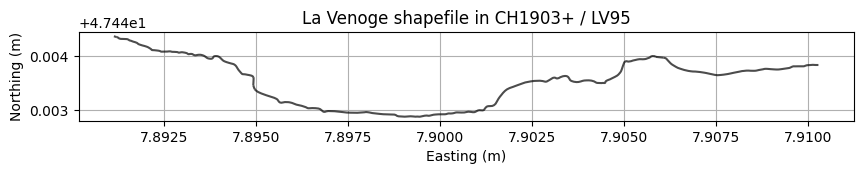

49


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


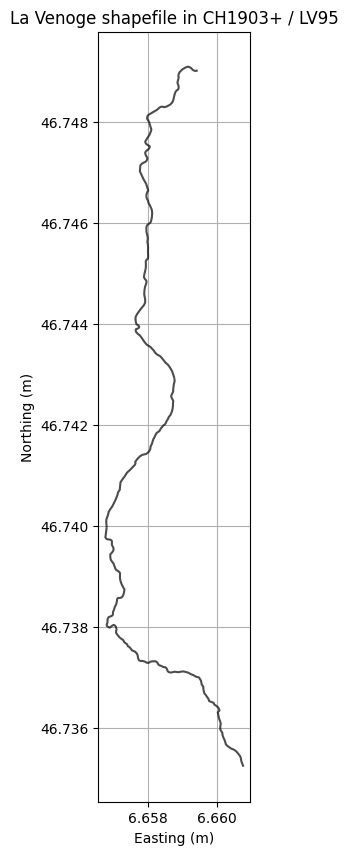

50


/tmp/ipykernel_2819715/2404292395.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid
/tmp/ipykernel_2819715/2404292395.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)


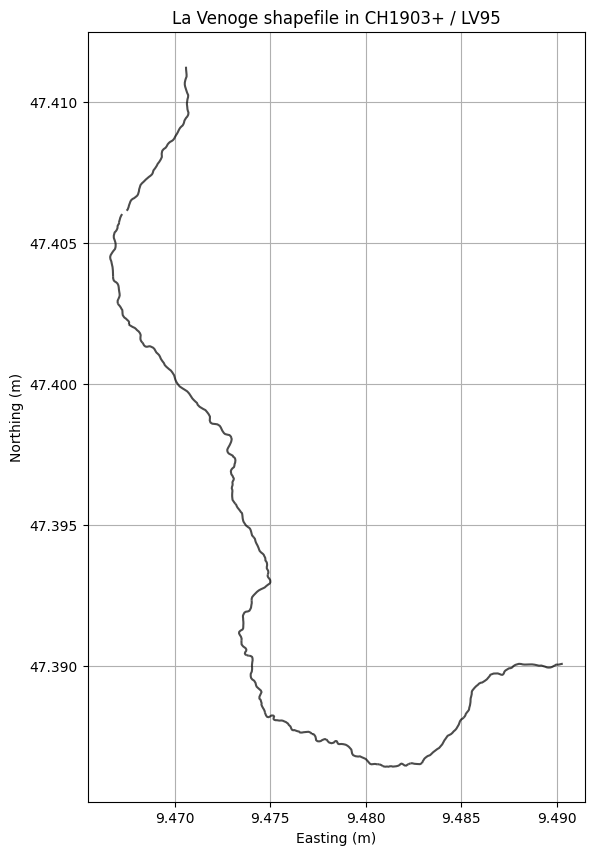

In [109]:
for ii,(k, r) in enumerate(rivers.items()):
    print(ii)
    # Load the shapefile
    gdf = r

    # Calculate the centroid of all LineStrings
    centroid = gdf.unary_union.centroid

    # Calculate the distance of each LineString to the centroid
    gdf['distance_to_centroid'] = gdf.geometry.distance(centroid)

    # Option 1: Remove LineStrings that are farther than the 90th percentile distance
    if k == 'LaBroye_shapefile':
        threshold_distance = gdf['distance_to_centroid'].quantile(0.99)
        gdf = gdf[gdf['distance_to_centroid'] <= threshold_distance]
    elif k != 'swissTLMboiron':#'LaVenoge_shapefile':
        threshold_distance = gdf['distance_to_centroid'].quantile(0.9)
    # Filter LineStrings closer to the centroid (within the threshold)
        gdf = gdf[gdf['distance_to_centroid'] <= threshold_distance]

    # Option 2: You can also set a manual threshold, e.g., 500 meters
    # filtered_gdf = gdf[gdf['distance_to_centroid'] <= 500]
    rivers[k] = gdf
    

    fig, ax = plt.subplots(figsize=(10, 10))
    rivers[k].plot(ax=ax, edgecolor='k', alpha=0.7)
    ax.set_title('La Venoge shapefile in CH1903+ / LV95')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.grid(True)
    plt.show()

## Obtain LST images

Load the water temperature database filtered by dates and regions.

In [88]:
gdf_points = gpd.read_file('../data/external/wt_filtered/wt_filtered.geojson')

In [89]:
gdf_points.describe()

time      longitude       latitude  waterTemperature
count               172044  172044.000000  172044.000000     172044.000000
mean   2015-07-16 05:33:20       8.208333      46.791667          7.913892
min    2011-01-31 00:00:00       5.791666      45.708332          0.100000
25%    2013-04-22 12:00:00       6.958334      46.208332          2.198152
50%    2015-07-15 12:00:00       8.208333      46.791668          6.564645
75%    2017-10-07 18:00:00       9.458333      47.375000         12.818750
max    2019-12-31 00:00:00      10.625000      47.875000         26.724939
std                    NaN       1.419120       0.649075          6.369109

In [90]:
unique_dates = gdf_points.time.dt.strftime('%Y-%m').unique()

In [91]:
unique_dates

array(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
       '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12',
       '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06',
       '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12',
       '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2013-10', '2013-11', '2013-12',
       '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', 

#### Evalscript and sentinelhub request

In [92]:
evalscript_lst = """
    //VERSION=3 (auto-converted from 1)
    //// STARTING OPTIONS
    // choose on basis of which band (B10 or B11) LST mapping will be done
    var band = "B10";

    // for analysis of one image (OE Browser), choose option=0. In case of MULTI-TEMPORAL analyis, option values are following:
    // 0 - outputs average LST in selected timeline (% of cloud coverage should be low, e.g. < 10%)
    // 1 - outputs maximum LST in selected timeline (% of cloud coverage can be high)
    // 2 - outputs standard deviation LST in selected timeline; minTemp and highTemp are overwritten with values 0 and 10 (% of cloud coverage should be low, e.g. < 5%)
    var option = 0;

    // minimum and maximum values for output colour chart red to white for temperature in °C. Option 2 overwrites this selection!
    var minC = 0;
    var maxC = 50;


    ////INPUT DATA - FOR BETTER RESULTS, THE DATA SHOULD BE ADJUSTED
    // NVDIs for bare soil and NDVIv for full vegetation
    // Note: NVDIs for bare soil and NDVIv for full vegetation are needed to be evaluated for every scene. However in the custom script, default values are set regarding:
    // https://profhorn.meteor.wisc.edu/wxwise/satmet/lesson3/ndvi.html
    // https://www.researchgate.net/post/Can_anyone_help_me_to_define_a_range_of_NDVI_value_to_extract_bare_soil_pixels_for_Landsat_TM
    // NVDIs=0.2, NDVIv=0.8
    // other source suggests global values: NVDIs=0.2, NDVIv=0.5; https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    var NDVIs = 0.2;
    var NDVIv = 0.8;

    // emissivity
    var waterE = 0.991;
    var soilE = 0.966;
    var vegetationE = 0.973;
    //var buildingE=0.962;
    var C = 0.009; //surface roughness, https://www.researchgate.net/publication/331047755_Land_Surface_Temperature_Retrieval_from_LANDSAT-8_Thermal_Infrared_Sensor_Data_and_Validation_with_Infrared_Thermometer_Camera

    //central/mean wavelength in meters, B10 or B11
    var bCent = (band == "B10") ? 0.000010895 : 0.000012005;

    // rho =h*c/sigma=PlanckC*velocityLight/BoltzmannC
    var rho = 0.01438; // m K

    //// visualization
    // if result should be std dev (option=2), overwrite minMaxC.
    if (option == 2) {
      minC = 0;
      maxC = 25;
    }
    let viz = ColorGradientVisualizer.createRedTemperature(minC, maxC);


    function setup() {
      return {
        input: [{
          bands: [
            "B03",
            "B04",
            "B05",
            "B10",
            "B11"
          ]
        }],
        mosaicking: "ORBIT",
        output: { bands: 3 }
      }
    }


    //emissivity calc
    //https://www.researchgate.net/publication/296414003_Algorithm_for_Automated_Mapping_of_Land_Surface_Temperature_Using_LANDSAT_8_Satellite_Data
    //https://www.academia.edu/27239873/Investigating_Land_Surface_Temperature_Changes_Using_Landsat_Data_in_Konya_Turkey
    function LSEcalc(NDVI, Pv) {
      var LSE;
      if (NDVI < 0) {
        //water
        LSE = waterE;
      } else if (NDVI < NDVIs) {
        //soil
        LSE = soilE;
      } else if (NDVI > NDVIv) {
        //vegetation
        LSE = vegetationE;
      } else {
        //mixtures of vegetation and soil
        LSE = vegetationE * Pv + soilE * (1 - Pv) + C;
      }
      return LSE;
    }

    function evaluatePixel(samples) {
      // starting values max, avg, stdev, reduce N, N for multi-temporal
      var LSTmax = -999;
      var LSTavg = 0;
      var LSTstd = 0;
      var reduceNavg = 0;
      var N = samples.length;

      //to caputure all values of one pixel for for whole timeline in mosaic order
      var LSTarray = [];

      // multi-temporal: loop all samples in selected timeline
      for (var i = 0; i < N; i++) {
        //// for LST
        // B10 or B11
        var Bi = (band == "B10") ? samples[i].B10 : samples[i].B11;
        var B03i = samples[i].B03;
        var B04i = samples[i].B04;
        var B05i = samples[i].B05;

        // some images have errors, whole area is either B10<173K or B10>65000K. Also errors, where B04 and B05 =0. Therefore no processing if that happens, in addition for average and stdev calc, N has to be reduced!
        if ((Bi > 173 && Bi < 65000) && (B03i > 0 && B04i > 0 && B05i > 0)) {
          // ok image
          //1 Kelvin to C
          var b10BTi = Bi - 273.15;
          //2 NDVI - Normalized Difference vegetation Index
          var NDVIi = (B05i - B04i) / (B05i + B04i);
          //3 PV - proportional vegetation
          var PVi = Math.pow(((NDVIi - NDVIs) / (NDVIv - NDVIs)), 2);
          //4 LSE land surface emmisivity
          var LSEi = LSEcalc(NDVIi, PVi);
          //5 LST
          var LSTi = (b10BTi / (1 + (((bCent * b10BTi) / rho) * Math.log(LSEi))));

          ////temporary calculation
          //avg
          LSTavg = LSTavg + LSTi;
          //max
          if (LSTi > LSTmax) { LSTmax = LSTi; }
          //array
          LSTarray.push(LSTi);
        } else {
          // image NOT ok
          ++reduceNavg;
        }
      }
      // correct N value if some images have errors and are not analysed
      N = N - reduceNavg;

      // calc final avg value
      LSTavg = LSTavg / N;

      // calc final stdev value
      for (var i = 0; i < LSTarray.length; i++) {
        LSTstd = LSTstd + (Math.pow(LSTarray[i] - LSTavg, 2));
      }
      LSTstd = (Math.pow(LSTstd / (LSTarray.length - 1), 0.5));

      // WHICH LST to output, it depends on option variable: 0 for one image analysis (OE Browser); MULTI-TEMPORAL: 0->avg; 1->max; 2->stdev
      let outLST = (option == 0)
        ? LSTavg
        : (option == 1)
          ? LSTmax
          : LSTstd;

      //// output to image
      return viz.process(outLST);
    }
"""

In [93]:
slots = []

for date in unique_dates:
  year = int(date.split('-')[0])
  month = int(date.split('-')[1])
  fd = first_day(month, year)
  ld = last_day(fd)
  slots.append( (fd.isoformat(), ld.isoformat()) )

slots

[('2011-01-01', '2011-01-31'),
 ('2011-02-01', '2011-02-28'),
 ('2011-03-01', '2011-03-31'),
 ('2011-04-01', '2011-04-30'),
 ('2011-05-01', '2011-05-31'),
 ('2011-06-01', '2011-06-30'),
 ('2011-07-01', '2011-07-31'),
 ('2011-08-01', '2011-08-31'),
 ('2011-09-01', '2011-09-30'),
 ('2011-10-01', '2011-10-31'),
 ('2011-11-01', '2011-11-30'),
 ('2011-12-01', '2011-12-31'),
 ('2012-01-01', '2012-01-31'),
 ('2012-02-01', '2012-02-29'),
 ('2012-03-01', '2012-03-31'),
 ('2012-04-01', '2012-04-30'),
 ('2012-05-01', '2012-05-31'),
 ('2012-06-01', '2012-06-30'),
 ('2012-07-01', '2012-07-31'),
 ('2012-08-01', '2012-08-31'),
 ('2012-09-01', '2012-09-30'),
 ('2012-10-01', '2012-10-31'),
 ('2012-11-01', '2012-11-30'),
 ('2012-12-01', '2012-12-31'),
 ('2013-01-01', '2013-01-31'),
 ('2013-02-01', '2013-02-28'),
 ('2013-03-01', '2013-03-31'),
 ('2013-04-01', '2013-04-30'),
 ('2013-05-01', '2013-05-31'),
 ('2013-06-01', '2013-06-30'),
 ('2013-07-01', '2013-07-31'),
 ('2013-08-01', '2013-08-31'),
 ('2013-

### Download the data

Clean directories

In [94]:
raw_data_path = '../data/raw/lst'

os.makedirs(raw_data_path, exist_ok=True)
clear_directory(raw_data_path)

for r in rivers.keys():
  dest_dir = os.path.join(raw_data_path, r)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)

In [110]:
for ii,(k, river) in enumerate(rivers.items()):
    print(f'Doing river {ii}:', k)    
    destination_folder = f'../data/raw/lst/{k}'
    get_data(river, evalscript_lst, slots, 'lst', destination_folder)
    
    # Inicializa un contador para renombrar las imágenes
    counter = 0

    # Recorre todas las subcarpetas en la carpeta principal
    for subdir, dirs, files in os.walk(destination_folder):
        for file in files:
            # Si el archivo es un .tiff
            if file.endswith('.tiff'):
                # Construye la ruta completa del archivo tiff
                tiff_file_path = os.path.join(subdir, file)

                # Define el nuevo nombre del archivo
                new_file_name = f'image_{slots[counter][0][:7]}.tiff'
                new_file_path = os.path.join(destination_folder, new_file_name)

                # Mueve el archivo al nuevo directorio con el nuevo nombre
                shutil.move(tiff_file_path, new_file_path)
                
                # Incrementa el contador
                counter += 1
    

    for subdir, dirs, files in os.walk(destination_folder):
        for dir in dirs:
            dir_path = os.path.join(subdir, dir)
            shutil.rmtree(dir_path, ignore_errors=True)



Doing river 0: Plattenbach
Doing river 1: Rausenbach
Doing river 2: Malbunbach
Doing river 3: Seltenbach
Doing river 4: Ruisseau_des_Frassy
Doing river 5: Rotenbachli
Doing river 6: Ruisseau_de_Pra_Gouma
Doing river 7: Torrent_de_Greffe
Doing river 8: Guuhetbach
Doing river 11: Raptgusa
Doing river 12: Alplibach
Doing river 13: La_Paudeze
Doing river 14: LaVenoge_shapefile
Doing river 15: Ri_dei_Calcestri
Doing river 16: Susasca
Doing river 17: Calcascia
Doing river 18: swissTLMboiron
Doing river 19: Tschagibach
Doing river 20: Spitzalpelibach
Doing river 21: Fiume_Peccia
Doing river 22: Wasserfallenbach
Doing river 23: Wiesenbach
Doing river 24: Jorenbach
Doing river 25: Ruisseau_de_la_Leyvra
Doing river 26: Usser_Bargelbach
Doing river 27: I_Custiell
Doing river 28: Guetentalbach
Doing river 29: Eibachli
Doing river 30: Ri_di_Piera
Doing river 31: Emme


/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-package

Doing river 32: La_Saufla
Doing river 33: Maira_|_Mera
Doing river 34: Haagbach
Doing river 35: Riale_della_Fontana
Doing river 36: Stossbach
Doing river 37: Leiterbergbach
Doing river 38: Riale_di_Motom
Doing river 39: Bisse-Neuf
Doing river 40: Chrauchbach
Doing river 41: Kasperabach
Doing river 42: Ruisseau_de_Chatillon
Doing river 43: Zauggenbach
Doing river 44: El_Ri_Vall_Mala
Doing river 45: Tschermanner_Bach
Doing river 46: Schusselbach
Doing river 47: le_boiron2
Doing river 48: Aletenbach
Doing river 49: Ruisseau_du_Perelet
Doing river 50: Bruederbach


## Obtain WT images

Divide quadrants and link them to its closest point in the database. If there is a point in the quadrant, return it. Else, calculate the closest point with euclidian distance

In [111]:
closest = {}
for ii,(k, river) in enumerate(rivers.items()):
    print('Doing',ii)
    # Define el bbox del cuadrado
    #bbox = [lat_min, lon_min, lat_max, lon_max]
    lon_min, lat_min, lon_max, lat_max = river.total_bounds

    # Calcula el centro de cada cuadrante
    lat_mid = (lat_min + lat_max) / 2
    lon_mid = (lon_min + lon_max) / 2

    # Definir los cuadrantes como cajas de límites (bounding boxes)
    quadrants = {
        'upper_left': [lat_mid, lon_min, lat_max, lon_mid],  # lat_max y lon_mid
        'upper_right': [lat_mid, lon_mid, lat_max, lon_max],  # lat_max y lon_max
        'lower_left': [lat_min, lon_min, lat_mid, lon_mid],  # lat_min y lon_mid
        'lower_right': [lat_min, lon_mid, lat_mid, lon_max]  # lat_min y lon_max
    }

    # Crear un mapa centrado en el área de interés
    m = folium.Map(location=[(lat_min + lat_max) / 2, (lon_min + lon_max) / 2], zoom_start=13)

    # Dibujar el bounding box (cuadrado principal)
    bounding_box = box(lon_min, lat_min, lon_max, lat_max)
    gdf_bbox = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")

    # Dibujar los cuadrantes y encontrar puntos más cercanos
    closest_points = {}
    for quadrant_name, quadrant_bbox in quadrants.items():
        # Dibujar cada cuadrante
        quadrant_box = box(quadrant_bbox[1], quadrant_bbox[0], quadrant_bbox[3], quadrant_bbox[2])
        gdf_quadrant = gpd.GeoDataFrame(geometry=[quadrant_box], crs="EPSG:4326")
        folium.GeoJson(gdf_quadrant.geometry.iloc[0], style_function=lambda x: {
            'fillColor': '#ffff00', 'color': '#ff0000', 'weight': 2
        }).add_to(m)

        # Encontrar el punto más cercano para cada cuadrante
        closest_point = find_closest_point(gdf_points, quadrant_bbox)
        closest_points[quadrant_name] = closest_point
        unique_closest_point = closest_points[quadrant_name].drop_duplicates(subset='geometry')
        # Agregar el punto más cercano al mapa
        folium.Marker(
            location=[unique_closest_point.iloc[0].geometry.y, unique_closest_point.iloc[0].geometry.x],
            popup=f"Closest Point to {quadrant_name}, Temp: {unique_closest_point['waterTemperature']}°C",
            icon=folium.Icon(color="blue")
        ).add_to(m)

        quadrant_center = Point(
            (quadrant_bbox[1] + quadrant_bbox[3]) / 2,
            (quadrant_bbox[0] + quadrant_bbox[2]) / 2
        )

        folium.PolyLine(
            locations=[
                [unique_closest_point.iloc[0].geometry.y, unique_closest_point.iloc[0].geometry.x],
                [quadrant_center.y, quadrant_center.x]
            ],
            color='green',
            weight=2,
            opacity=0.8
        ).add_to(m)

    closest[k] = closest_points
    
    unique_points = gdf_points.drop_duplicates(subset='geometry')

    for _, row in unique_points.iterrows():
        temperatura = row['waterTemperature']  # Asumiendo que 'temperatura' está en el DataFrame
        color = 'red' if temperatura > 20 else 'blue'  # Colorear basado en temperatura
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=f'Temperatura: {temperatura}°C'
        ).add_to(m)



    # Mostrar el mapa
    map_path = f"../maps/quadrants_with_closest_points_{k}.html"
    m.save(map_path)
    

Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
Doing 15
Doing 16
Doing 17
Doing 18
Doing 19
Doing 20
Doing 21
Doing 22
Doing 23
Doing 24
Doing 25
Doing 26
Doing 27
Doing 28
Doing 29
Doing 30
Doing 31
Doing 32
Doing 33
Doing 34
Doing 35
Doing 36
Doing 37
Doing 38
Doing 39
Doing 40
Doing 41
Doing 42
Doing 43
Doing 44
Doing 45
Doing 46
Doing 47
Doing 48
Doing 49
Doing 50


#### River masks
1. Create a 30m resolution grid from the AOI
2. Assign river values to the grid
3. Binarize the image for masking

Bounds for Plattenbach: [2693359.69564499 1185012.52711327 2695045.59064577 1186172.46111286]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Plattenbach


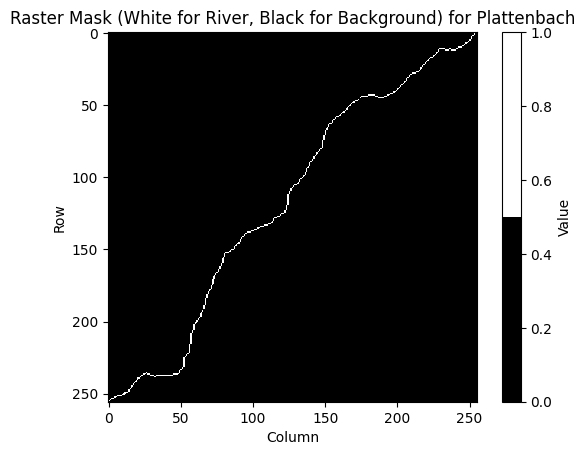

352
Bounds for Rausenbach: [2691483.14062548 1243547.15213467 2692997.80962635 1244715.65713466]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Rausenbach


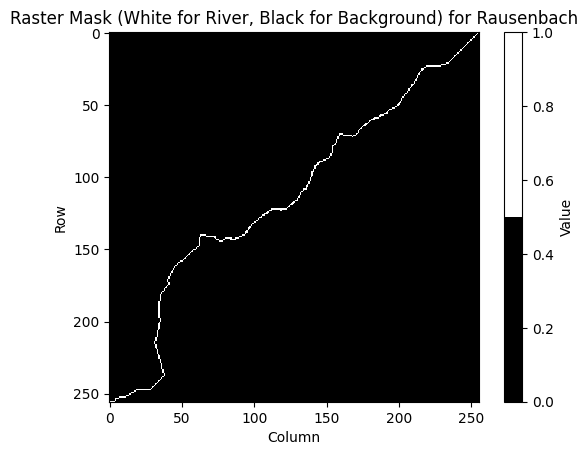

390
Bounds for Malbunbach: [2761944.84068658 1218634.81210207 2765102.48468933 1220154.41410366]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Malbunbach


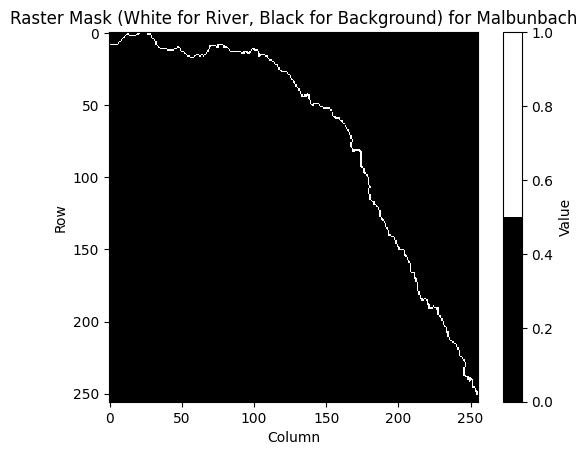

453
Bounds for Seltenbach: [2692719.03961791 1268387.13414177 2693717.86461915 1271081.58814265]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Seltenbach


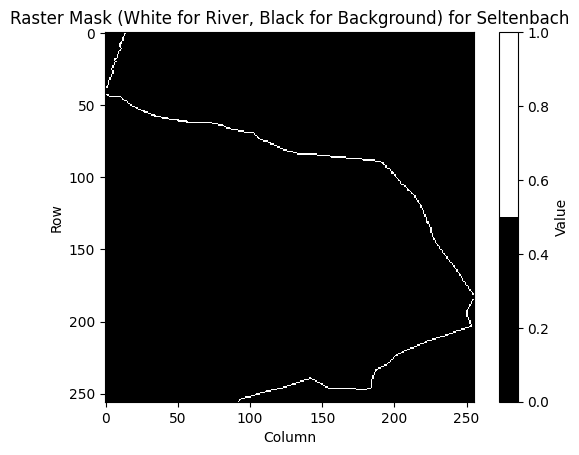

533
Bounds for Ruisseau_des_Frassy: [2568744.71154435 1158787.5731354  2569885.79754529 1159502.38513559]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ruisseau_des_Frassy


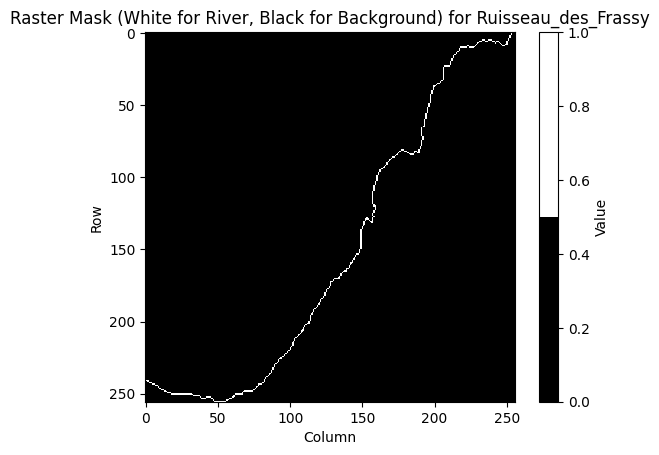

402
Bounds for Rotenbachli: [2660042.99561774 1182569.11412151 2660533.42461836 1184005.0771224 ]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Rotenbachli


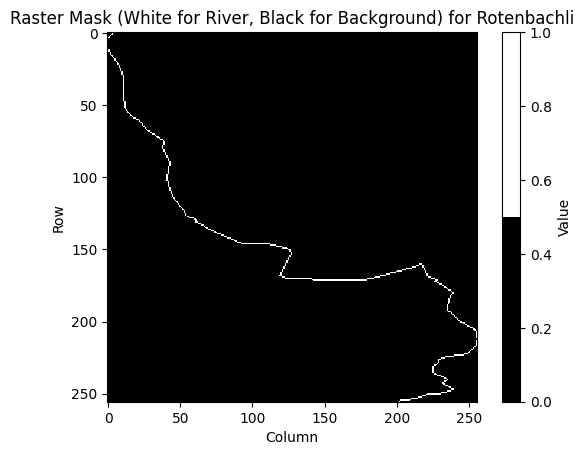

488
Bounds for Ruisseau_de_Pra_Gouma: [2532327.12550974 1163469.32214623 2532839.31351    1164432.25914654]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ruisseau_de_Pra_Gouma


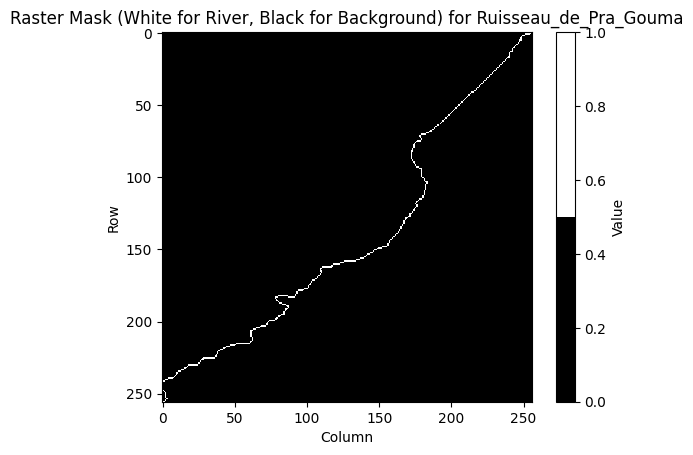

390
Bounds for Torrent_de_Greffe: [2556264.03554082 1124341.93112174 2559375.32254317 1128506.97712372]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Torrent_de_Greffe


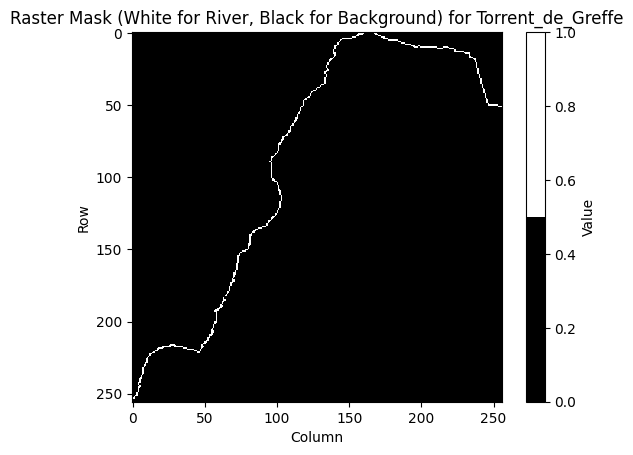

503
Bounds for Guuhetbach: [2588088.48655812 1173931.30013742 2589110.88855887 1174865.7291377 ]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Guuhetbach


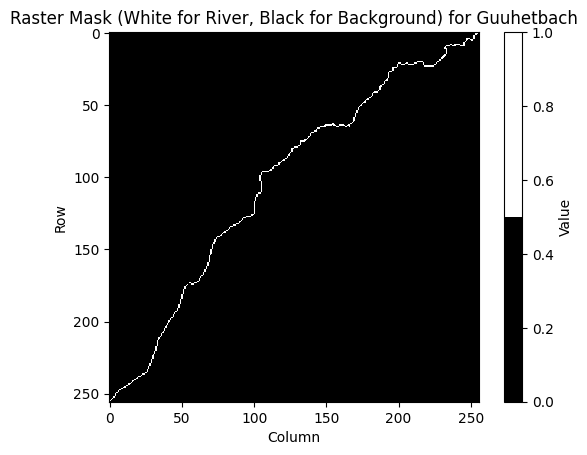

377
Bounds for LaBroye_shapefile: [2547335.00052539 1153354.00113637 2575689.00054055 1204875.00115583]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done LaBroye_shapefile


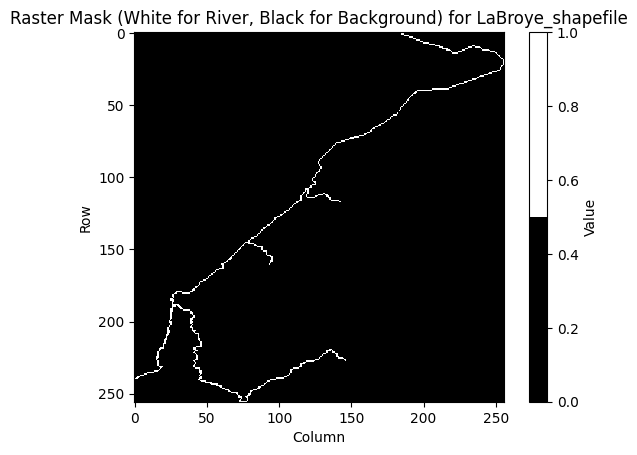

721
Bounds for Ragn_da_Colm: [2768686.58971124 1159353.53107811 2771123.20871354 1161361.40207981]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ragn_da_Colm


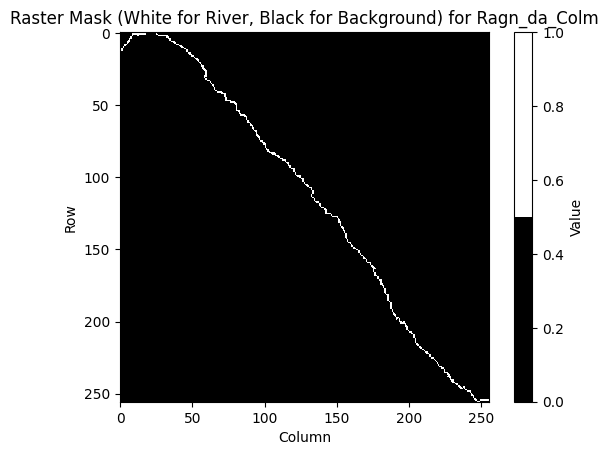

436
Bounds for Raptgusa: [2744409.52869181 1163245.26008822 2747064.35669373 1163945.96908776]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Raptgusa


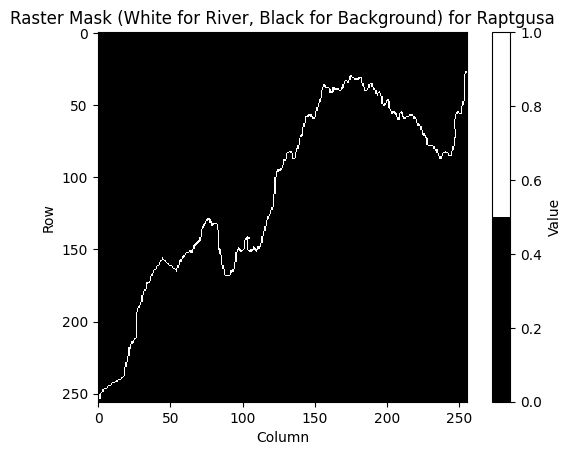

676
Bounds for Alplibach: [2777154.41470132 1209235.53009488 2777994.11970107 1211742.62209529]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Alplibach


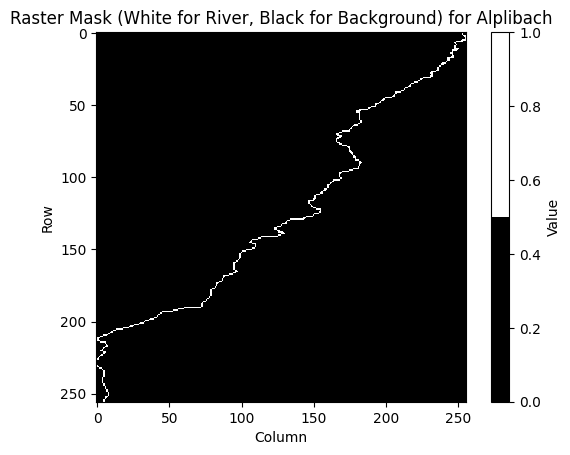

505
Bounds for La_Paudeze: [2540853.74452063 1150628.56213839 2545014.1735234  1155193.94213944]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done La_Paudeze


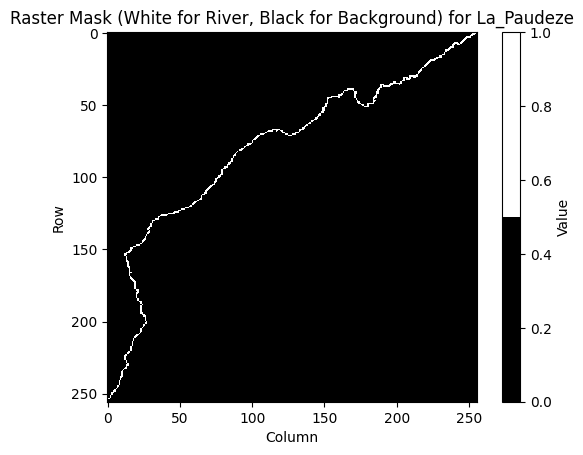

523
Bounds for LaVenoge_shapefile: [2517765.00049757 1145382.00113829 2531987.97451165 1167674.95414947]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done LaVenoge_shapefile


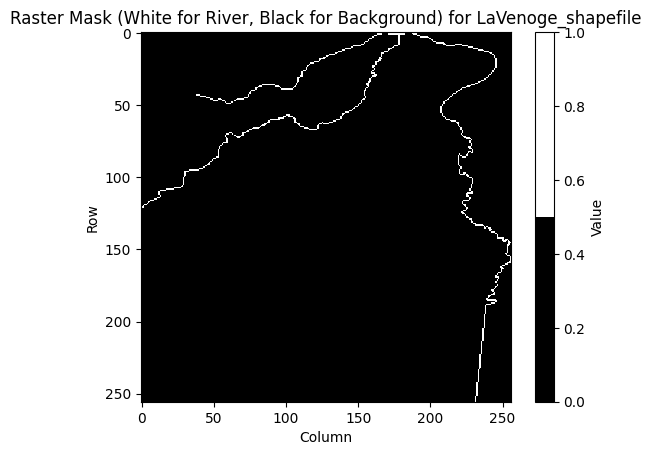

829
Bounds for Ri_dei_Calcestri: [2699461.23765845 1154283.34709754 2701870.20166073 1155525.68309886]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ri_dei_Calcestri


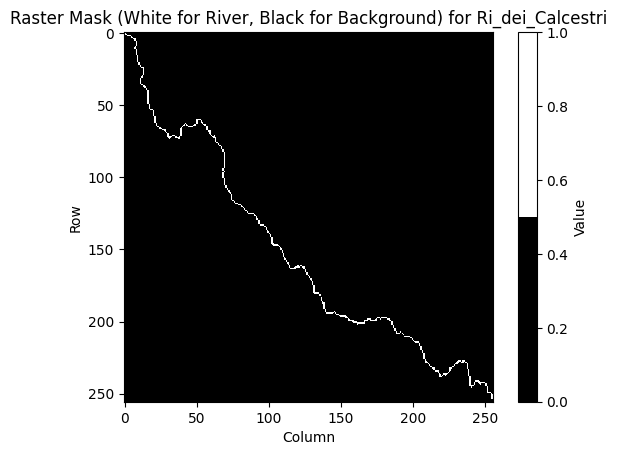

457
Bounds for Susasca: [2792495.63972229 1179873.67207811 2801195.72572851 1181339.7110776 ]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Susasca


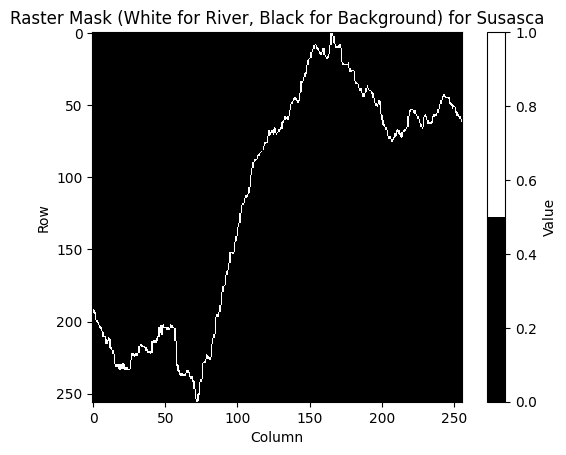

828
Bounds for Calcascia: [2691994.7246534  1149607.06109816 2693285.074655   1152665.29010004]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Calcascia


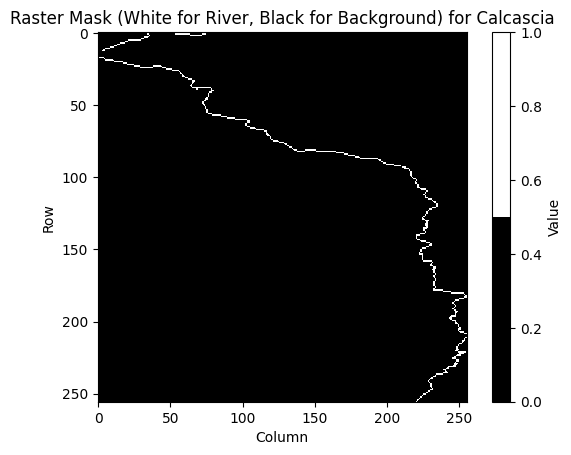

616
Bounds for swissTLMboiron: [2518401.91049879 1148164.44714075 2527392.5135078  1159309.10314708]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done swissTLMboiron


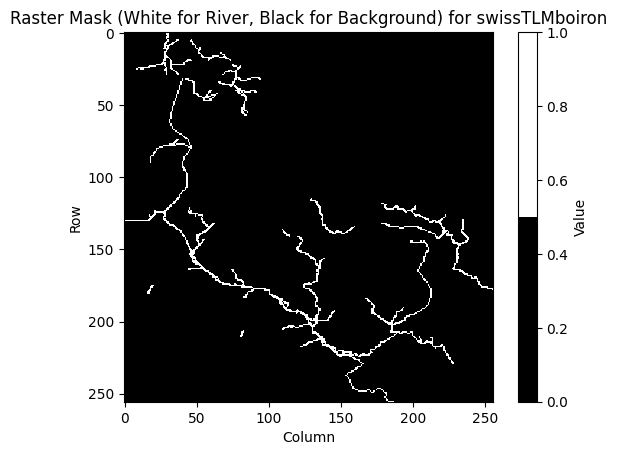

1872
Bounds for Tschagibach: [2783511.05971059 1196192.87208822 2784460.8767107  1197485.72708813]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Tschagibach


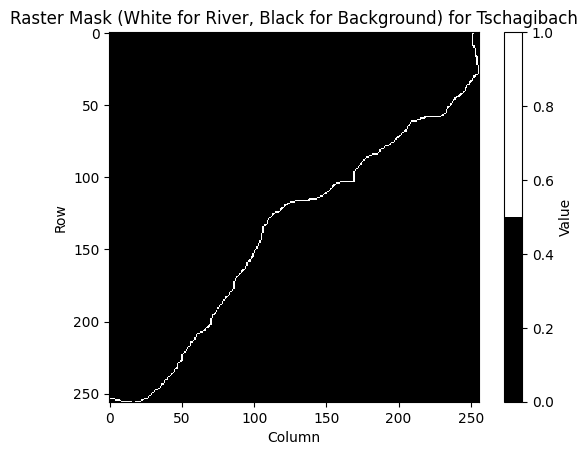

385
Bounds for Spitzalpelibach: [2711406.26065801 1187779.78610812 2712534.25965915 1188378.36610847]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Spitzalpelibach


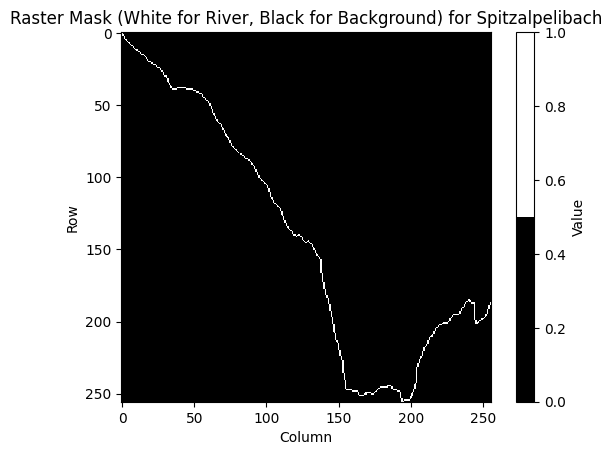

444
Bounds for Fiume_Peccia: [2685382.66364956 1139915.12809432 2692762.22265776 1146523.4970985 ]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Fiume_Peccia


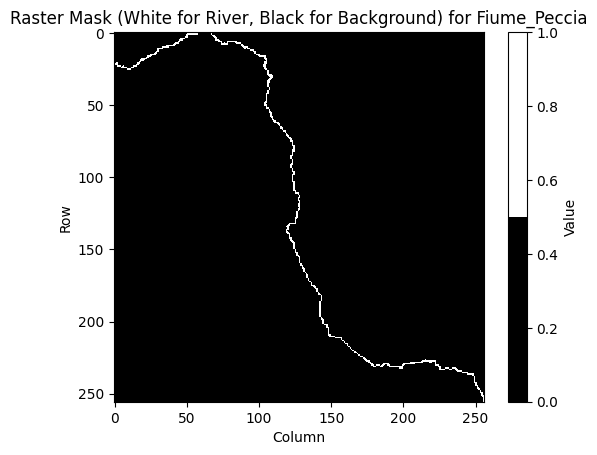

579
Bounds for Wasserfallenbach: [2686856.8106299  1215875.47512641 2687187.04363048 1217255.21112718]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Wasserfallenbach


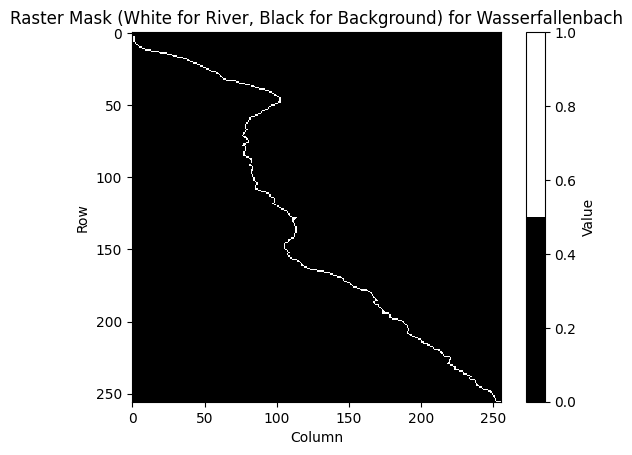

443
Bounds for Wiesenbach: [2700600.9896261  1263971.71313807 2703466.77362824 1264282.8401377 ]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Wiesenbach


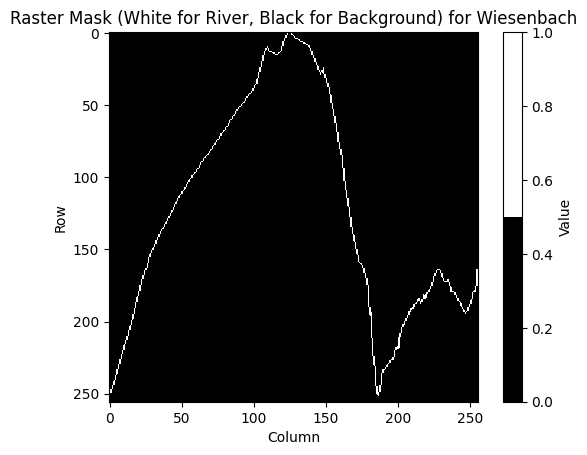

714
Bounds for Jorenbach: [2689866.5406236  1245509.14113583 2690468.06162364 1246981.26013616]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Jorenbach


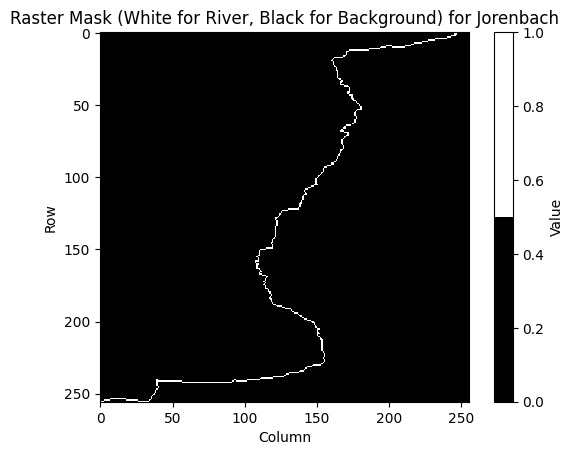

557
Bounds for Ruisseau_de_la_Leyvra: [2576094.38755313 1146246.71612791 2577069.04855461 1149815.34212935]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ruisseau_de_la_Leyvra


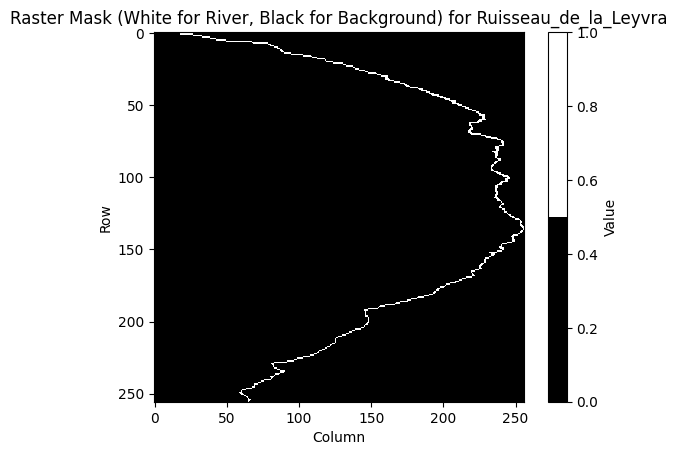

727
Bounds for Usser_Bargelbach: [2647383.44661088 1166705.71411828 2648673.77461285 1169490.17511959]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Usser_Bargelbach


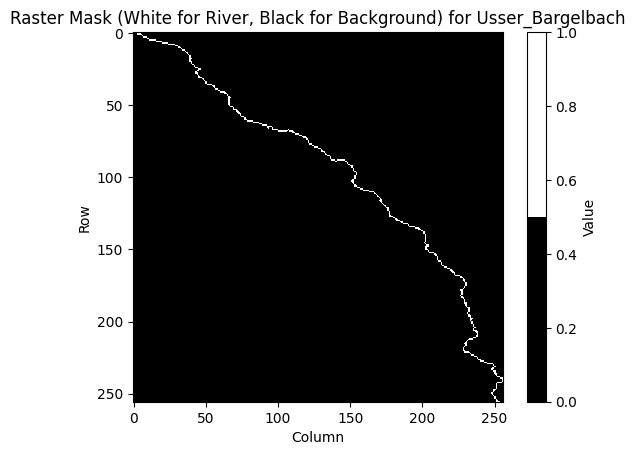

436
Bounds for I_Custiell: [2687054.51765854 1120134.63508664 2687366.89765876 1120728.85008696]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done I_Custiell


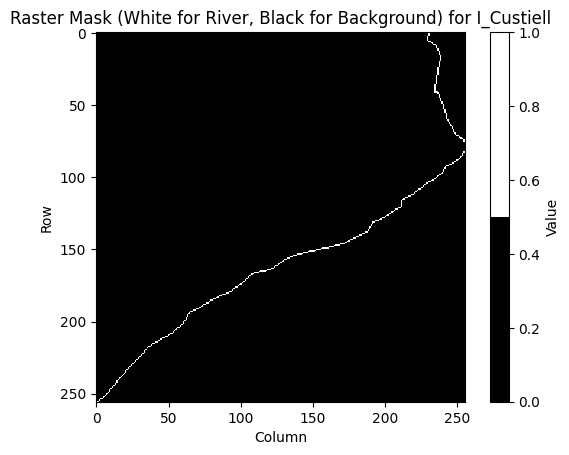

358
Bounds for Guetentalbach: [2743432.7196785  1202263.98910351 2745533.20268014 1202578.46910316]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Guetentalbach


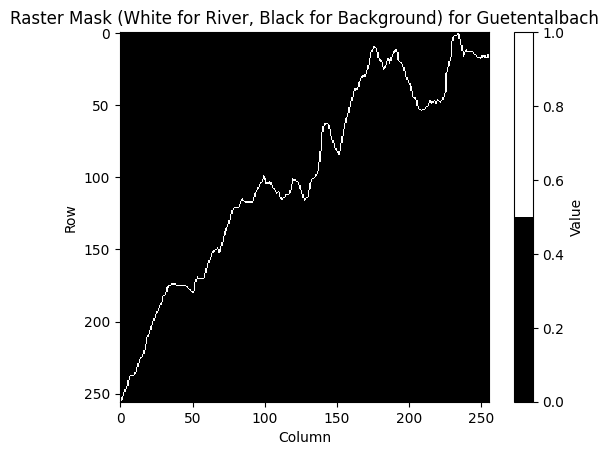

604
Bounds for Eibachli: [2583448.95255307 1176839.87313985 2584091.03155388 1177926.20914048]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Eibachli


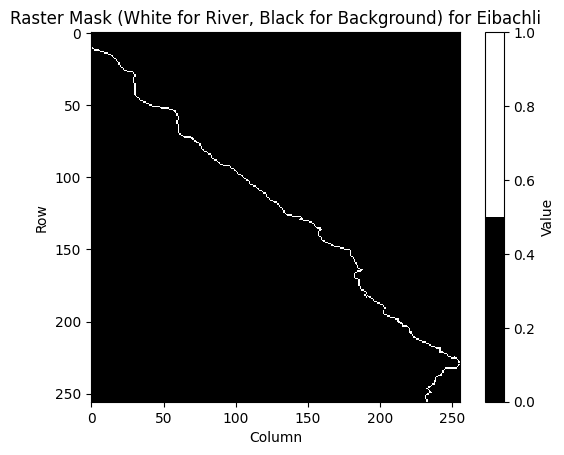

393
Bounds for Ri_di_Piera: [2709025.8986664  1153670.82109438 2713720.17567075 1155041.82509584]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ri_di_Piera


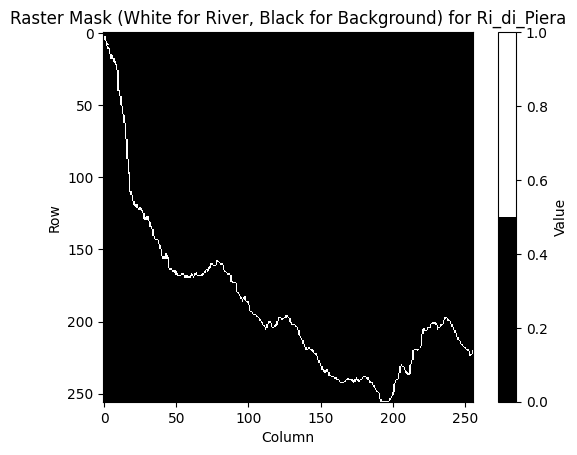

584
Bounds for Emme: [2607220.69656356 1178704.48912672 2639356.1036007  1225592.74615267]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Emme


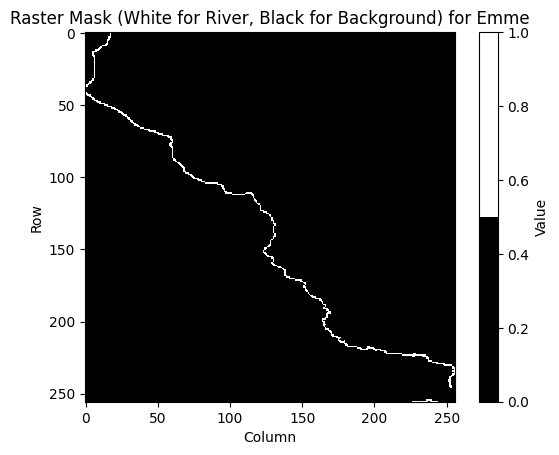

566
Bounds for La_Saufla: [2556041.65054349 1109378.7931138  2559065.56354655 1112060.76611572]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done La_Saufla


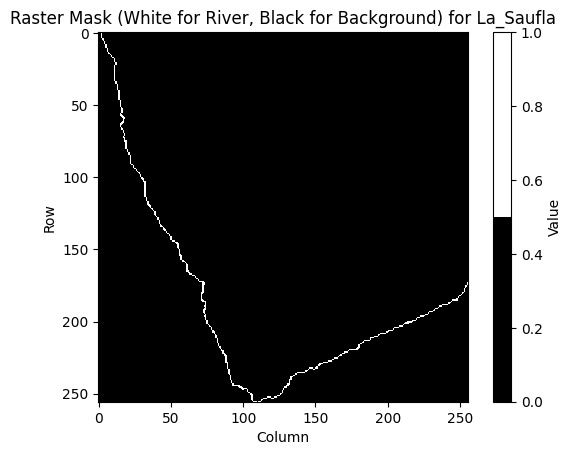

475
Bounds for Maira_|_Mera: [2764294.12971423 1134336.94107002 2770901.13471987 1140996.32807249]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Maira_|_Mera


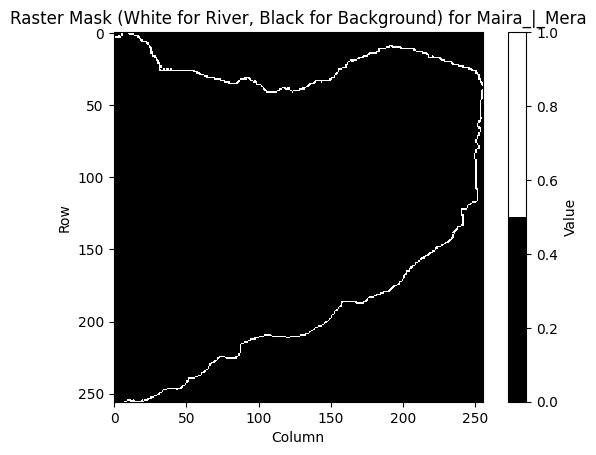

793
Bounds for Haagbach: [2599877.97855449 1226763.07315546 2600797.45955571 1228357.62615627]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Haagbach


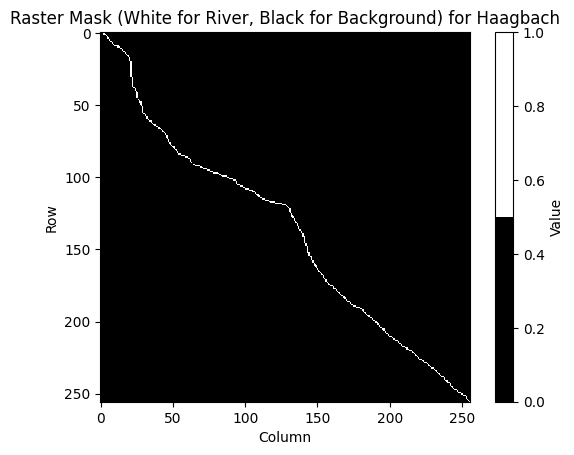

340
Bounds for Riale_della_Fontana: [2713830.24667597 1136571.9560866  2714689.827676   1138716.54708719]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Riale_della_Fontana


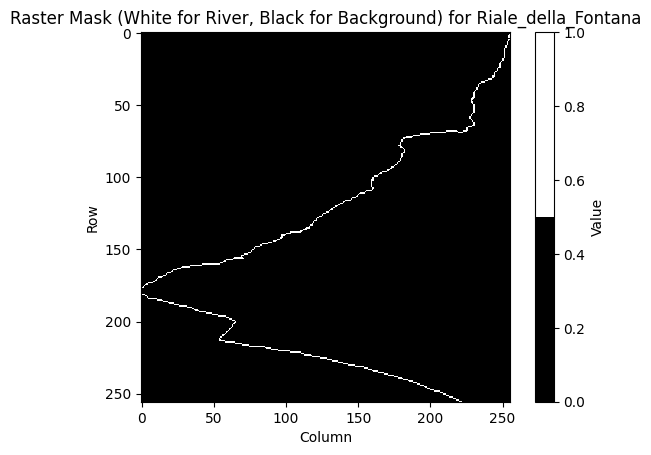

594
Bounds for Stossbach: [2659703.62461085 1206880.45513138 2660740.20161166 1207523.09013149]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Stossbach


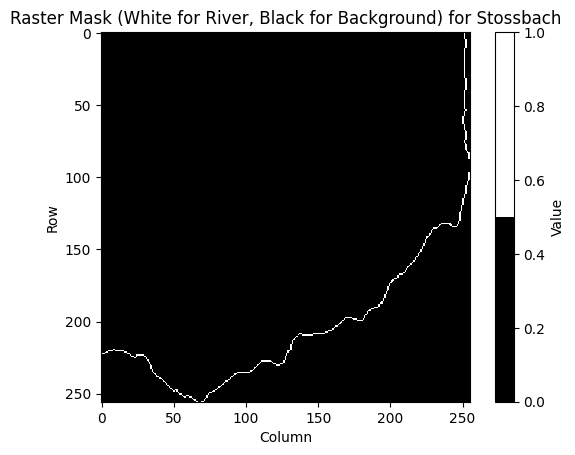

423
Bounds for Leiterbergbach: [2724672.77366663 1194113.86510645 2726558.39966816 1194622.29010637]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Leiterbergbach


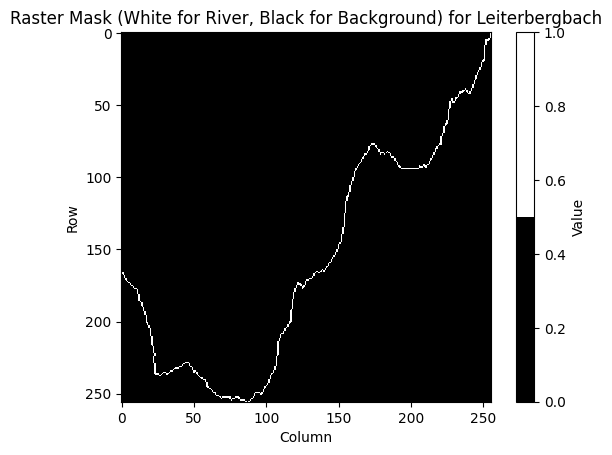

516
Bounds for Riale_di_Motom: [2703219.69866866 1131570.82708725 2704968.82167011 1132135.32808729]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Riale_di_Motom


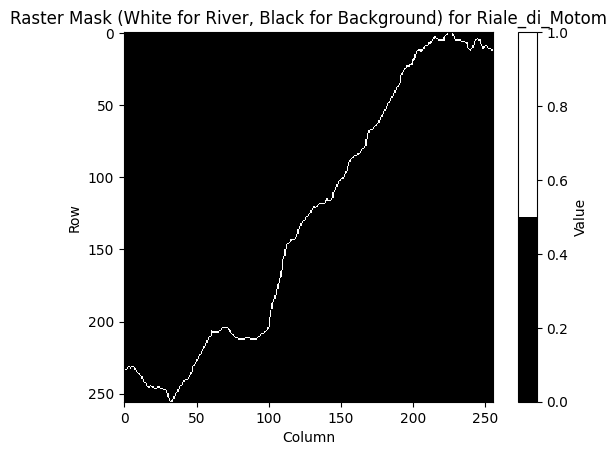

416
Bounds for Bisse-Neuf: [2601775.63158366 1120965.14810947 2604201.50058574 1121554.20710932]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Bisse-Neuf


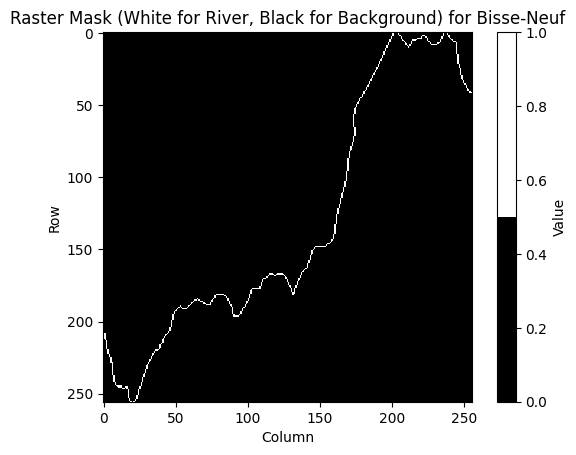

521
Bounds for Chrauchbach: [2732589.32567048 1202301.78010735 2736624.74967149 1208751.84110812]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Chrauchbach


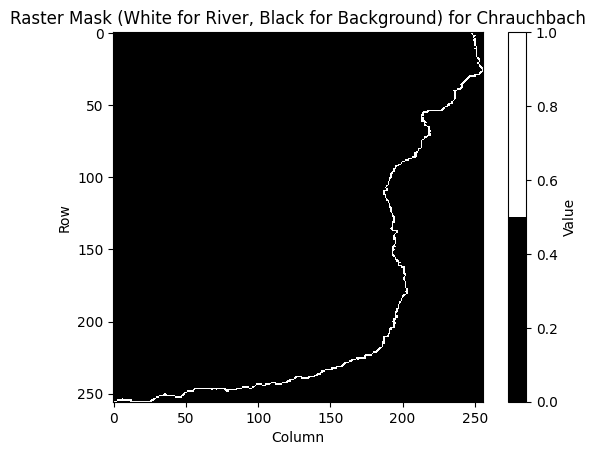

567
Bounds for Kasperabach: [2588871.70055997 1168932.03113493 2590158.86856117 1169517.50613537]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Kasperabach


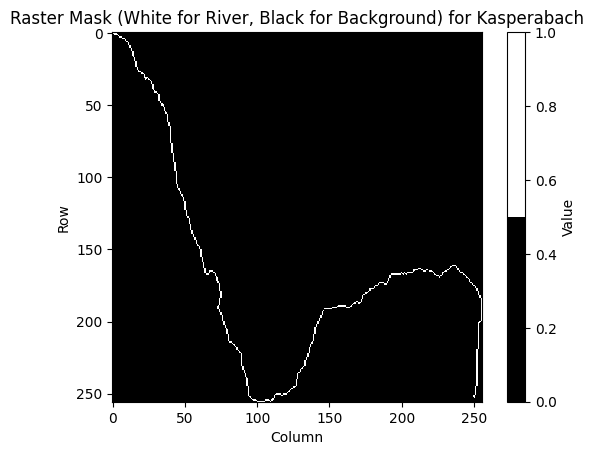

550
Bounds for Ruisseau_de_Chatillon: [2591063.30954283 1239588.66816208 2592788.90954519 1243659.89416404]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ruisseau_de_Chatillon


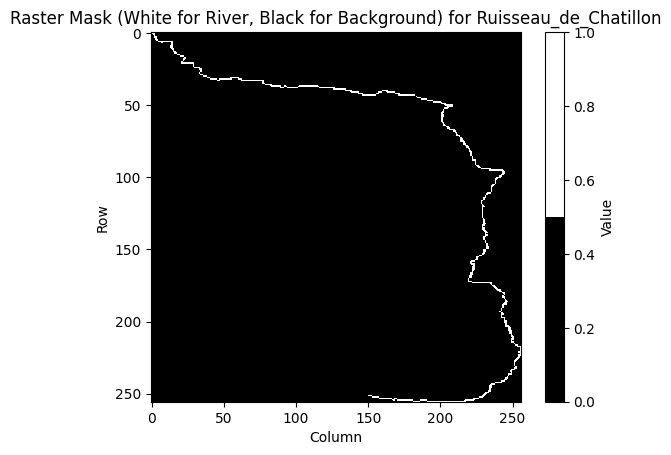

703
Bounds for Zauggenbach: [2706482.93364361 1222005.16512252 2706780.52564373 1223469.80412313]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Zauggenbach


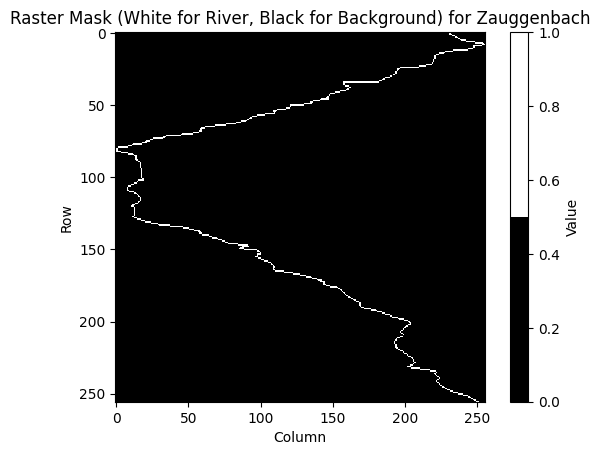

698
Bounds for El_Ri_Vall_Mala: [2693851.68665983 1135191.01209117 2695481.98766123 1136008.17609229]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done El_Ri_Vall_Mala


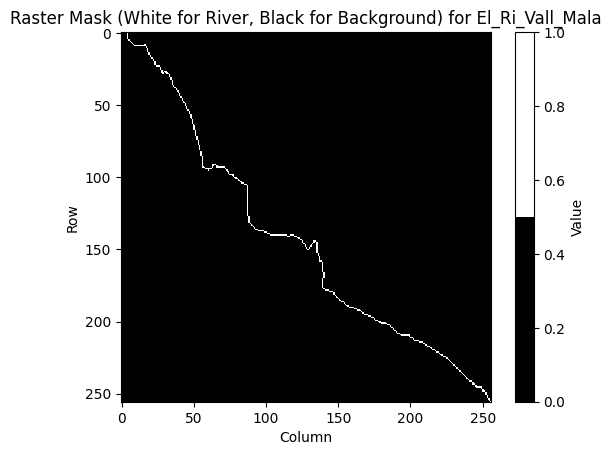

385
Bounds for Tschermanner_Bach: [2731089.96166537 1214049.69511185 2731664.30466564 1214711.53611196]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Tschermanner_Bach


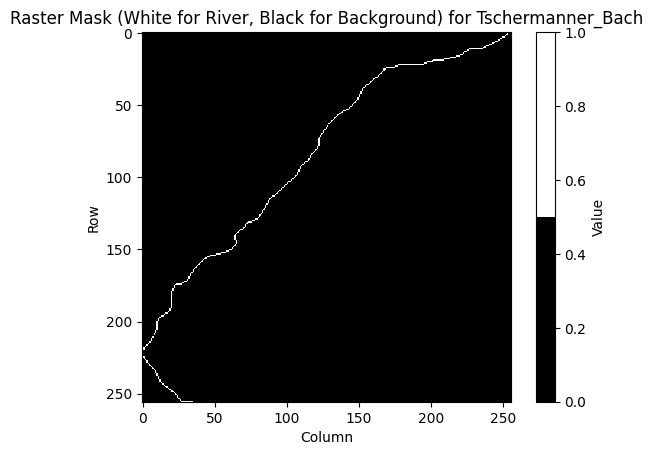

360
Bounds for Schusselbach: [2686299.11062949 1215729.88712657 2686646.6616301  1217620.64612747]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Schusselbach


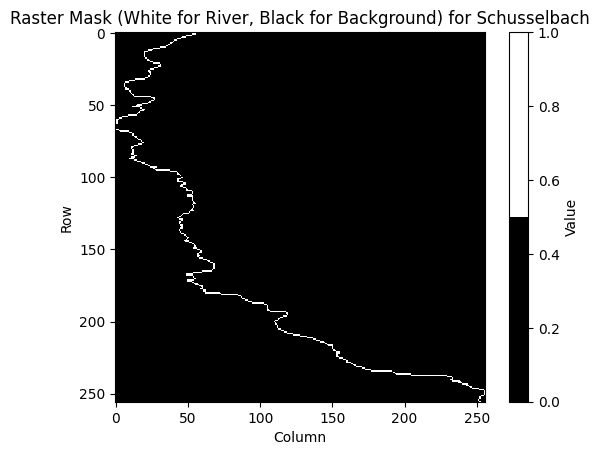

637
Bounds for le_boiron2: [2519377.12049971 1149541.39614156 2525438.42550625 1157897.39914635]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done le_boiron2


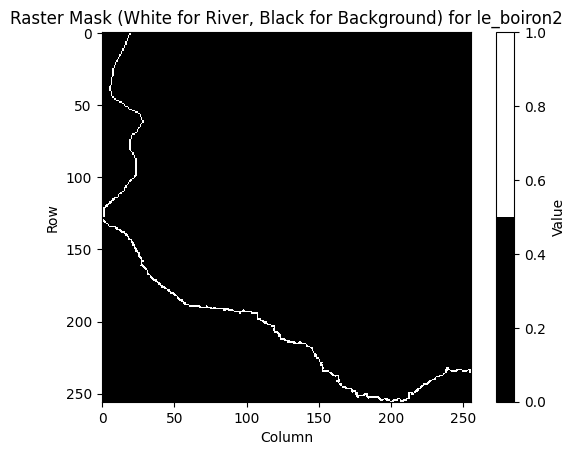

580
Bounds for Aletenbach: [2634131.98457596 1254778.59915553 2635575.72157714 1254939.41215576]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Aletenbach


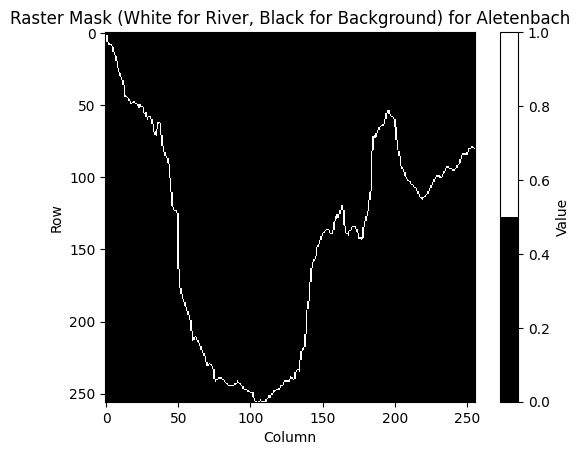

744
Bounds for Ruisseau_du_Perelet: [2540246.35751406 1176299.1791501  2540546.71351445 1177842.87215082]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Ruisseau_du_Perelet


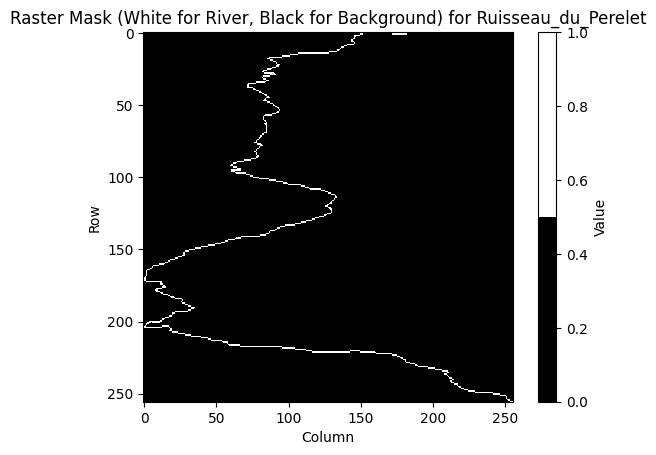

857
Bounds for Bruederbach: [2753062.10366912 1250408.30711593 2754892.94967092 1253146.20711712]
Min value: 0.0
Max value: 1.0
shape: (256, 256)
done Bruederbach


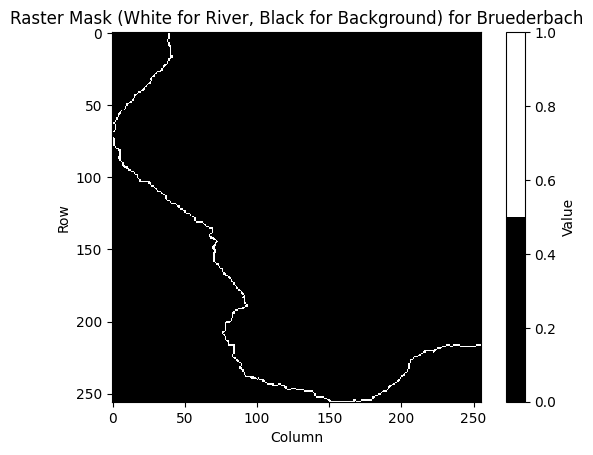

522


In [113]:
# Desired output size
output_shape = (256, 256)
binary_masks = []
for k, river in rivers.items():
    river_original = river.to_crs(original_crs)

    # Check the bounds of the filtered river geometries
    x_min, y_min, x_max, y_max = list(river_original.total_bounds)
    print(f"Bounds for {k}: {river_original.total_bounds}")
    
    # Create the transform for 256x256 grid based on the bounds
    grid_width = output_shape[1]  # 256 pixels for width
    grid_height = output_shape[0]  # 256 pixels for height
    x_res = (x_max - x_min) / grid_width
    y_res = (y_max - y_min) / grid_height

    transform = from_origin(x_min, y_max, x_res, y_res)

    # Convert the LineStrings to a list of geometries for rasterization
    line_geometries = river_original.geometry.values

    # Create a raster mask for the output shape (256x256)
    out_shape = output_shape
    raster_array = np.zeros(out_shape)

    # Rasterize each LineString into the grid
    for i, geom in enumerate(line_geometries):
        if geom.is_empty:
            print(f"Empty geometry for {k}, skipping.")
            continue
        shape = (geom, 1)  # Assign a value of 1 for each line
        temp_mask = rasterize([shape], out_shape=out_shape, transform=transform)
        raster_array += temp_mask

    # Binarize the raster
    binary_mask = np.where(raster_array > 0.0, 1.0, 0.0)
    print(f"Min value: {binary_mask.min()}")
    print(f"Max value: {binary_mask.max()}")
    print('shape:', binary_mask.shape)
    binary_masks.append(binary_mask)
    print('done', k)

    # Define a colormap (black for background, white for river)
    cmap = plt.cm.colors.ListedColormap(['black', 'white'])
    
    # Display the rasterized mask with a custom colormap
    plt.imshow(binary_mask, cmap=cmap)
    plt.colorbar(label='Value')
    plt.title(f'Raster Mask (White for River, Black for Background) for {k}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()
    print(len(np.nonzero(binary_mask.reshape(-1))[0]))

    # Save the raster
    save_raster(raster_array, f'../data/external/raster_masks/raster_mask_bw_{k}.tif', river)


#### Mask the water temperature data to Le Boiron river

 Quadrant mask to assign to its correspondent values

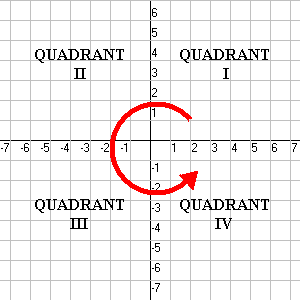

In [114]:
raw_data_path = '../data/raw/wt'

os.makedirs(raw_data_path, exist_ok=True)
clear_directory(raw_data_path)

for r in rivers.keys():
  dest_dir = os.path.join(raw_data_path, r)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)

In [115]:
for i, (k, river) in enumerate(rivers.items()):
    print('Doing',i)
    destination_folder = f'../data/raw/wt/{k}/'
    closest_points = closest[k]
    dates = list(closest_points['upper_right']['time'].unique())
    for d in dates:
        ur = closest_points['upper_right'][closest_points['upper_right'].time == d]
        ul = closest_points['upper_left'][closest_points['upper_left'].time == d]
        ll = closest_points['lower_left'][closest_points['lower_left'].time == d]
        lr = closest_points['lower_right'][closest_points['lower_right'].time == d]
        binary_mask = binary_masks[i]

        height, width = binary_mask.shape

        # Define los límites de los cuadrantes
        half_height = height // 2
        half_width = width // 2

        # Crea una máscara para cada cuadrante
        mask_q1 = np.zeros_like(binary_mask, dtype=np.float32)
        mask_q2 = np.zeros_like(binary_mask, dtype=np.float32)
        mask_q3 = np.zeros_like(binary_mask, dtype=np.float32)
        mask_q4 = np.zeros_like(binary_mask, dtype=np.float32)

        value_q1 = ur.waterTemperature  # Valor específico para el cuadrante 1
        value_q2 = ul.waterTemperature  # Valor específico para el cuadrante 2
        value_q3 = ll.waterTemperature  # Valor específico para el cuadrante 3
        value_q4 = lr.waterTemperature

        mask_q1[0:half_height, 0:half_width] = np.where(binary_mask[0:half_height, 0:half_width] > 0, value_q1, 0.0)
        mask_q2[0:half_height, half_width:] = np.where(binary_mask[0:half_height, half_width:] > 0, value_q2, 0.0)
        mask_q3[half_height:, 0:half_width] = np.where(binary_mask[half_height:, 0:half_width] > 0, value_q3, 0.0)
        mask_q4[half_height:, half_width:] = np.where(binary_mask[half_height:, half_width:] > 0, value_q4, 0.0)


        combined_mask = mask_q1 + mask_q2 + mask_q3 + mask_q4

        save_raster(combined_mask, f'{destination_folder}raster_mask_temp_{d.strftime("%Y-%m")}.tif', river)
        

Doing 0
Doing 1
Doing 2
Doing 3
Doing 4
Doing 5
Doing 6
Doing 7
Doing 8
Doing 9
Doing 10
Doing 11
Doing 12
Doing 13
Doing 14
Doing 15
Doing 16
Doing 17
Doing 18
Doing 19
Doing 20
Doing 21
Doing 22
Doing 23
Doing 24
Doing 25
Doing 26
Doing 27
Doing 28
Doing 29
Doing 30
Doing 31
Doing 32
Doing 33
Doing 34
Doing 35
Doing 36
Doing 37
Doing 38
Doing 39
Doing 40
Doing 41
Doing 42
Doing 43
Doing 44
Doing 45
Doing 46
Doing 47
Doing 48
Doing 49
Doing 50


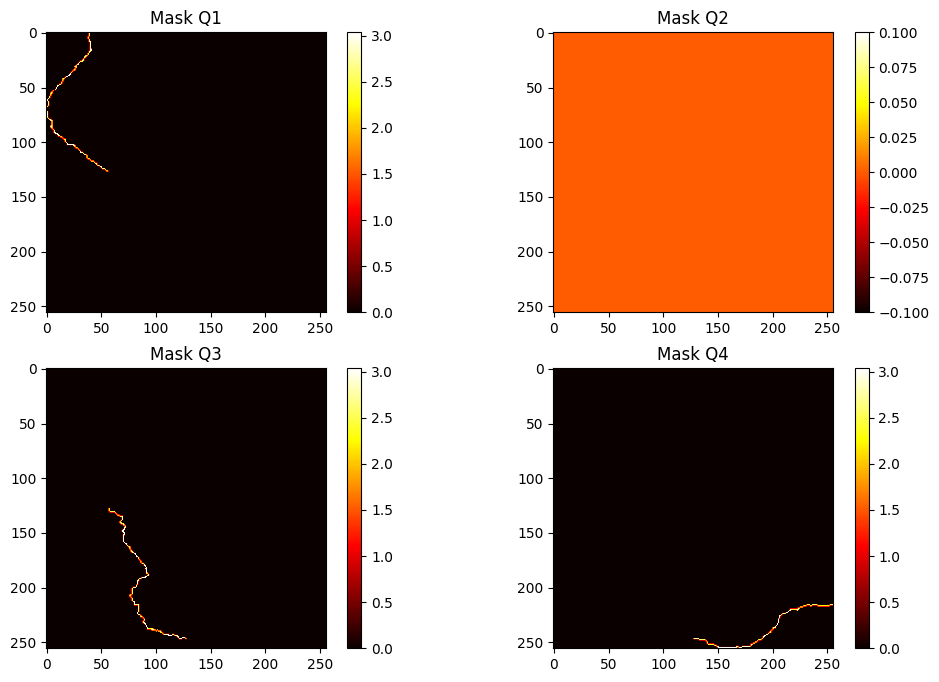

In [116]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.title('Mask Q1')
plt.imshow(mask_q1, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Mask Q2')
plt.imshow(mask_q2, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Mask Q3')
plt.imshow(mask_q3, cmap='hot')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Mask Q4')
plt.imshow(mask_q4, cmap='hot')
plt.colorbar()

plt.show()


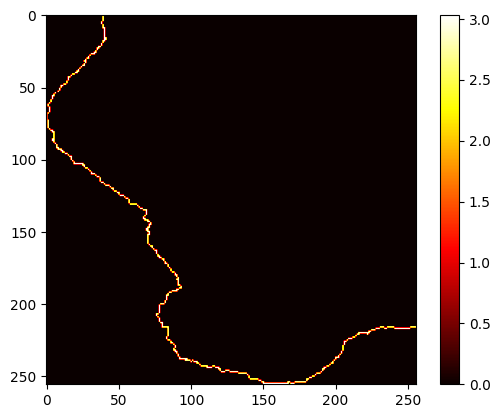

In [117]:
plt.imshow(combined_mask,cmap='hot')#, cmap='viridis')
plt.colorbar()
plt.show()

## Obtain NDVI images

In [118]:
evalscript_ndvi = """//VERSION=3

function setup() {
    return {

      input: [{
        bands: ["B04", "B05"],
      }],
      output: [{
          id: "default",
          bands: 1,
          sampleType: SampleType.FLOAT32
        },
        {
          id: "ndvi_image",
          bands: 3,
          sampleType: SampleType.AUTO
        }
      ]
    }
  }


  function evaluatePixel(sample) {
    let ndvi = (sample.B05 - sample.B04) / (sample.B05 + sample.B04)

    if (ndvi < -0.5) image = [0.05, 0.05, 0.05]
    else if (ndvi < -0.2) image = [0.75, 0.75, 0.75]
    else if (ndvi < -0.1) image = [0.86, 0.86, 0.86]
    else if (ndvi < 0) image = [0.92, 0.92, 0.92]
    else if (ndvi < 0.025) image = [1, 0.98, 0.8]
    else if (ndvi < 0.05) image = [0.93, 0.91, 0.71]
    else if (ndvi < 0.075) image = [0.87, 0.85, 0.61]
    else if (ndvi < 0.1) image = [0.8, 0.78, 0.51]
    else if (ndvi < 0.125) image = [0.74, 0.72, 0.42]
    else if (ndvi < 0.15) image = [0.69, 0.76, 0.38]
    else if (ndvi < 0.175) image = [0.64, 0.8, 0.35]
    else if (ndvi < 0.2) image = [0.57, 0.75, 0.32]
    else if (ndvi < 0.25) image = [0.5, 0.7, 0.28]
    else if (ndvi < 0.3) image = [0.44, 0.64, 0.25]
    else if (ndvi < 0.35) image = [0.38, 0.59, 0.21]
    else if (ndvi < 0.4) image = [0.31, 0.54, 0.18]
    else if (ndvi < 0.45) image = [0.25, 0.49, 0.14]
    else if (ndvi < 0.5) image = [0.19, 0.43, 0.11]
    else if (ndvi < 0.55) image = [0.13, 0.38, 0.07]
    else if (ndvi < 0.6) image = [0.06, 0.33, 0.04]
    else image = [0, 0.27, 0]

    return {
      default: [ndvi],
      ndvi_image: image
    }
  }"""

In [119]:
raw_data_path = '../data/raw/ndvi'

os.makedirs(raw_data_path, exist_ok=True)
clear_directory(raw_data_path)

for r in rivers.keys():
  dest_dir = os.path.join(raw_data_path, r)
  os.makedirs(dest_dir, exist_ok=True)
  clear_directory(dest_dir)

#### Save images

In [ ]:
import tarfile

for ii,(k, river) in enumerate(rivers.items()):
    print('Doing', ii)
    destination_folder = f'../data/raw/ndvi/{k}'
    get_data(river, evalscript_ndvi, slots, 'ndvi', destination_folder)
    counter = 0
    # Recorre todas las subcarpetas en la carpeta principal
    for subdir, dirs, files in os.walk(destination_folder):
        for file in files:
            # Si el archivo es un .tar
            if file.endswith('.tar'):
                print(f'Archivo {file} encontrado en {subdir}')
                # Construye la ruta completa del archivo tar
                tar_file_path = os.path.join(subdir, file)

                # Define el nuevo nombre de la carpeta donde se extraerán los archivos
                extract_folder_name = f'extracted_{slots[counter][0][:7]}'
                extract_folder_path = os.path.join(destination_folder, extract_folder_name)

                # Crea el directorio si no existe
                if not os.path.exists(extract_folder_path):
                    os.makedirs(extract_folder_path)

                # Abre y descomprime el archivo .tar
                with tarfile.open(tar_file_path, 'r') as tar:
                    tar.extractall(path=extract_folder_path)

                print(f'Archivo {file} descomprimido en {extract_folder_path}')

                # Busca el archivo .tif dentro de la carpeta descomprimida
                for root, dirs, extracted_files in os.walk(extract_folder_path):
                    for extracted_file in extracted_files:
                        if extracted_file.endswith('.tif'):
                            # Ruta completa del archivo .tif
                            tiff_file_path = os.path.join(root, extracted_file)

                            # Define la ruta de destino fuera de la carpeta
                            new_tiff_file_path = os.path.join(destination_folder, extracted_file)

                            new_file_name = f'ndvi_{slots[counter][0][:7]}.tiff'
                            new_file_path = os.path.join(destination_folder, new_file_name)

                            # Mueve el archivo .tif fuera de la carpeta descomprimida
                            shutil.move(tiff_file_path, new_file_path)

                            print(f'Archivo {extracted_file} movido a {new_file_path}')

                # Incrementa el contador
                counter += 1
                
    for subdir, dirs, files in os.walk(destination_folder):
        for dir in dirs:
            dir_path = os.path.join(subdir, dir)
            shutil.rmtree(dir_path, ignore_errors=True)


Doing 0
Archivo response.tar encontrado en ../data/raw/ndvi/Plattenbach/9629d0fe203c1e95c696be9e6d01c182
Archivo response.tar descomprimido en ../data/raw/ndvi/Plattenbach/extracted_2011-01
Archivo default.tif movido a ../data/raw/ndvi/Plattenbach/ndvi_2011-01.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/Plattenbach/78e5c48ba20ac4022990a4eadd2d4f6f
Archivo response.tar descomprimido en ../data/raw/ndvi/Plattenbach/extracted_2011-02
Archivo default.tif movido a ../data/raw/ndvi/Plattenbach/ndvi_2011-02.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/Plattenbach/fabd4bbae81dc17acd3a75eeac8e4196
Archivo response.tar descomprimido en ../data/raw/ndvi/Plattenbach/extracted_2011-03
Archivo default.tif movido a ../data/raw/ndvi/Plattenbach/ndvi_2011-03.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/Plattenbach/74280ed215d9a424a9a9ef7ed0f3c4d9
Archivo response.tar descomprimido en ../data/raw/ndvi/Plattenbach/extracted_2011-04
Archivo default.tif movido a ../data

/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-package

Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/8e5790c2b251cccfccc240632a44d721
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapefile/extracted_2011-01
Archivo default.tif movido a ../data/raw/ndvi/LaBroye_shapefile/ndvi_2011-01.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/efbbfd817cab90e93a45a4f7d47ccdde
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapefile/extracted_2011-02
Archivo default.tif movido a ../data/raw/ndvi/LaBroye_shapefile/ndvi_2011-02.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/032925ce29456a08afbcf579f81956ab
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapefile/extracted_2011-03
Archivo default.tif movido a ../data/raw/ndvi/LaBroye_shapefile/ndvi_2011-03.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/LaBroye_shapefile/0c5d6f27b7d939f09122b7b82b2ab63c
Archivo response.tar descomprimido en ../data/raw/ndvi/LaBroye_shapef

/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ruth.parajo/miniconda3/envs/tfg_env/lib/python3.9/site-package

Archivo response.tar encontrado en ../data/raw/ndvi/Ragn_da_Colm/855789c26e7ef14c9ea2714731032ed9
Archivo response.tar descomprimido en ../data/raw/ndvi/Ragn_da_Colm/extracted_2011-01
Archivo default.tif movido a ../data/raw/ndvi/Ragn_da_Colm/ndvi_2011-01.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/Ragn_da_Colm/6e010a7fd3267ba8cb500a879dcb7b92
Archivo response.tar descomprimido en ../data/raw/ndvi/Ragn_da_Colm/extracted_2011-02
Archivo default.tif movido a ../data/raw/ndvi/Ragn_da_Colm/ndvi_2011-02.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/Ragn_da_Colm/3f05f465fcd7fca5302ca94a6bb25a07
Archivo response.tar descomprimido en ../data/raw/ndvi/Ragn_da_Colm/extracted_2011-03
Archivo default.tif movido a ../data/raw/ndvi/Ragn_da_Colm/ndvi_2011-03.tiff
Archivo response.tar encontrado en ../data/raw/ndvi/Ragn_da_Colm/bb42c78d9556b5946383650d74800722
Archivo response.tar descomprimido en ../data/raw/ndvi/Ragn_da_Colm/extracted_2011-04
Archivo default.tif movido a ../d